In [ ]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install highway-env


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=0fdd3630dfee9bf2a22e74c774213a81b4c6d0e8757276c993211431054548c1
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.4 MB/s eta 0:00:00
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)


In [ ]:
import highway_env
highway_env.register_highway_envs()
import gymnasium as gym
import sys
import pickle


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment exit-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment highway-fast-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment intersection-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:694: UserWarning: 

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import numpy as np
from collections import deque
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm
import os
import cv2


In [ ]:
os.getcwd()
os.chdir('/content/drive/MyDrive/DDPG')
os.getcwd()


'/content/drive/MyDrive/DDPG'

In [ ]:
env = gym.make("parking-v0", render_mode="rgb_array")


In [ ]:
env.reset(seed=0)
rendered_frames = []

#
# Perform 100 random steps in the environment and store rendered frames
for _ in range(100):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, truncated, info = env.step(action)
    rendered_frames.append(env.render())
    # env.render()
    # plt.imshow(env.render())
    # # plt.axis('off')
    # plt.show()
    if done or truncated==True:
      break
# Close the environment
env.close()


In [ ]:
# env = gym.wrappers.RecordVideo(env, video_folder="/content/drive/MyDrive/Videos", name_prefix="test-video", episode_trigger=lambda x: x % 2 == 0)
# for frame in rendered_frames:
#   # plt.imshow(frame)
#   frame
#   # plt.show()
# env.close_video_recorder()

In [ ]:
obs,_=env.reset(seed=0)
# a=action_space.sample()
# obs,reward,_,_,_=env.step(a)
# env.action_space.sample()
# obs['observation']
# obs[('OrderedDict')]
# obs[0]['observation']
obs

OrderedDict([('observation',
              array([ 0.        ,  0.        , -0.        , -0.        , -0.65201626,
                     -0.75820498])),
             ('achieved_goal',
              array([ 0.        ,  0.        , -0.        , -0.        , -0.65201626,
                     -0.75820498])),
             ('desired_goal',
              array([-2.600000e-01, -1.400000e-01,  0.000000e+00,  0.000000e+00,
                      6.123234e-17, -1.000000e+00]))])

In [ ]:
# Actor Model
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        x = self.max_action * torch.tanh(self.layer3(x))
        return x

# Critic Model
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x



In [ ]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

In [ ]:
# Ornstein-Uhlenbeck Noise for exploration
class OUNoise:
    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(action_dimension) * mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def evolve_state(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state = self.state + dx
        return self.state

    def get_action(self, action):
        return self.scale * self.evolve_state() + action

In [ ]:
# DDPG Agent
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters())

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters())

        self.replay_buffer = ReplayBuffer(capacity=100000)
        self.ounoise = OUNoise(action_dim)
        self.max_action = max_action

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        action = self.actor(state).cpu().data.numpy().flatten()

        return self.ounoise.get_action(action)

    def train(self, batch_size=64):
        critic_loss_val=0
        actor_loss_val=0
        if len(self.replay_buffer) < batch_size:
            return 0,0

        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state)
        action = torch.FloatTensor(action)
        reward = torch.FloatTensor(reward).unsqueeze(1)
        next_state = torch.FloatTensor(next_state)
        done = torch.FloatTensor(done).unsqueeze(1)

        # Compute the target Q value
        target_actions = self.actor_target(next_state)
        target_Q = self.critic_target(next_state, target_actions)
        target_Q = reward + (0.99 * target_Q * (1 - done))

        # Get current Q estimate
        current_Q = self.critic(state, action)


        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q.detach())

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(param.data * 0.005 + target_param.data * (1 - 0.005))

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(param.data * 0.005 + target_param.data * (1 - 0.005))

        return critic_loss.item(),actor_loss.item()

In [ ]:
# Prepare the environment
env=gym.make("parking-v0", render_mode="rgb_array")

# env.unwrapped.config['collision_reward']=-1000
# env.unwrapped.config['reward_weights']=[50, 10, 10, 10, 0.02, 0.02]
env.unwrapped.config['add_walls']=False
# env.unwrapped.config['success_goal_reward']=100
env.unwrapped.config['duration']=40
state_dim = 6
action_dim = 2
max_action = float(env.action_space.high[0])
rendered_frames=[]
agent = DDPGAgent(state_dim, action_dim, max_action)
num_steps = 5000
i_episode=0
rewards=[]
lengths=[]
losses=[]
pbar = tqdm.trange(num_steps)
for t_total in pbar:
    state,_ = env.reset(seed=0)
    state=state['observation']
    episode_reward = 0
    done = False
    truncated= False
    step=0
    critic_loss_sum=0
    actor_loss_sum=0
    training_steps=0

    for _ in range(1000):
        step+=1
        action = agent.select_action(np.array(state))
        next_state, reward, done, truncated ,info = env.step(action)
        next_state=next_state['observation']


        agent.replay_buffer.add(state, action, reward, next_state, done)

        critic_loss,actor_loss=agent.train(batch_size=64)
        critic_loss_sum += critic_loss
        actor_loss_sum += actor_loss
        if critic_loss and actor_loss:
            training_steps +=1

        state = next_state
        episode_reward += reward

        if t_total%499 == 0:
          rendered_frames.append(env.render())


        if done or truncated:
          avg_critic_loss =critic_loss_sum/training_steps if training_steps else 0
          avg_actor_loss=actor_loss_sum/training_steps if training_steps else 0
          total_loss=avg_critic_loss+avg_critic_loss
          pbar.set_description(
                      f'Episode: {i_episode} | Steps: {step + 1} | Return: {episode_reward:5.2f} |Loss: {total_loss} '
            )
          lengths.append(step+1)
          losses.append(total_loss)
          rewards.append(episode_reward)
          break
    i_episode+=1
env.close()


Episode: 4999 | Steps: 20 | Return: -8.25 |Loss: 0.01723027047946265 : 100%|██████████| 5000/5000 [2:33:13<00:00,  1.84s/it]


In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [ ]:
file_path_DDPG_returns = "DDPG_Returns.pkl"
file_path_DDPG_losses="DDPG_Losses.pkl"
file_path_DDPG_frames="DDPG_frames.pkl"

In [ ]:
with open(file_path_DDPG_returns, 'wb') as f:
    pickle.dump(rewards, f)
with open(file_path_DDPG_losses, 'wb') as f:
    pickle.dump(losses, f)
with open(file_path_DDPG_frames, 'wb') as f:
    pickle.dump(rendered_frames, f)

In [ ]:
with open(file_path_DDPG_returns, 'rb') as f :
  DDPG_returns = pickle.load(f)
with open(file_path_DDPG_losses, 'rb') as f :
  DDPG_losses = pickle.load(f)
with open(file_path_DDPG_frames, 'rb') as f :
  DDPG_frames = pickle.load(f)



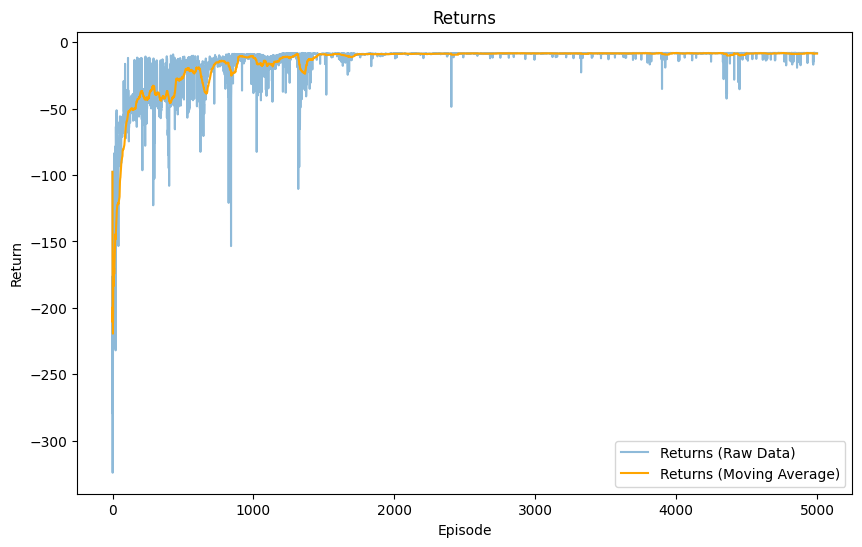

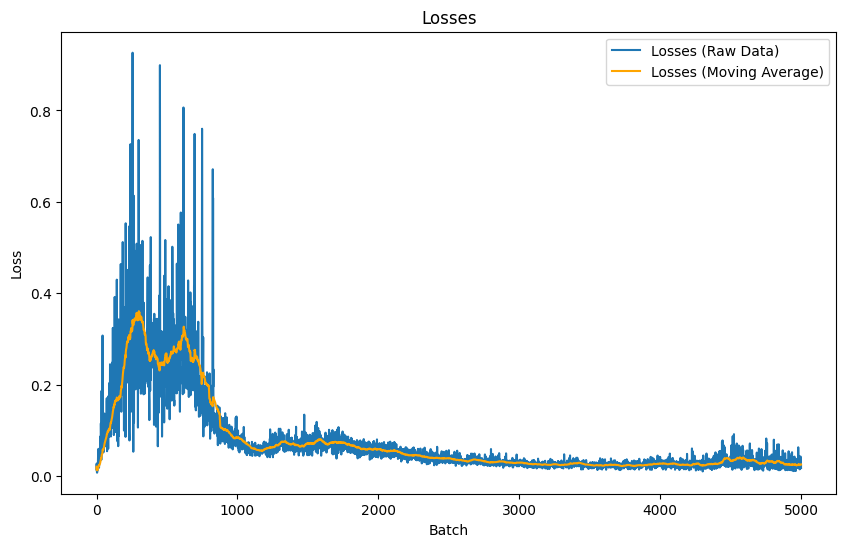

In [ ]:
# YOUR PLOTTING CODE HERE
plt.figure(figsize=(10, 6))
# plt.subplot(3, 1, 1)
plt.plot(DDPG_returns, label='Returns (Raw Data)', alpha=0.5)
plt.plot(moving_average(DDPG_returns), label='Returns (Moving Average)', color='orange')
plt.title('Returns')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()
plt.show()
plt.close()

# plt.figure(figsize=(10, 6))
# plt.plot(DD, label='Lengths (Raw Data)', alpha=0.5)
# plt.plot(moving_average(lengths), label='Lengths (Moving Average)', color='orange')
# plt.title('Lengths')
# plt.xlabel('Episode')
# plt.ylabel('Length')
# plt.legend()
# plt.show()
# plt.close()

plt.figure(figsize=(10, 6))
plt.plot(DDPG_losses, label='Losses (Raw Data)')
plt.plot(moving_average(DDPG_losses), label='Losses (Moving Average)', color='orange')
plt.title('Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

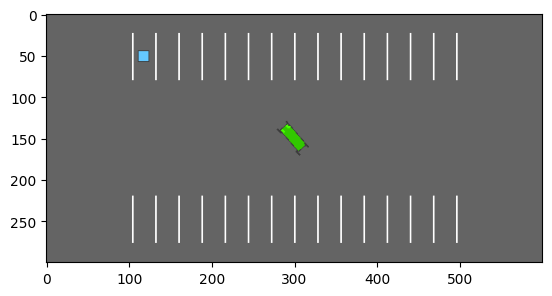

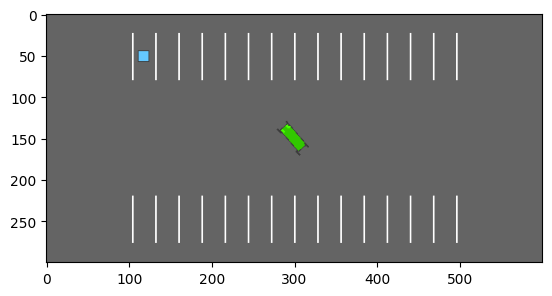

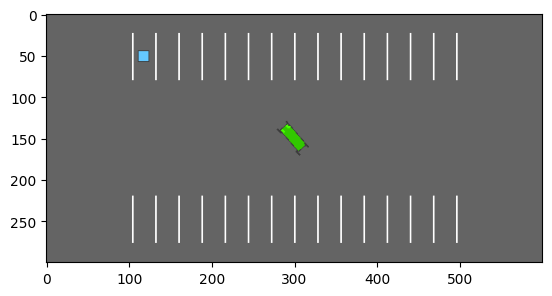

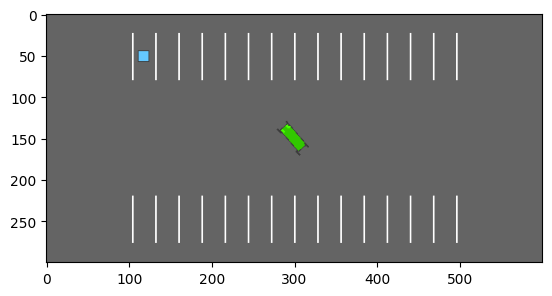

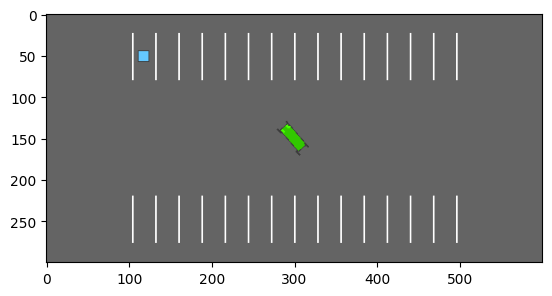

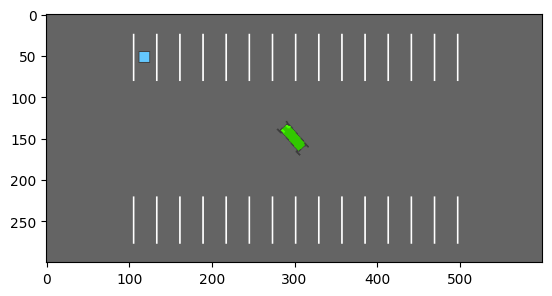

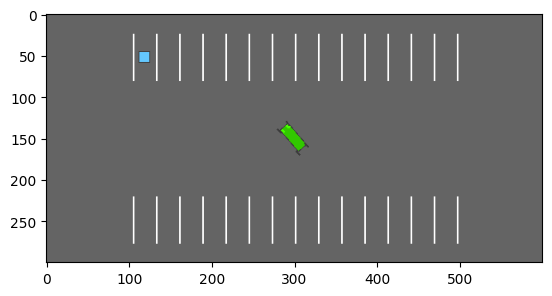

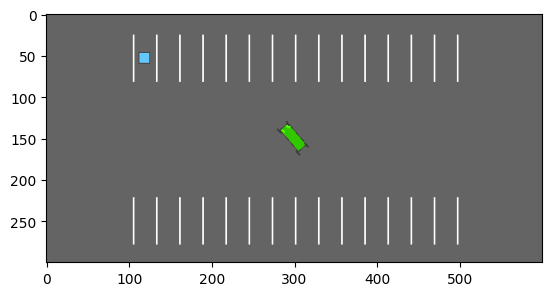

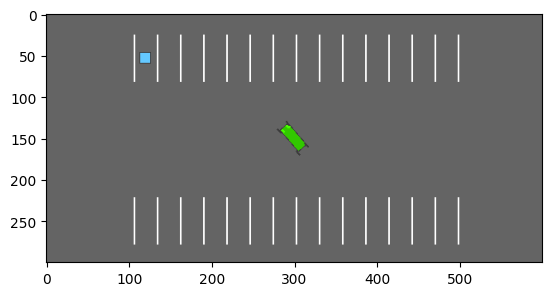

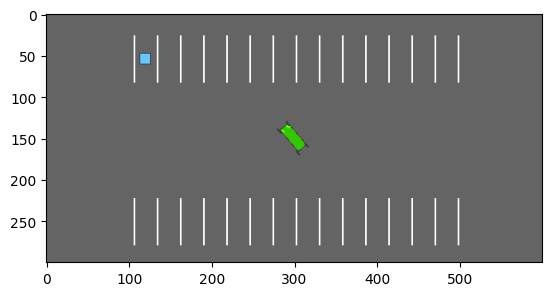

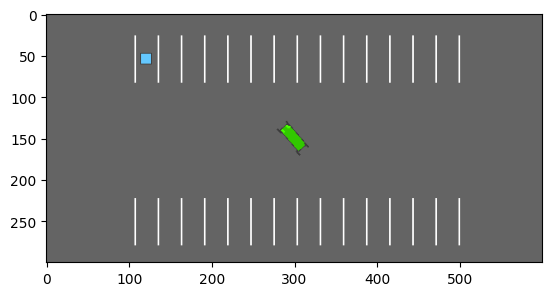

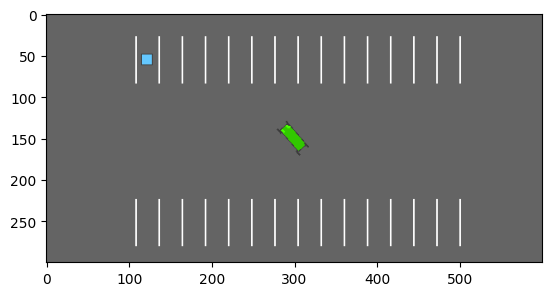

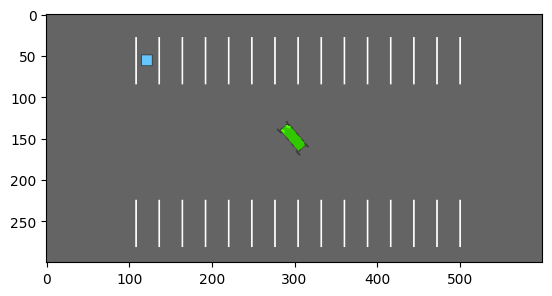

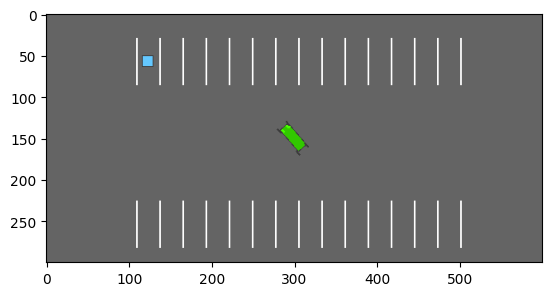

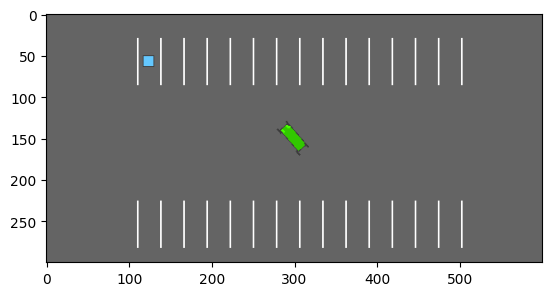

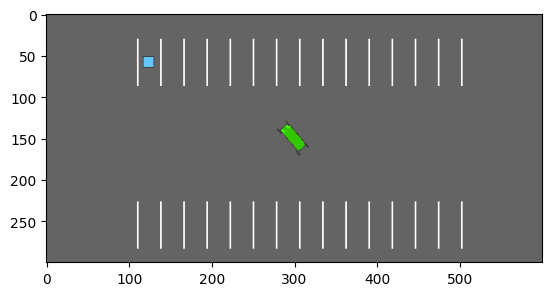

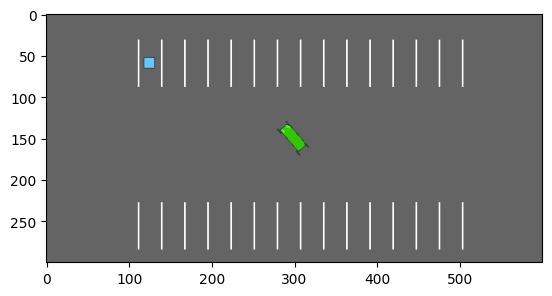

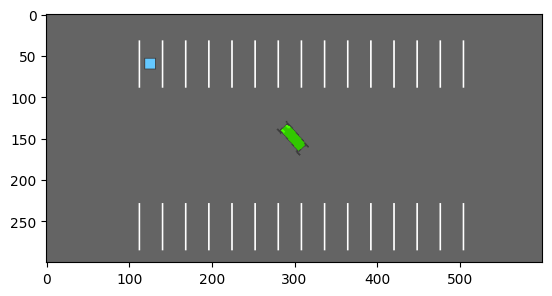

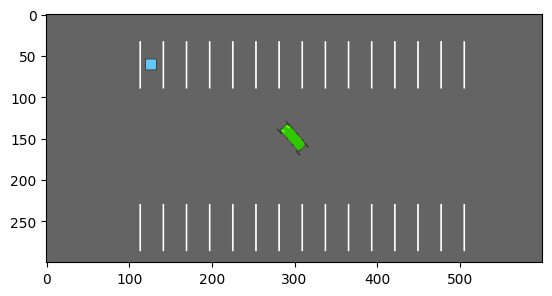

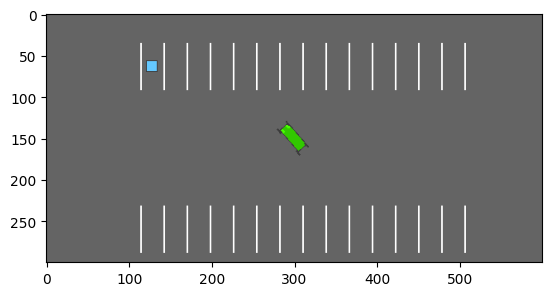

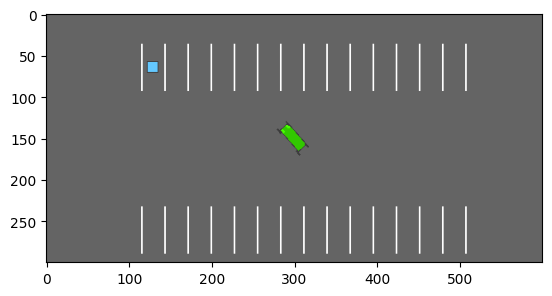

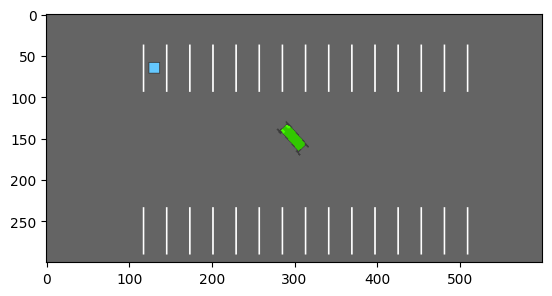

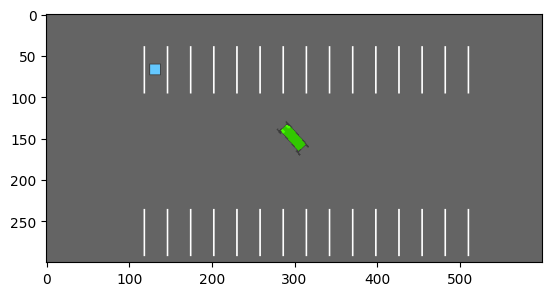

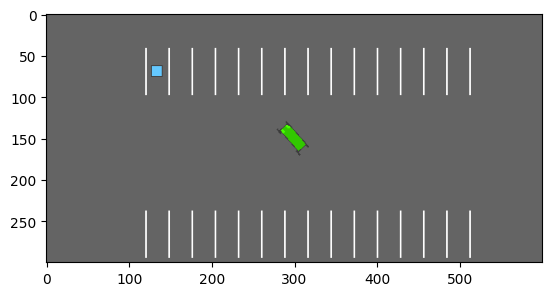

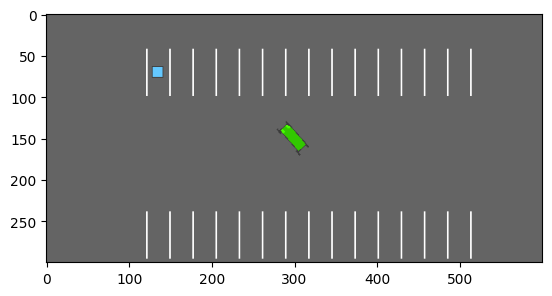

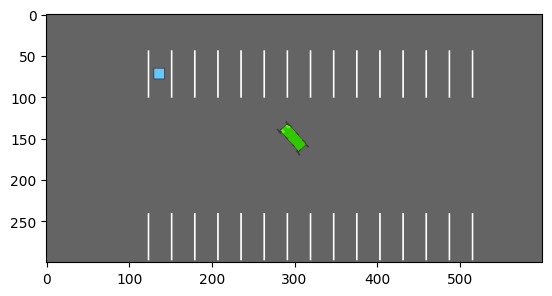

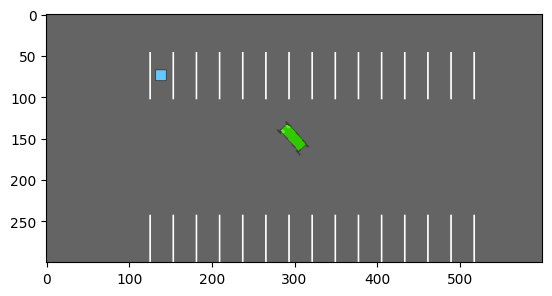

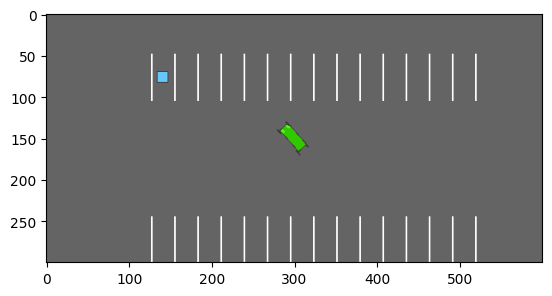

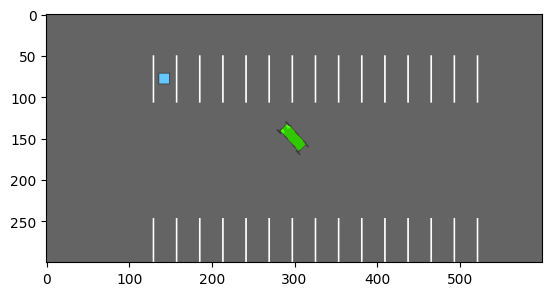

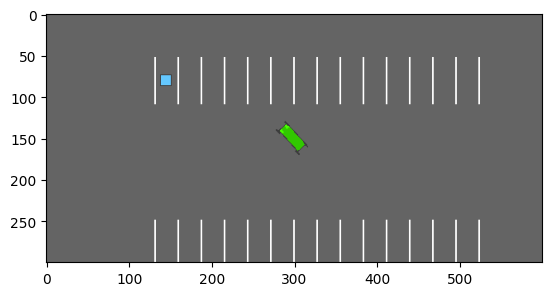

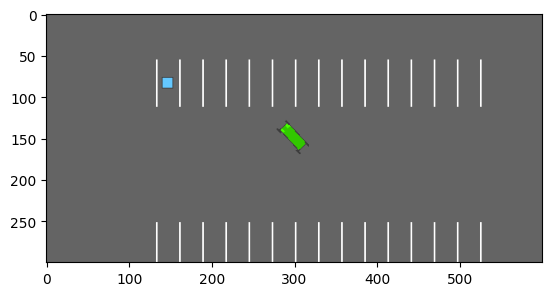

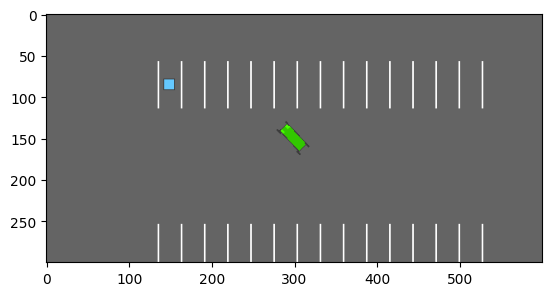

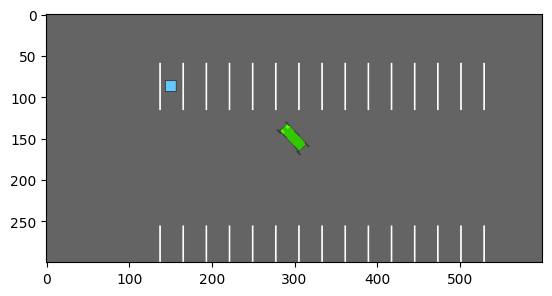

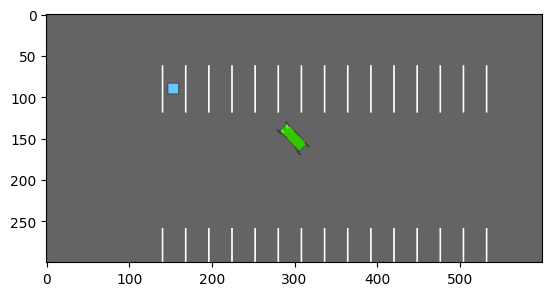

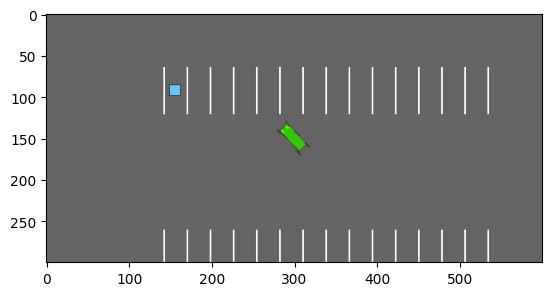

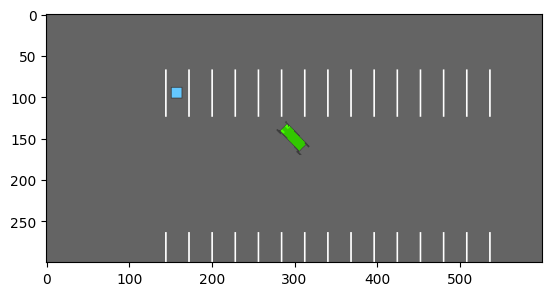

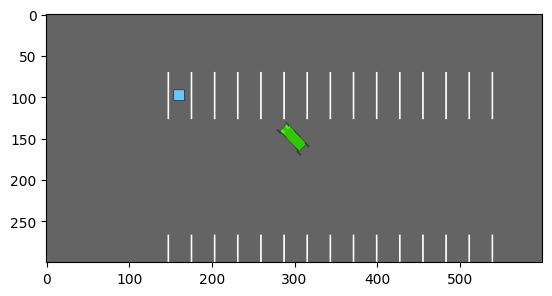

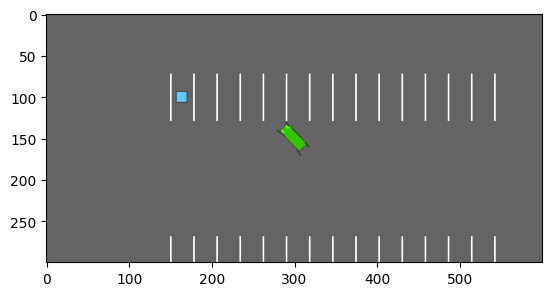

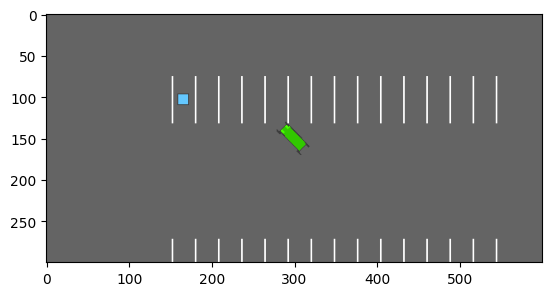

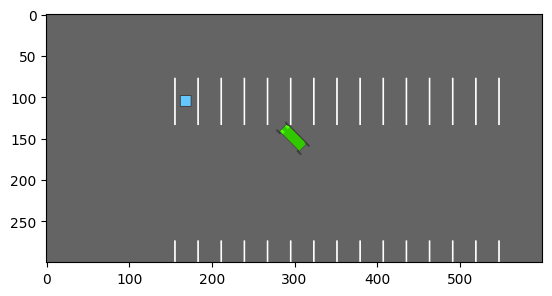

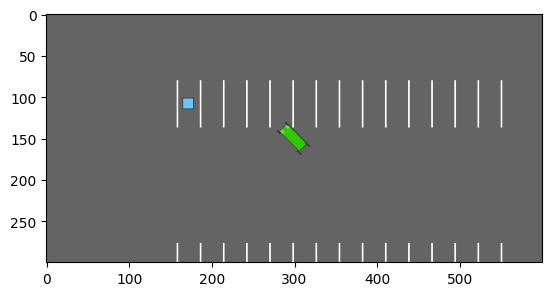

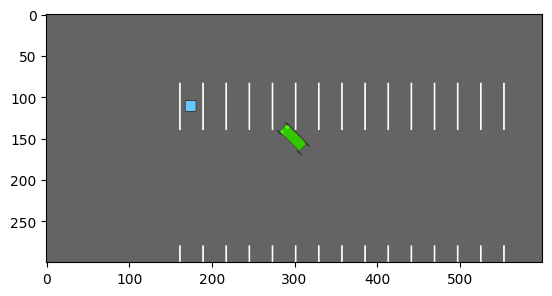

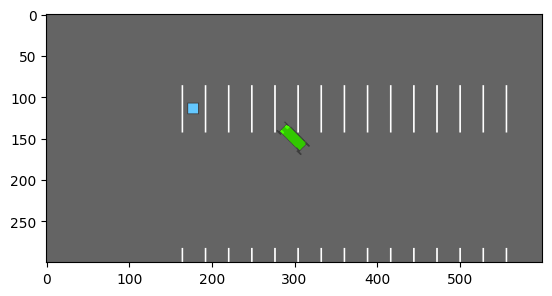

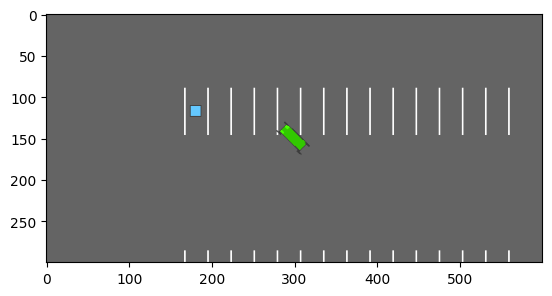

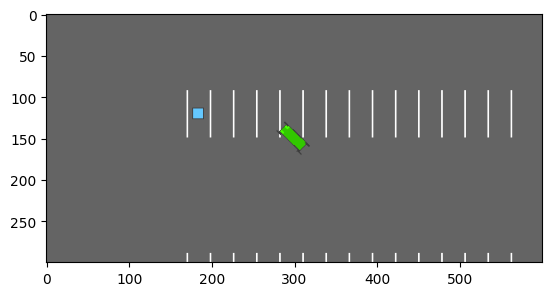

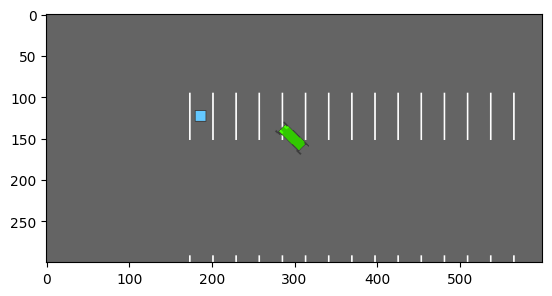

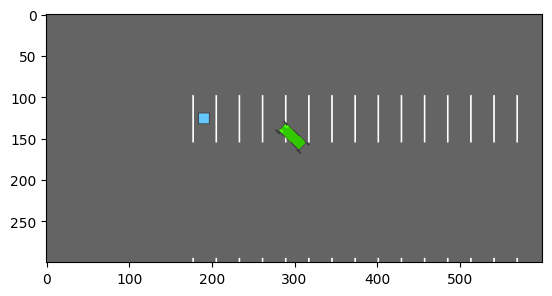

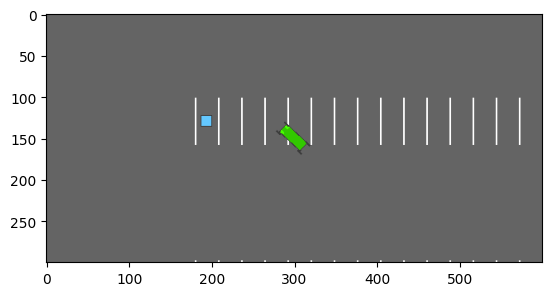

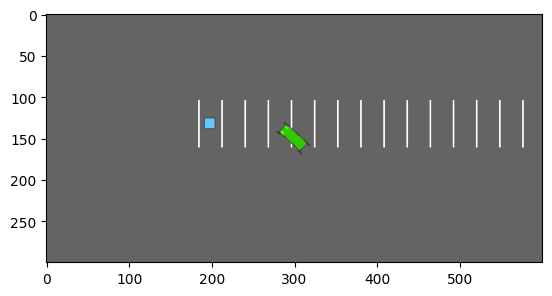

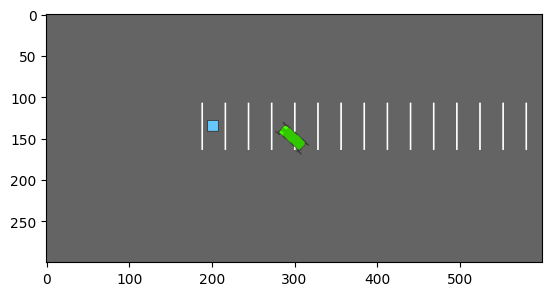

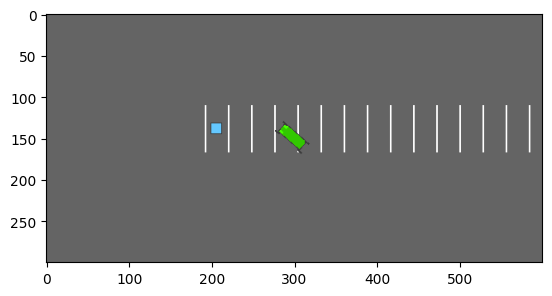

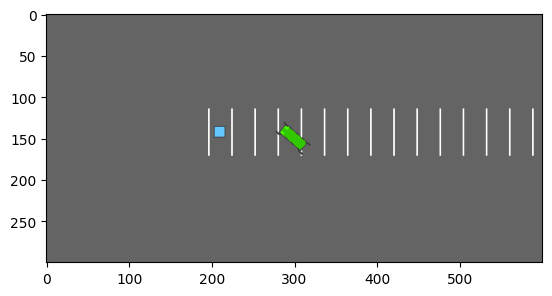

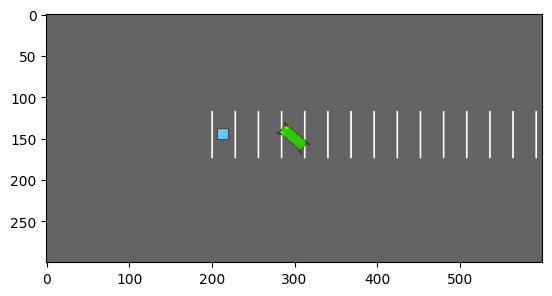

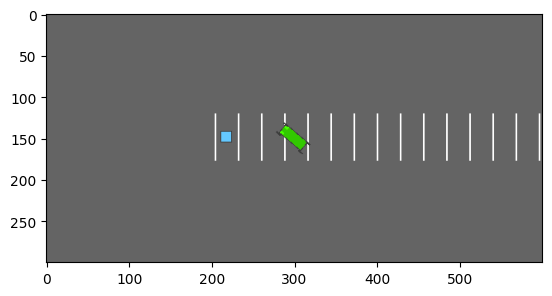

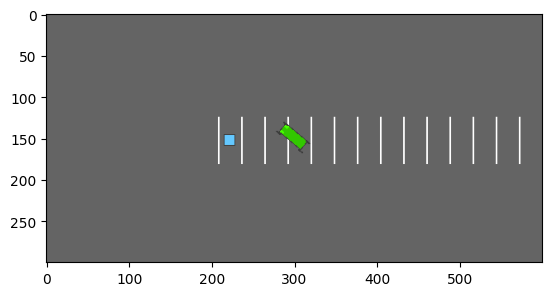

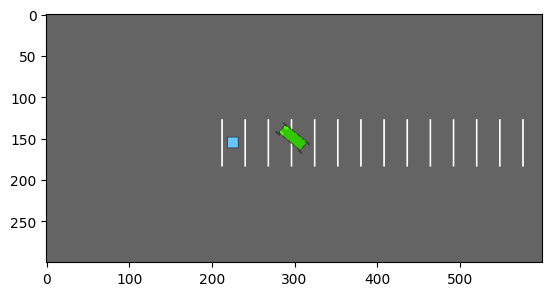

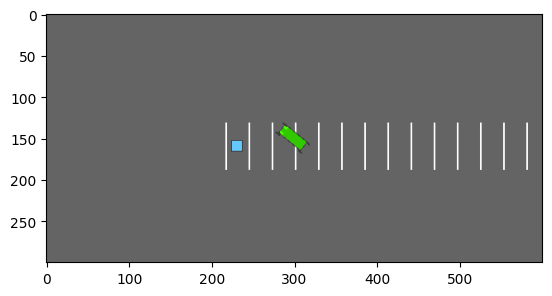

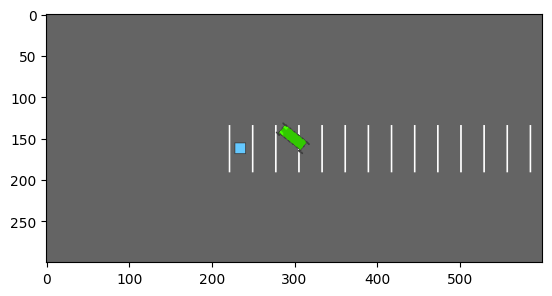

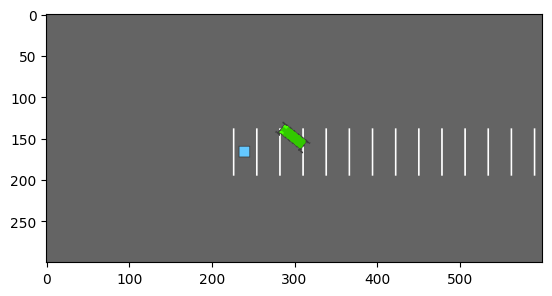

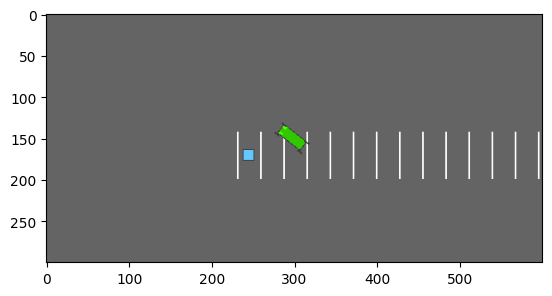

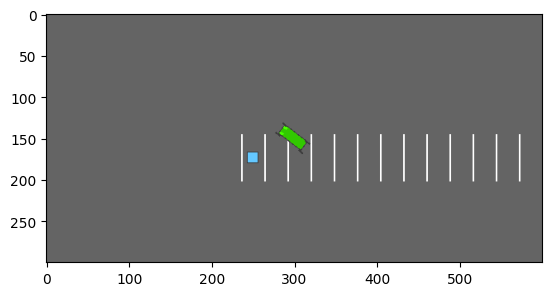

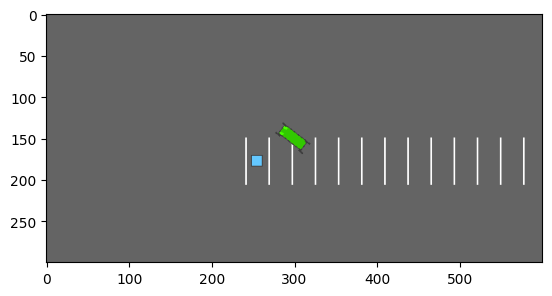

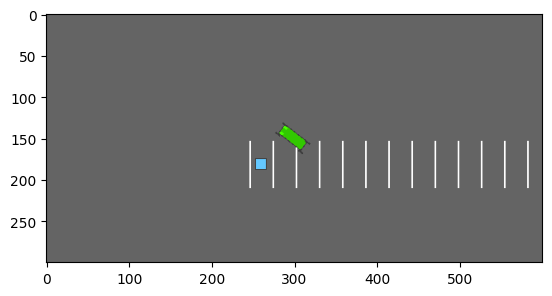

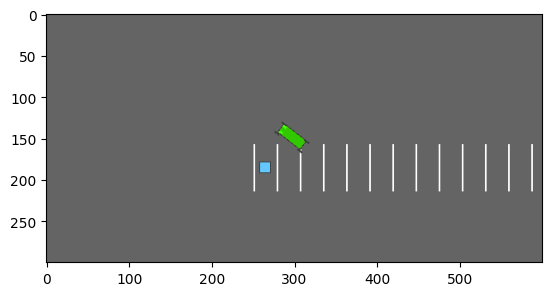

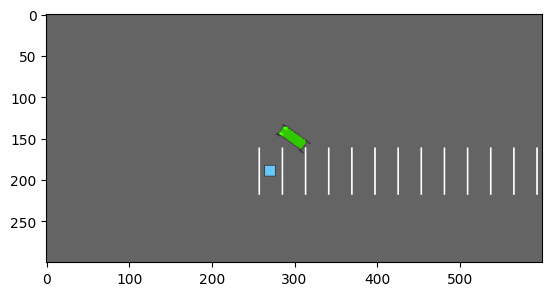

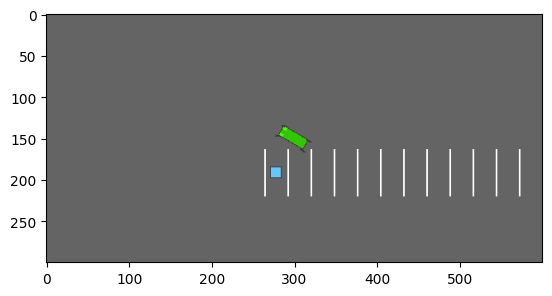

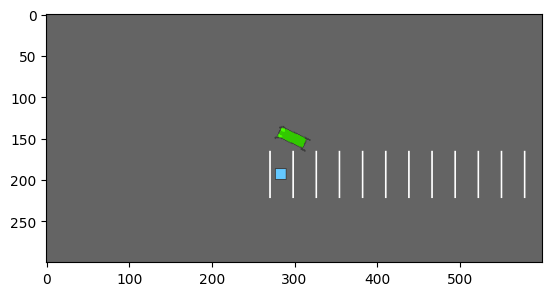

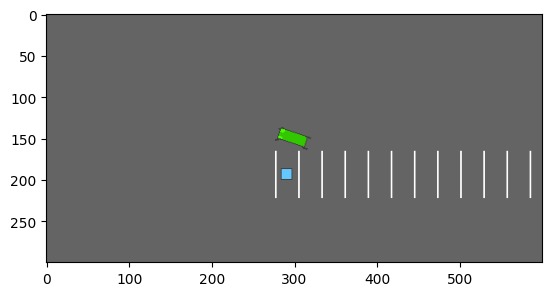

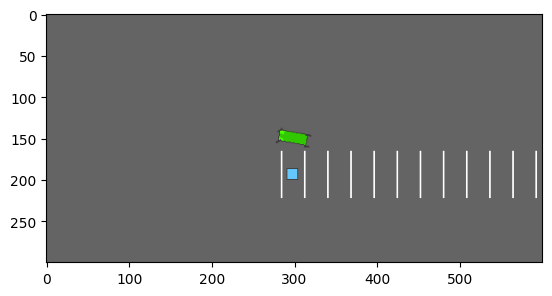

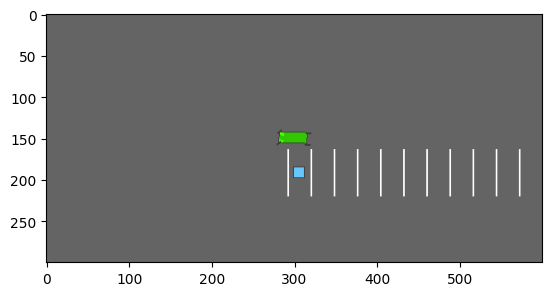

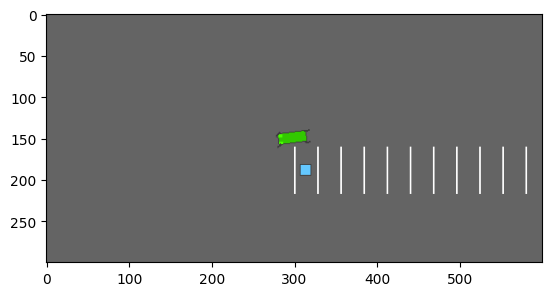

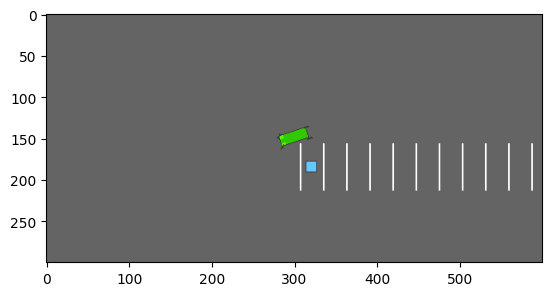

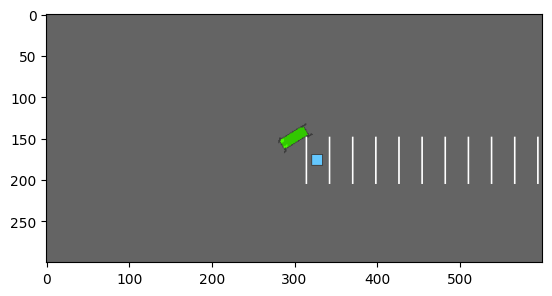

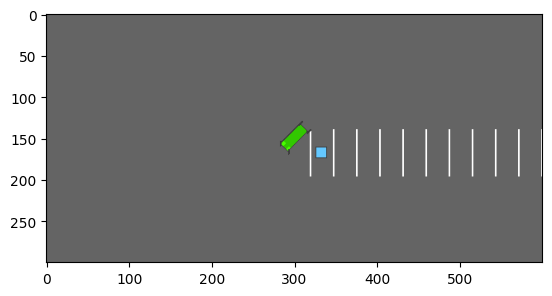

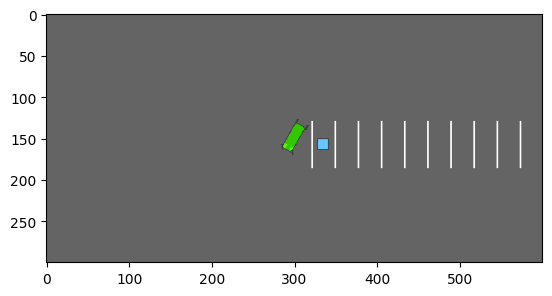

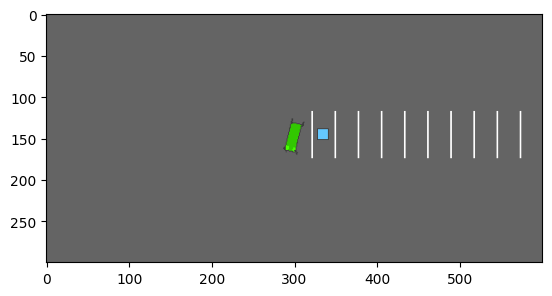

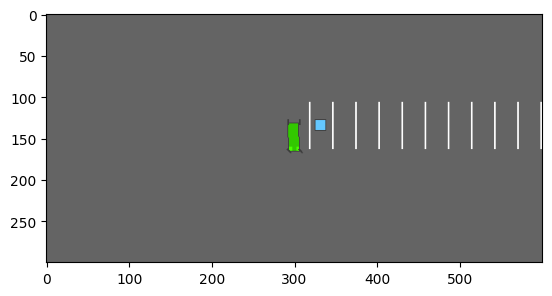

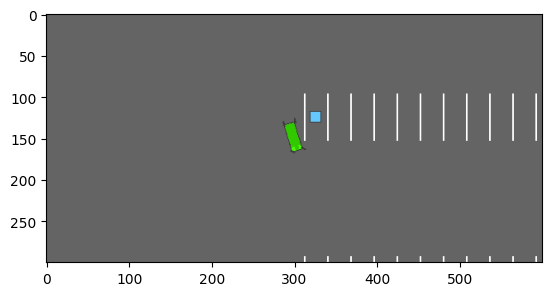

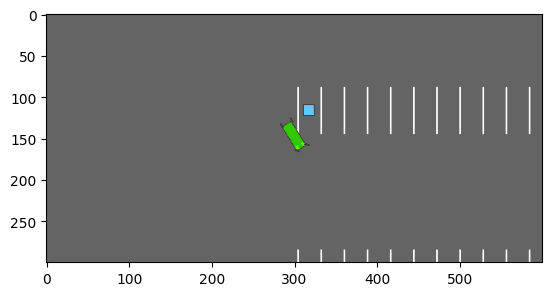

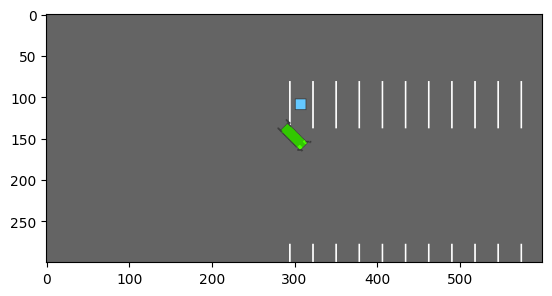

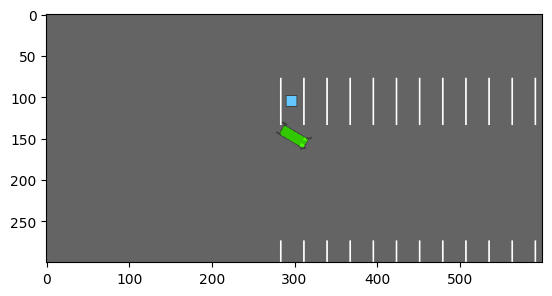

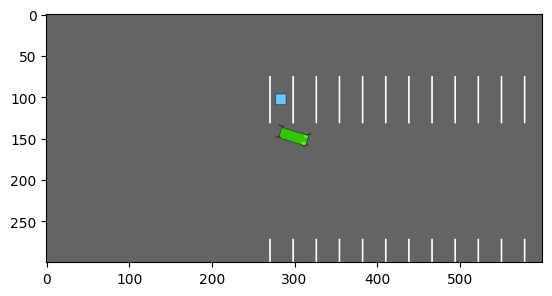

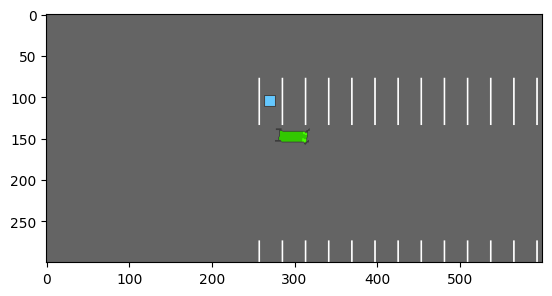

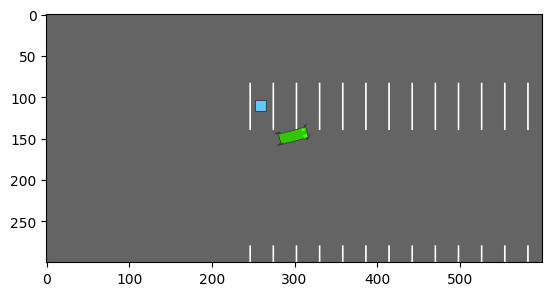

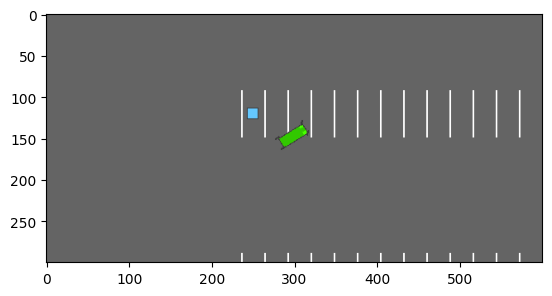

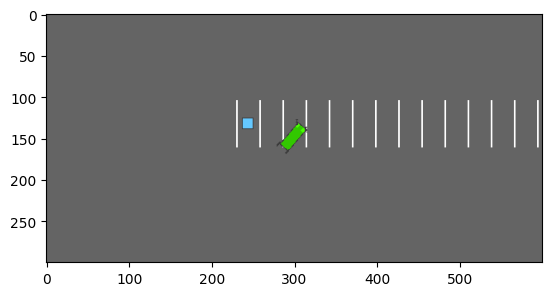

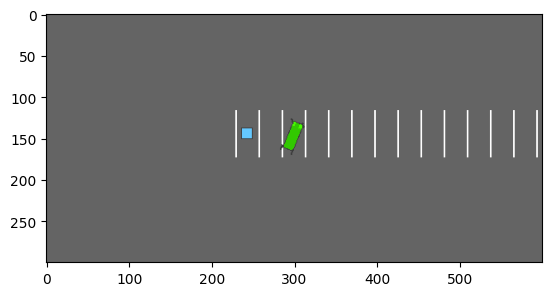

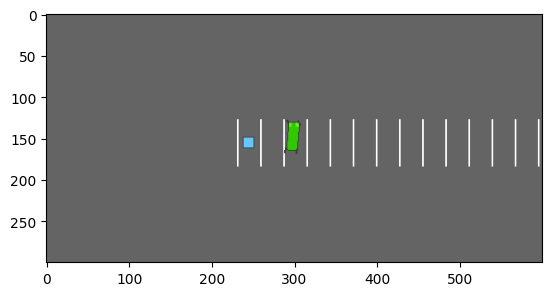

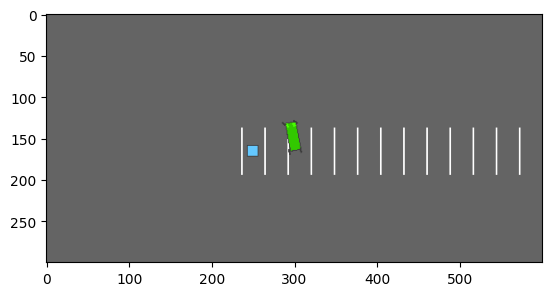

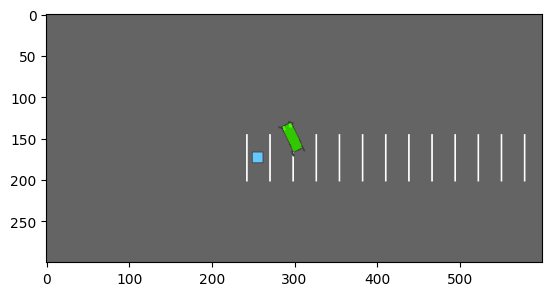

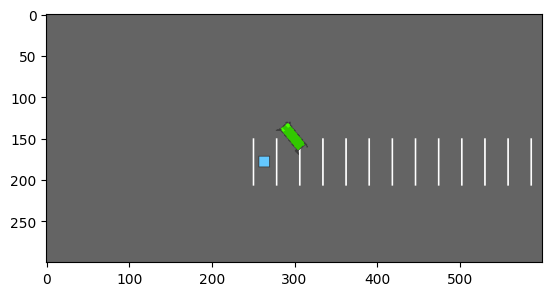

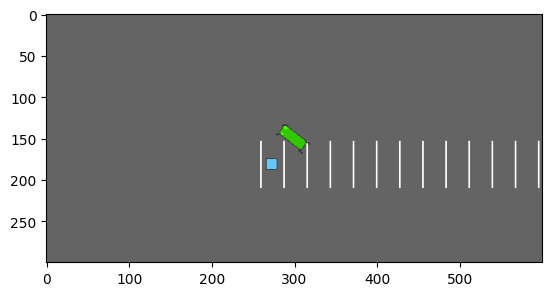

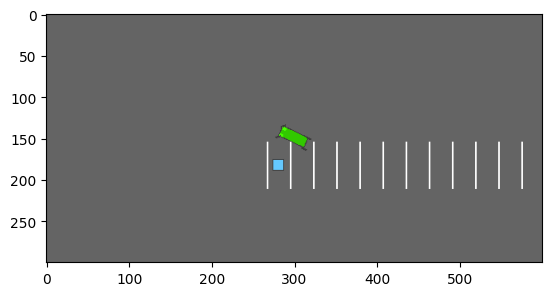

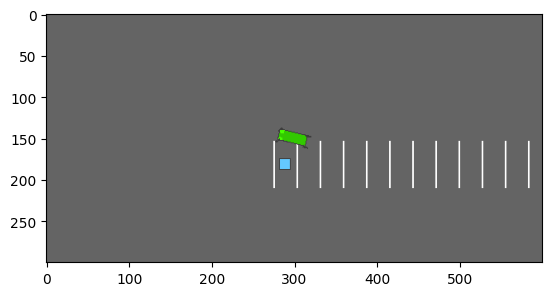

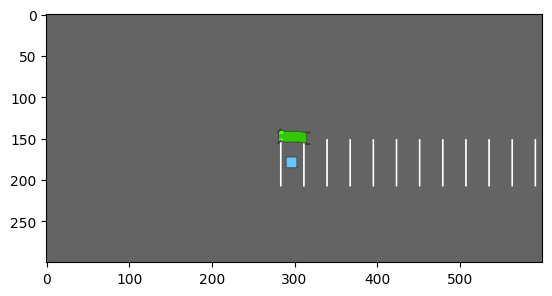

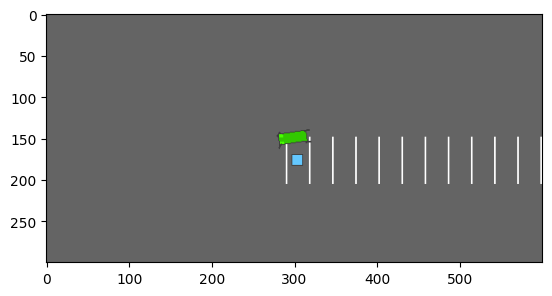

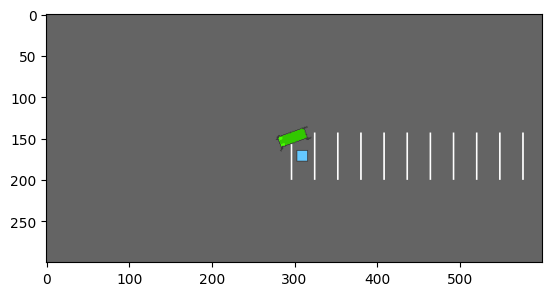

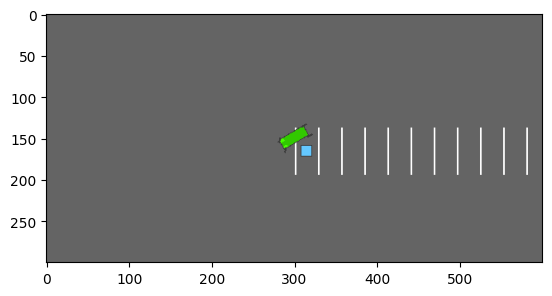

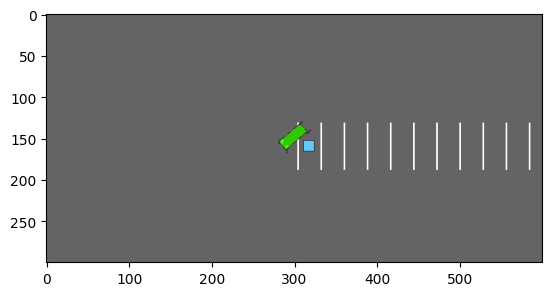

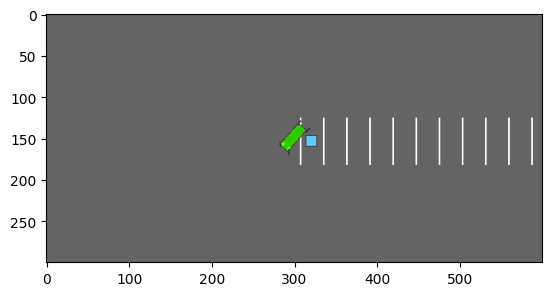

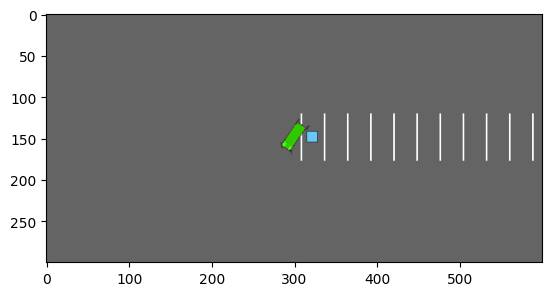

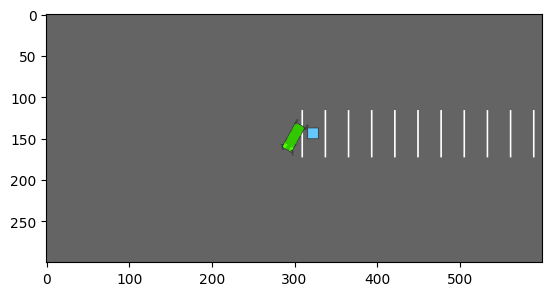

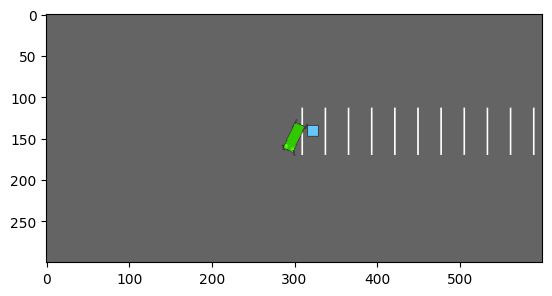

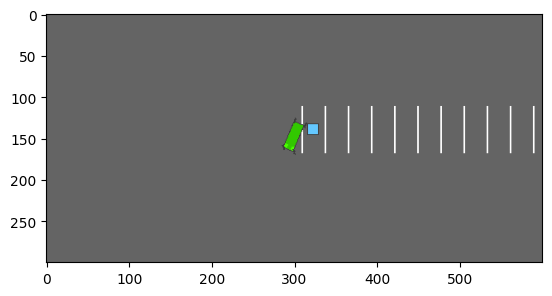

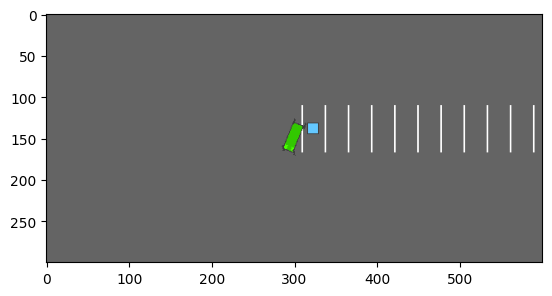

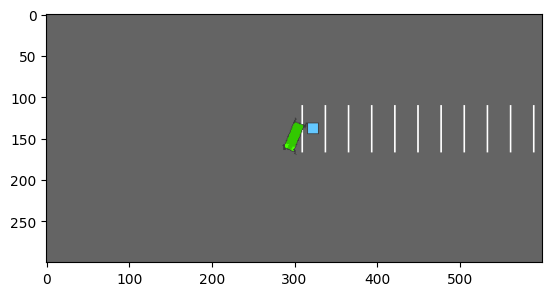

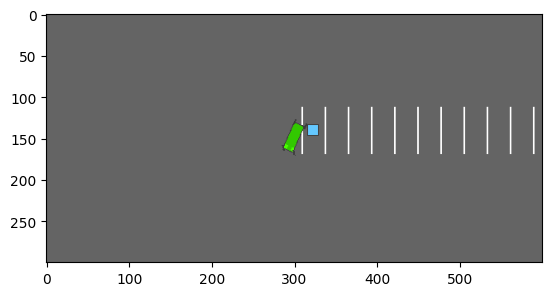

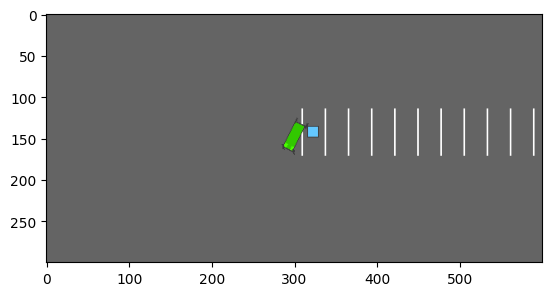

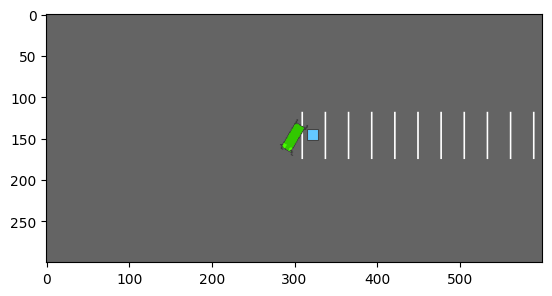

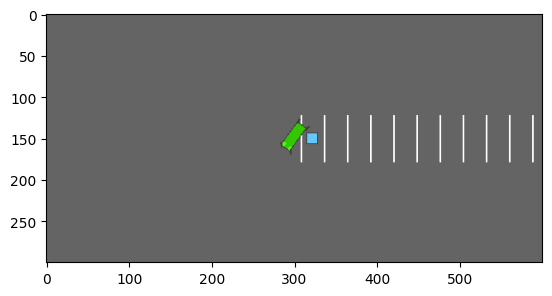

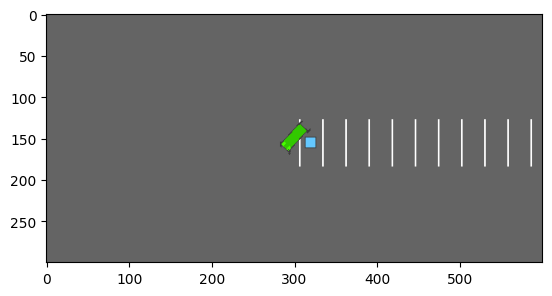

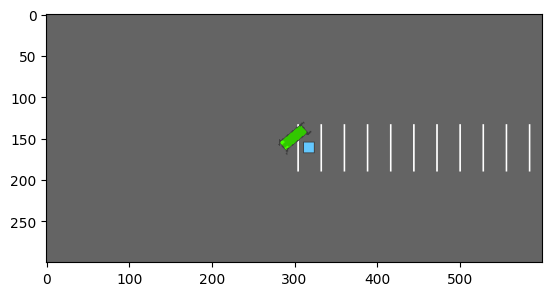

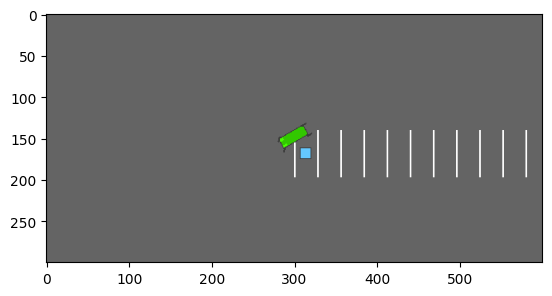

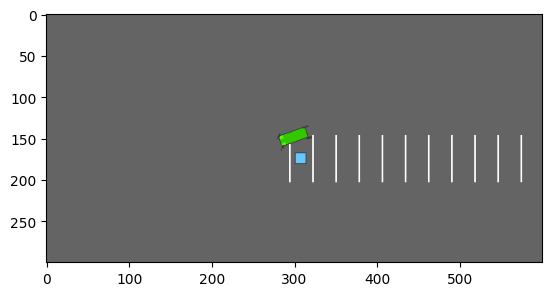

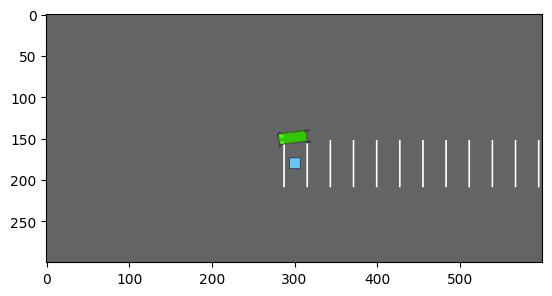

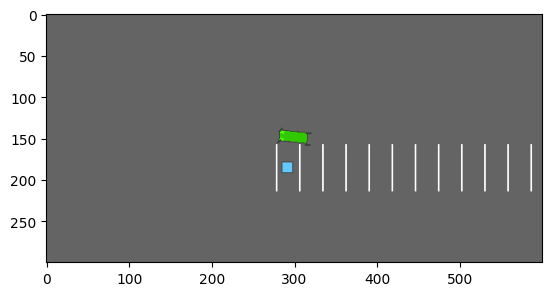

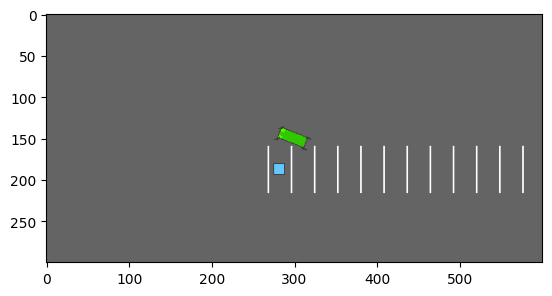

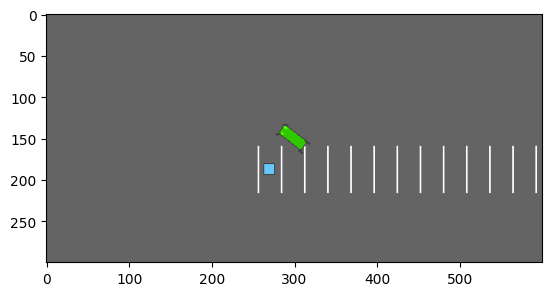

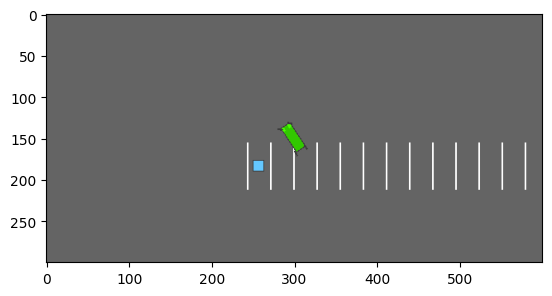

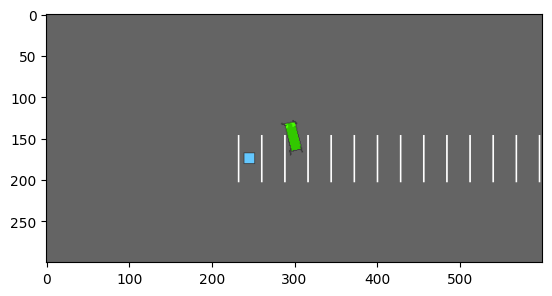

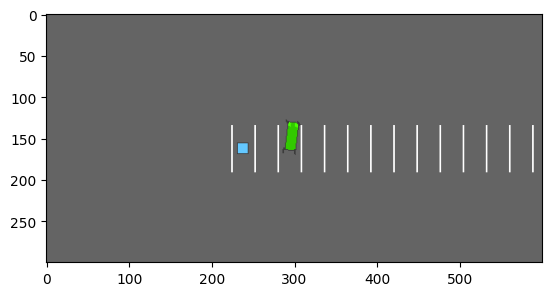

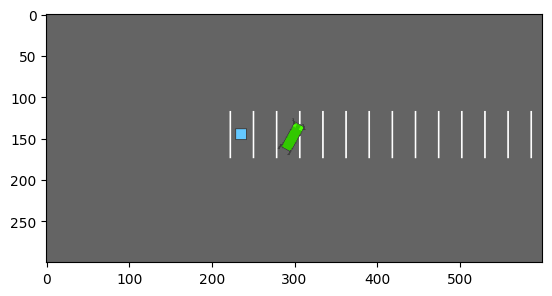

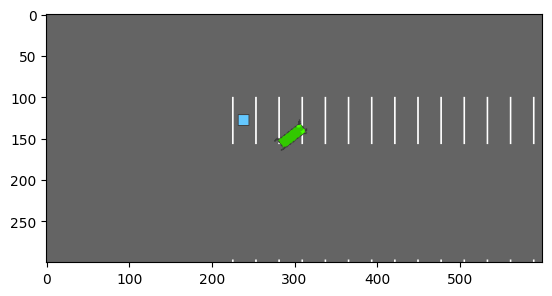

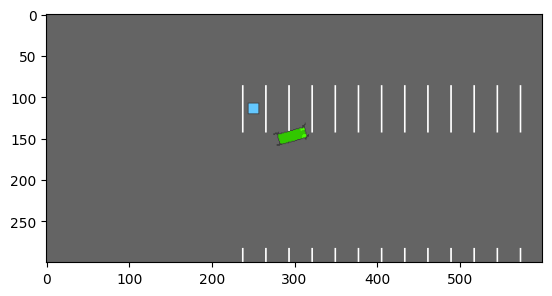

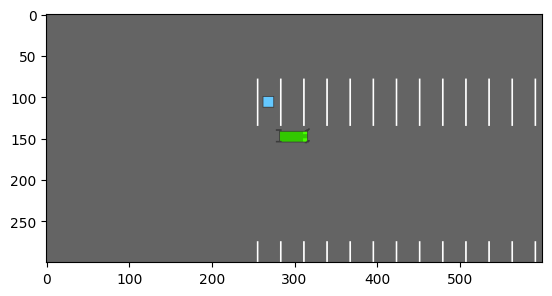

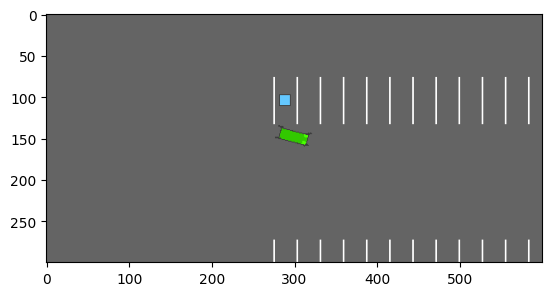

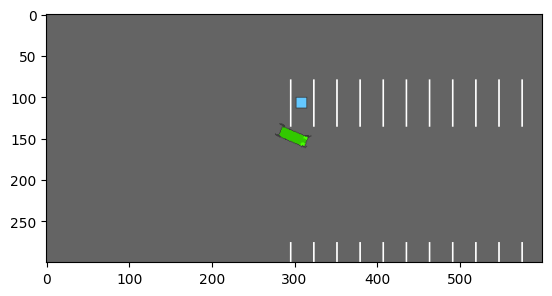

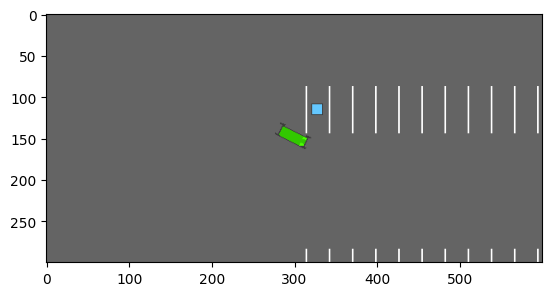

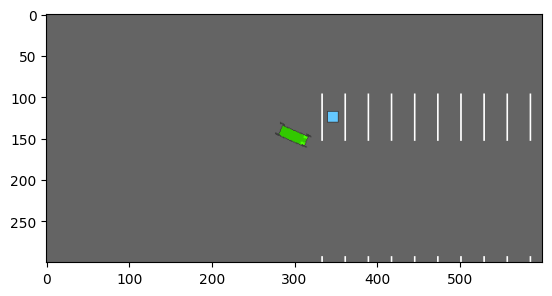

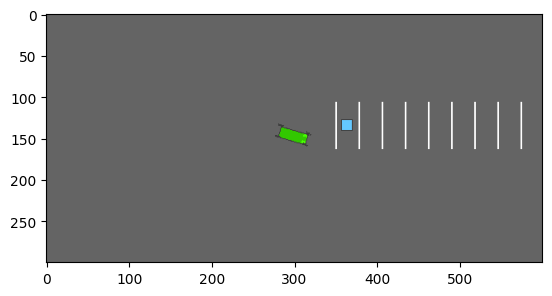

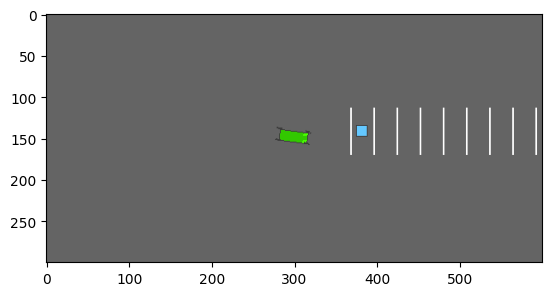

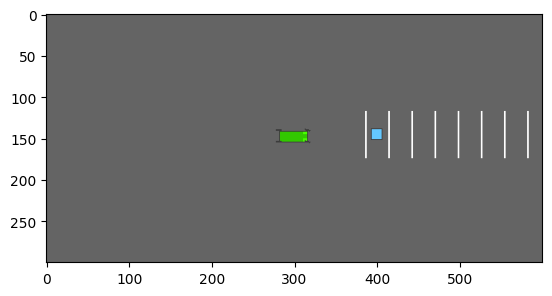

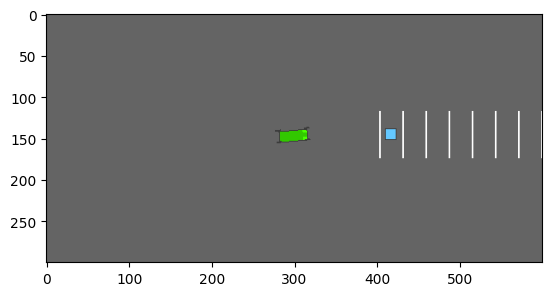

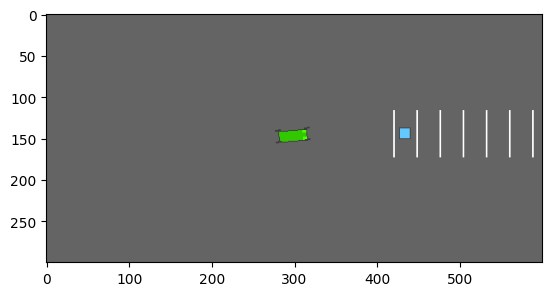

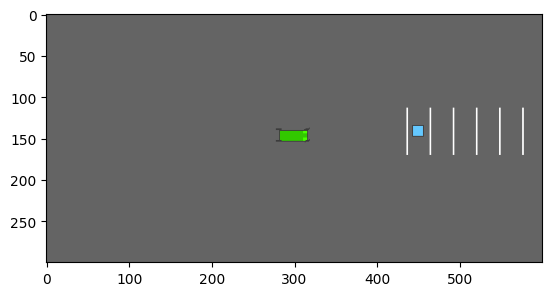

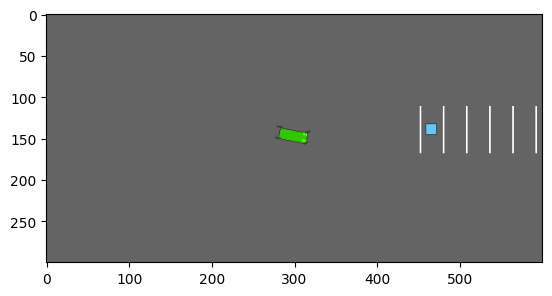

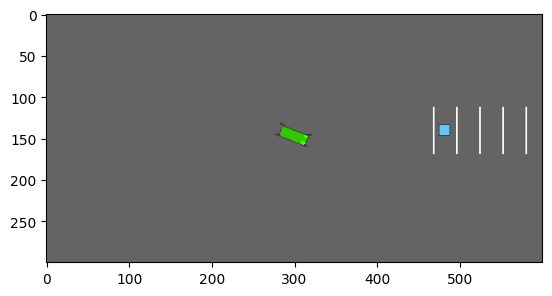

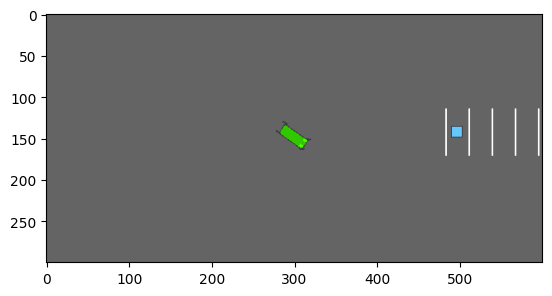

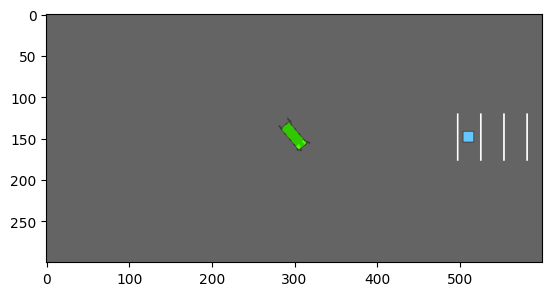

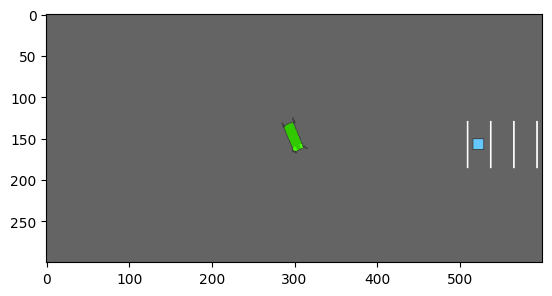

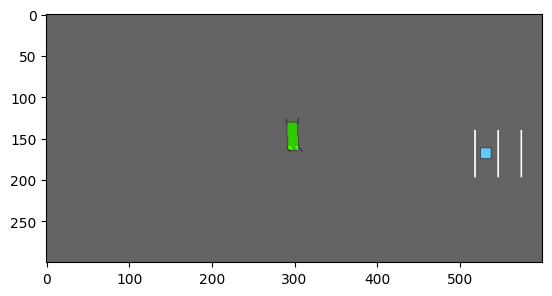

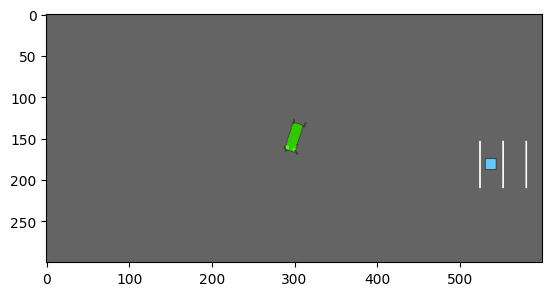

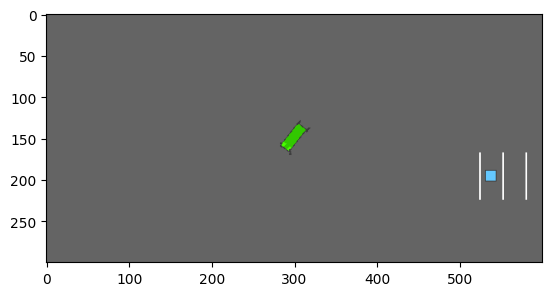

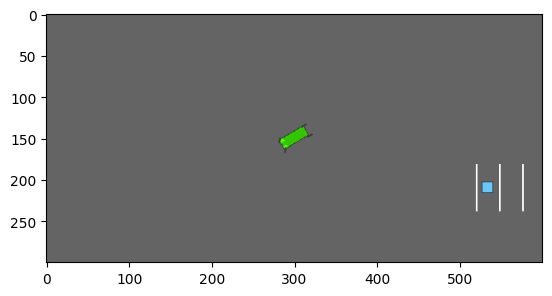

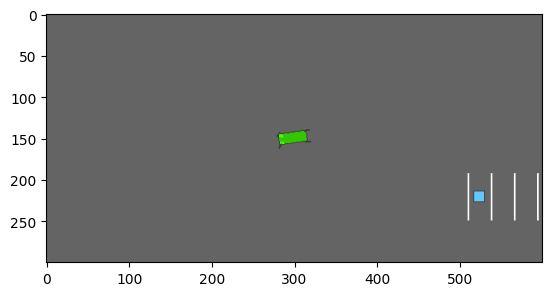

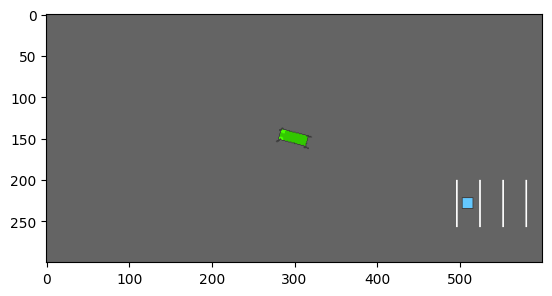

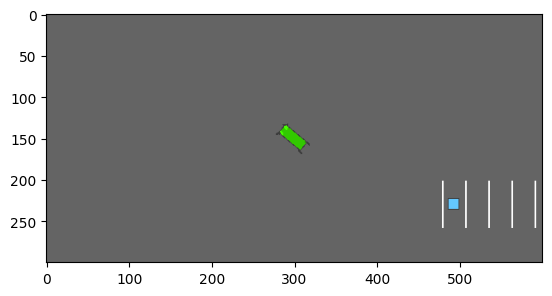

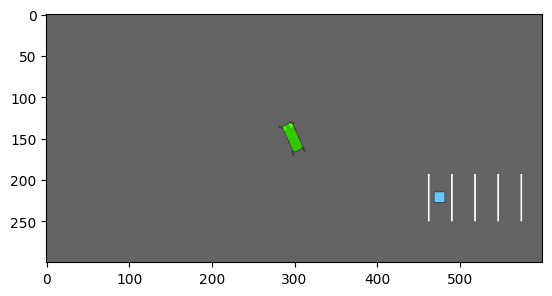

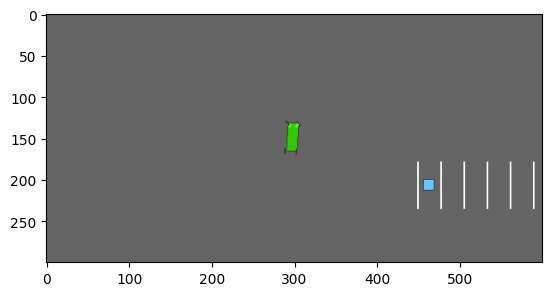

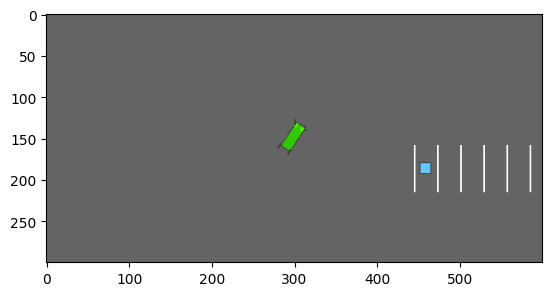

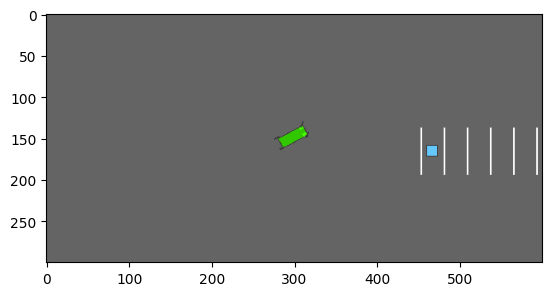

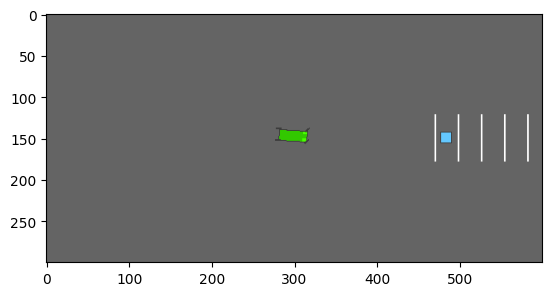

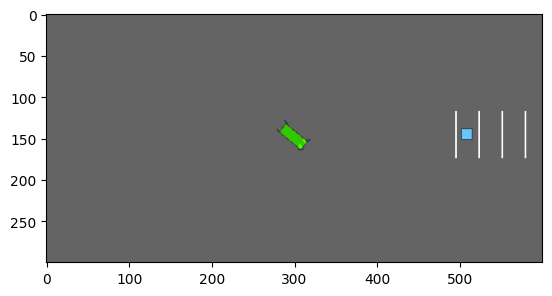

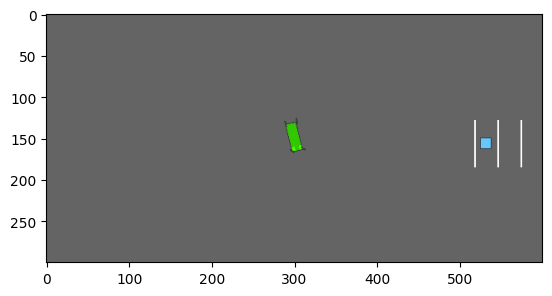

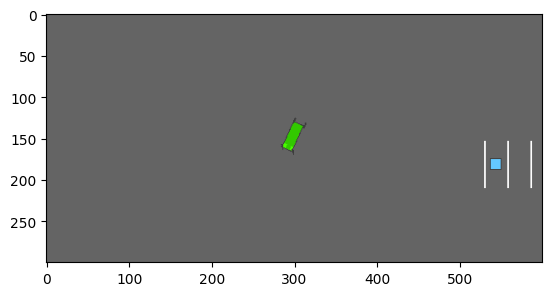

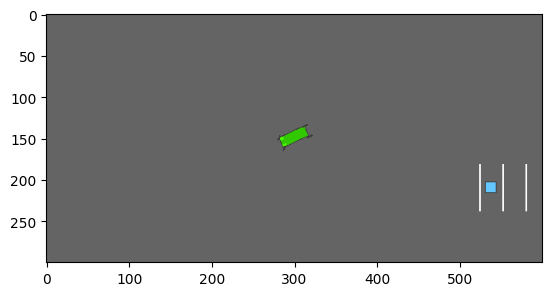

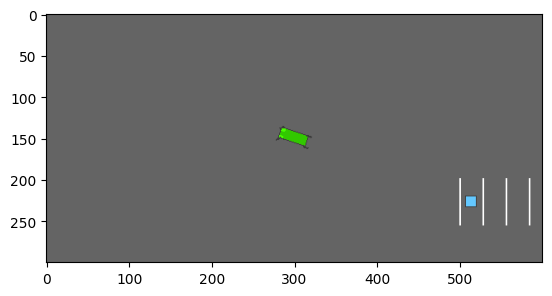

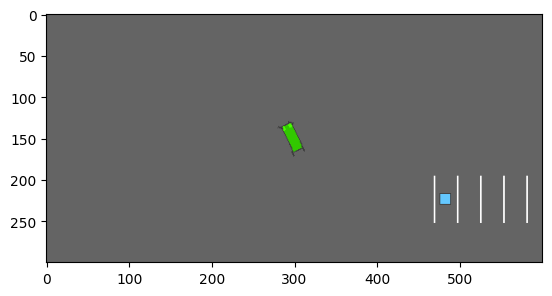

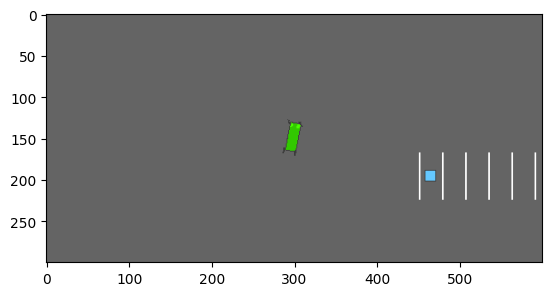

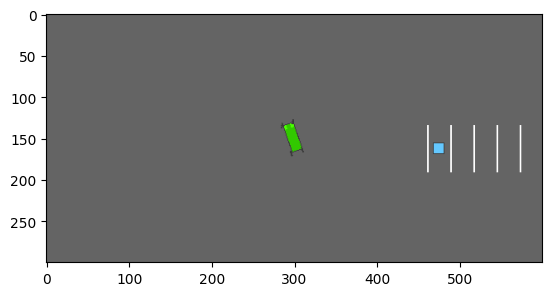

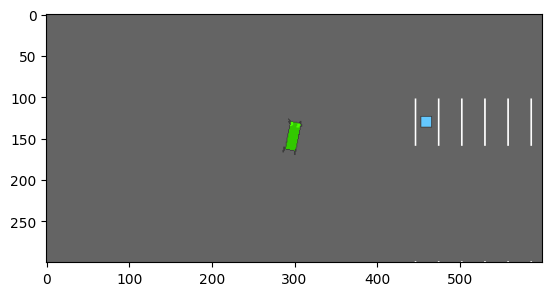

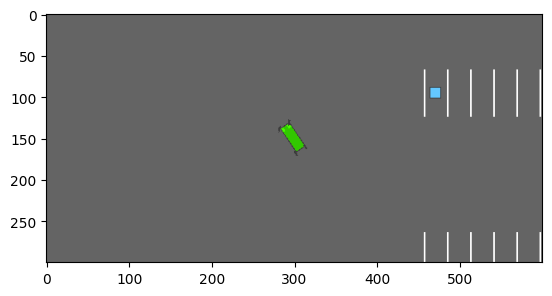

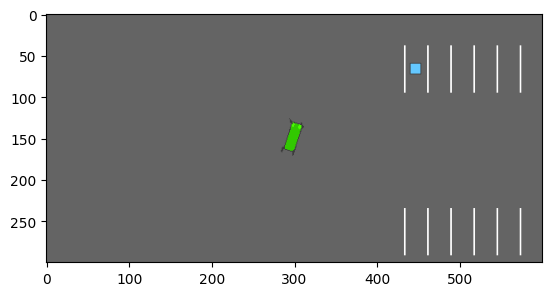

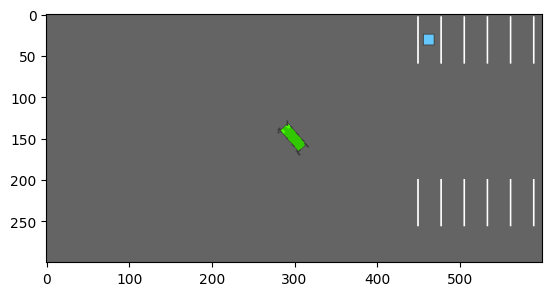

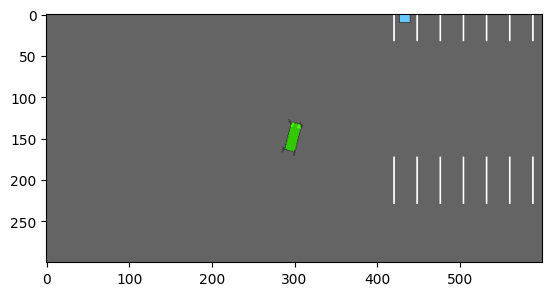

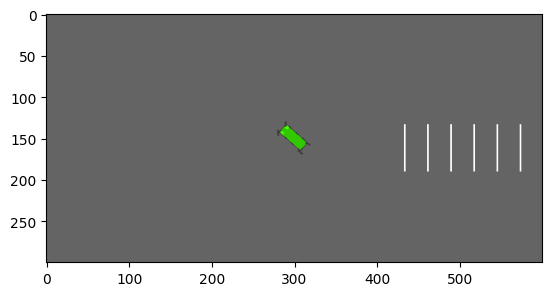

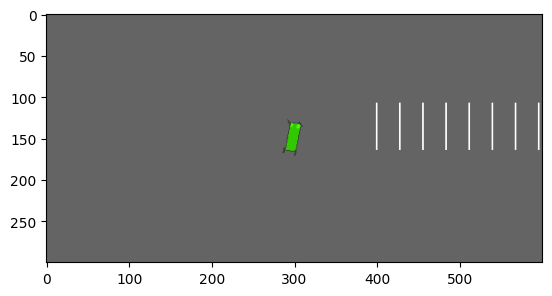

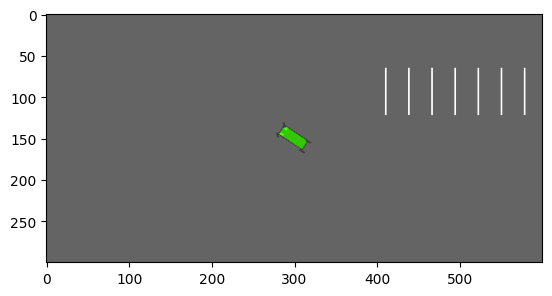

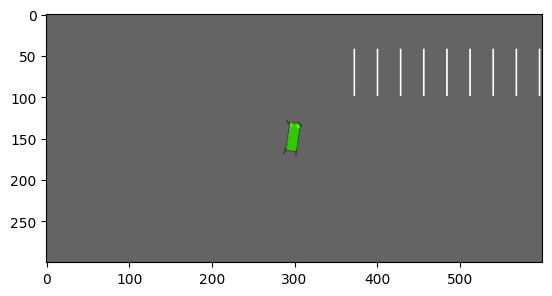

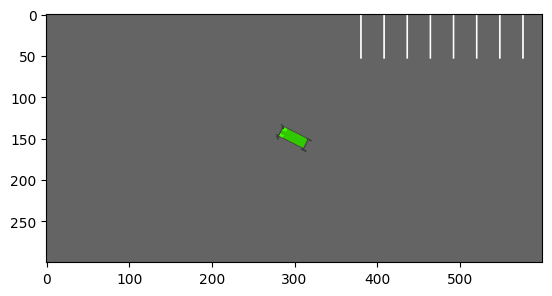

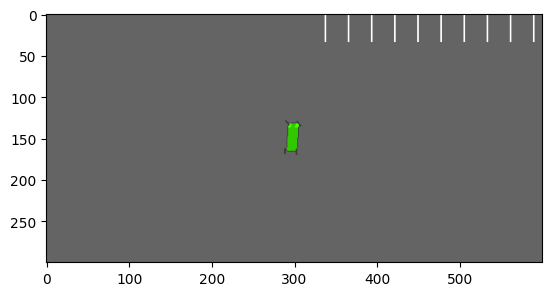

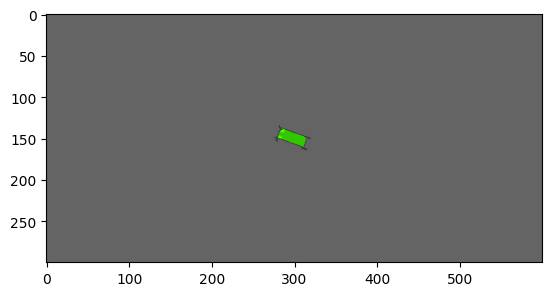

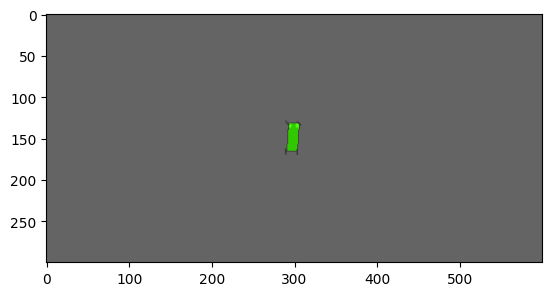

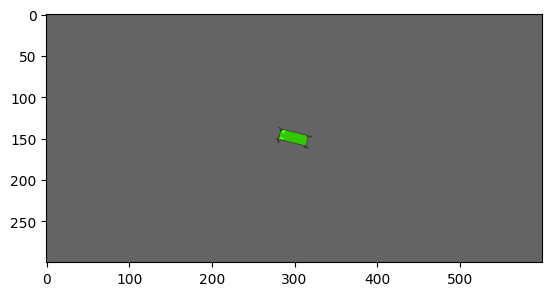

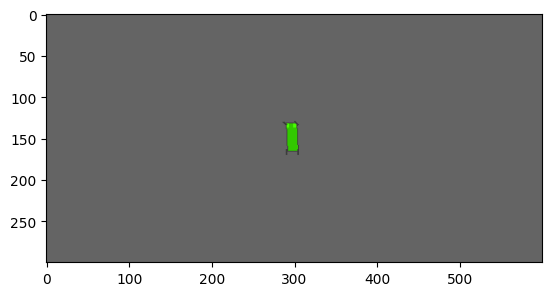

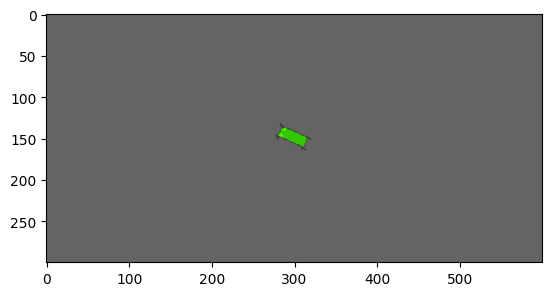

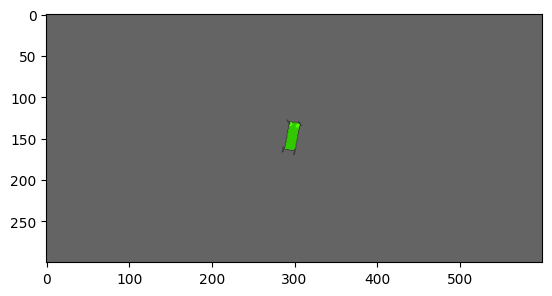

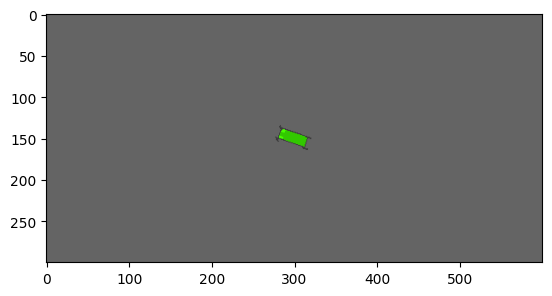

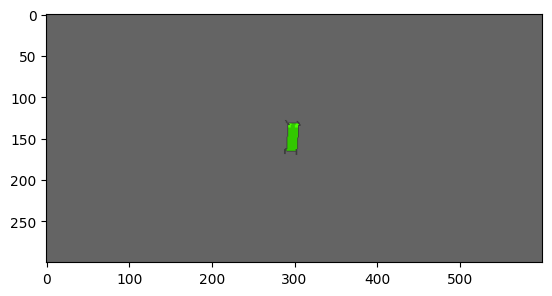

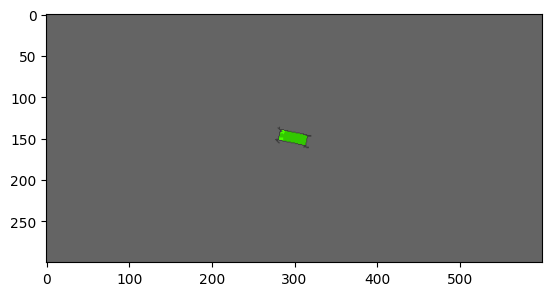

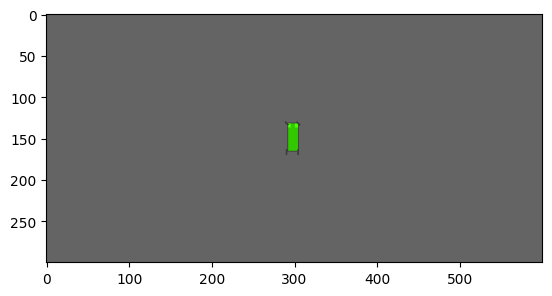

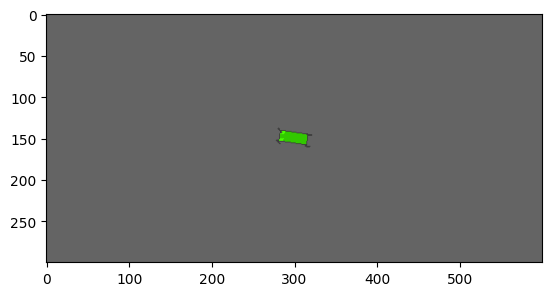

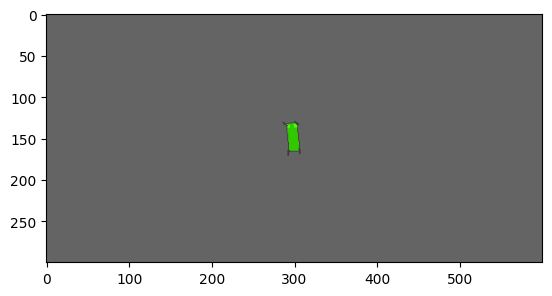

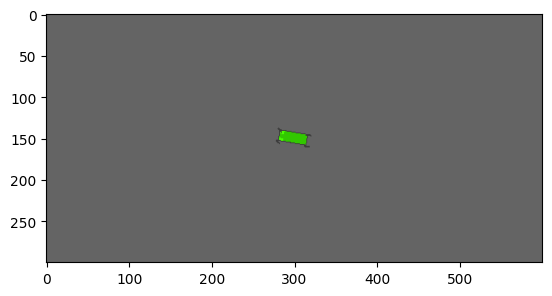

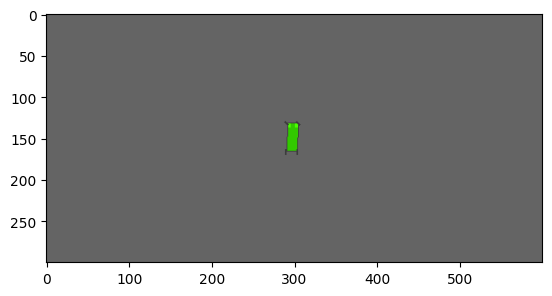

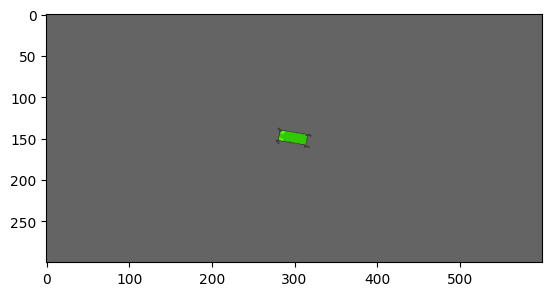

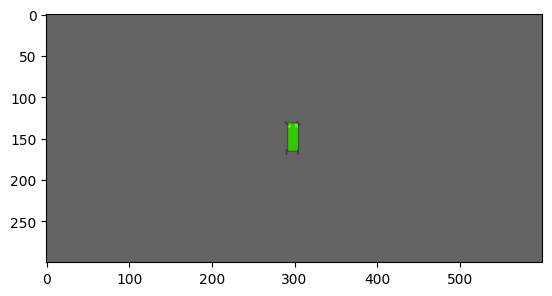

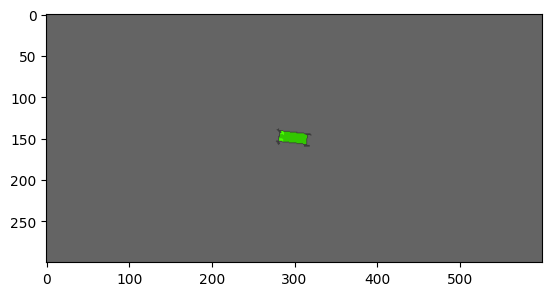

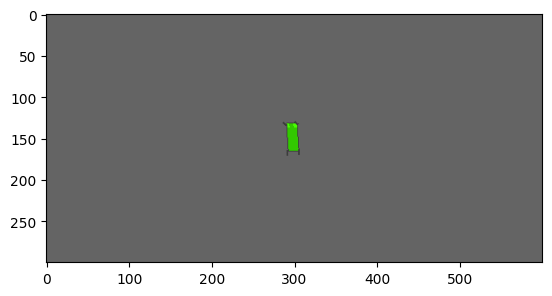

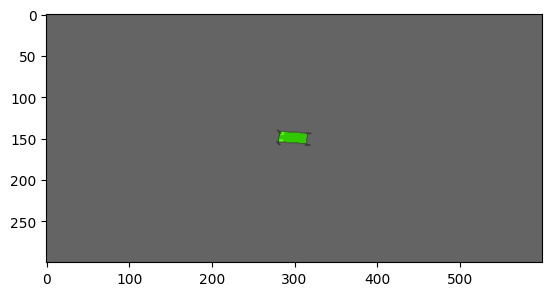

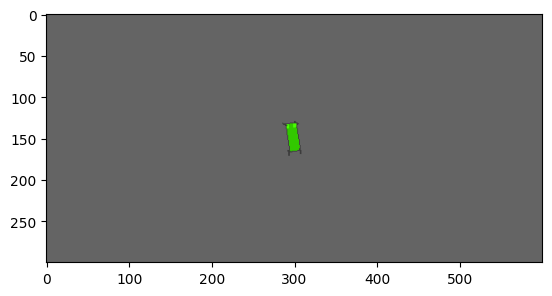

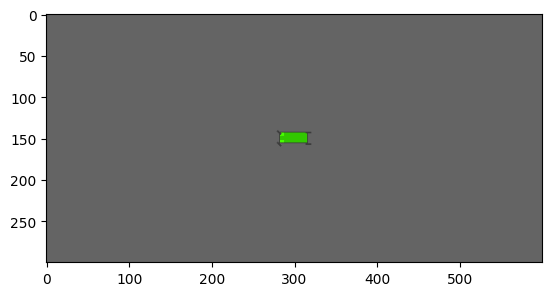

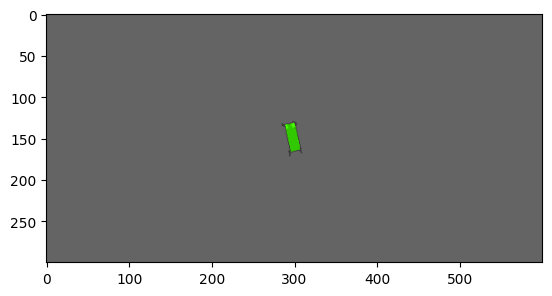

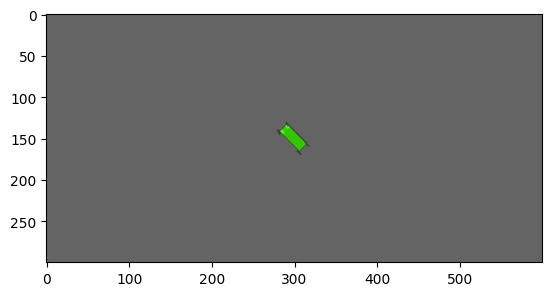

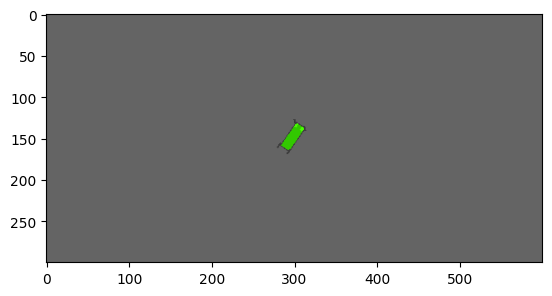

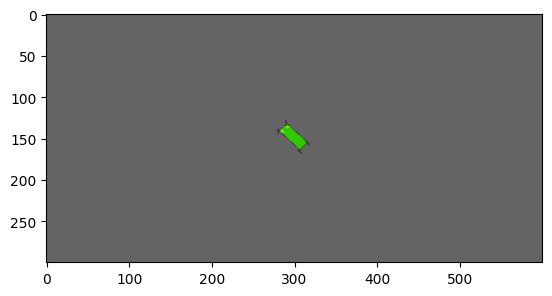

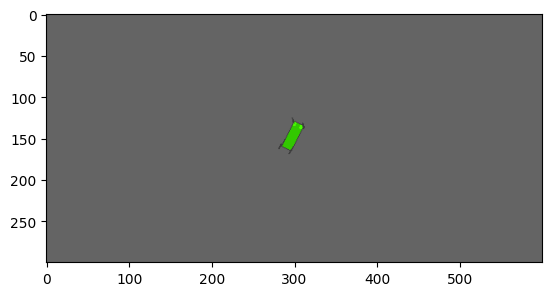

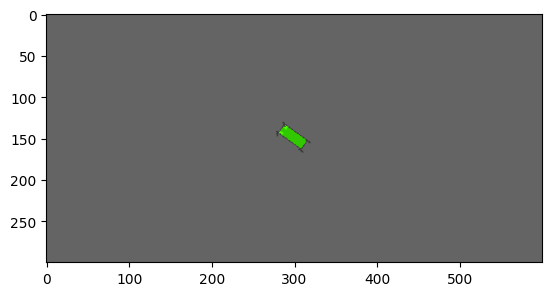

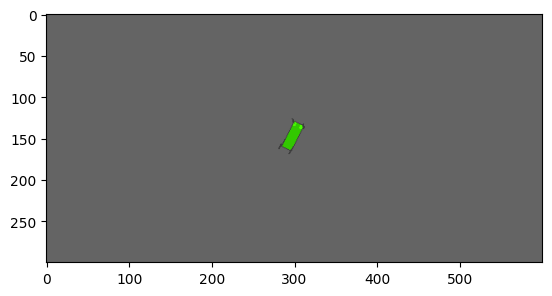

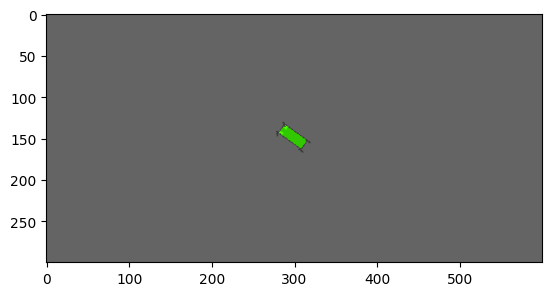

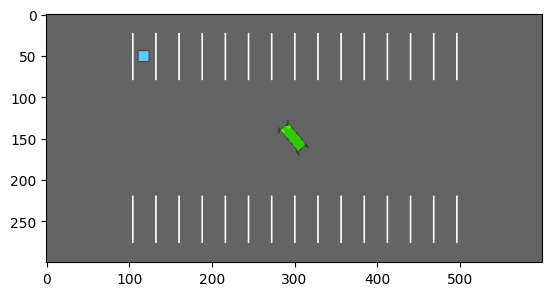

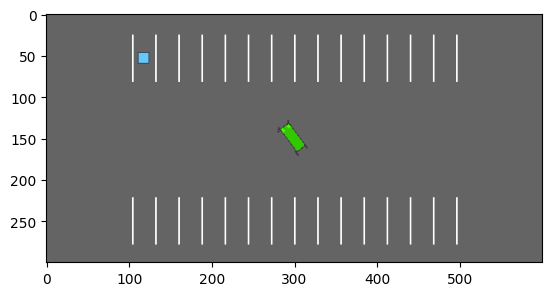

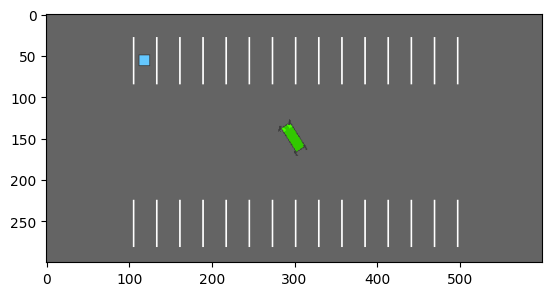

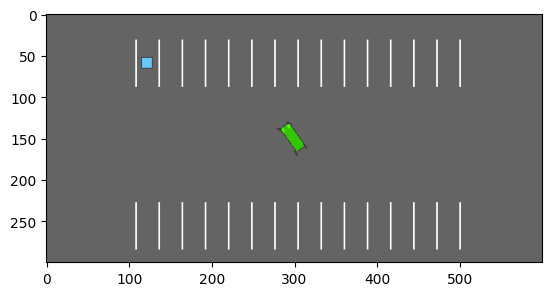

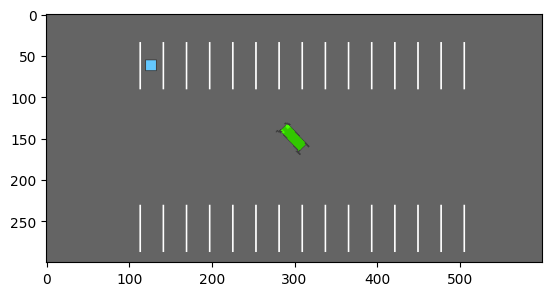

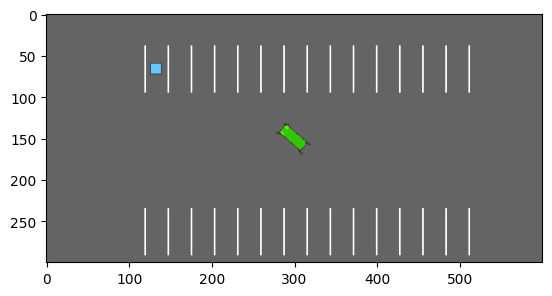

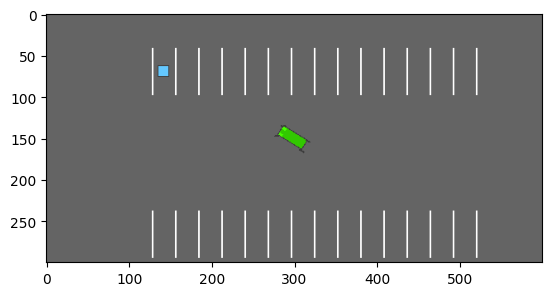

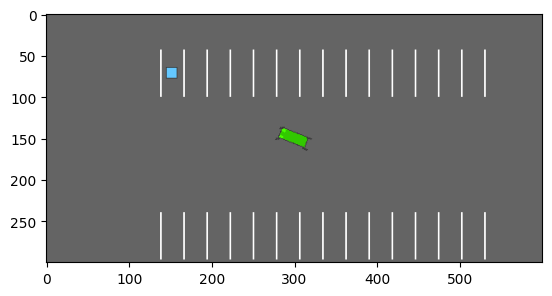

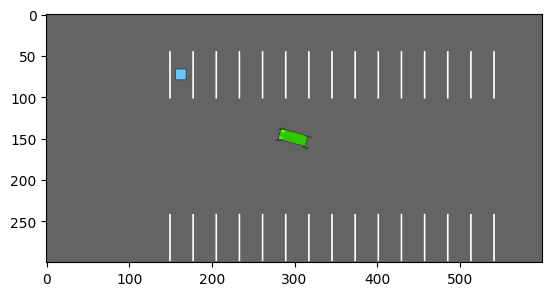

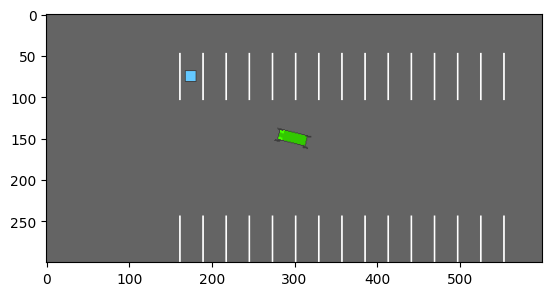

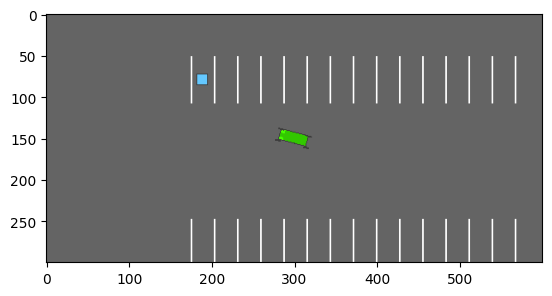

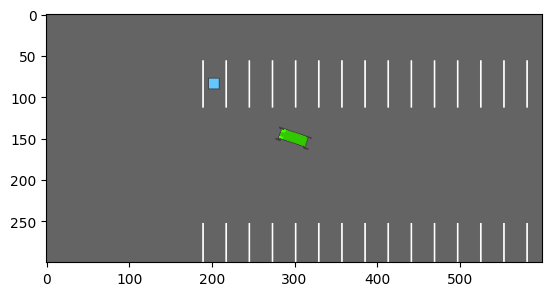

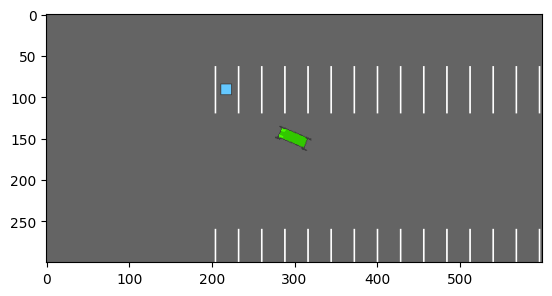

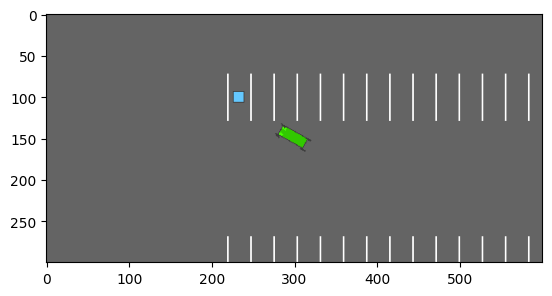

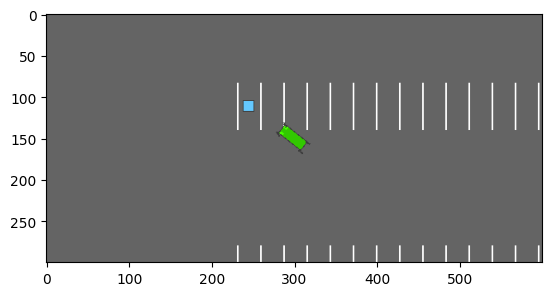

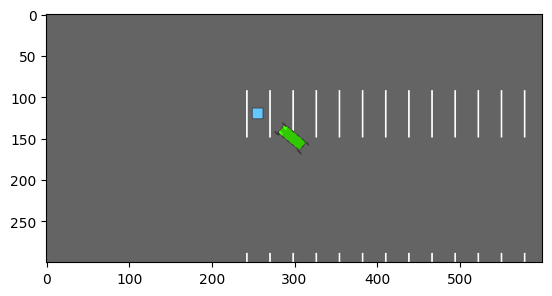

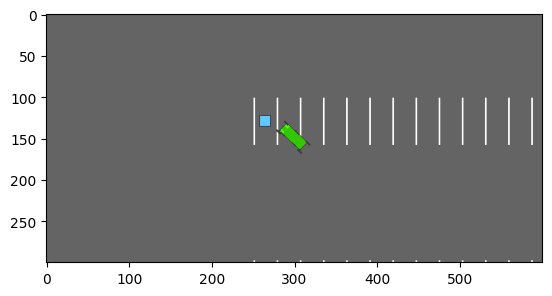

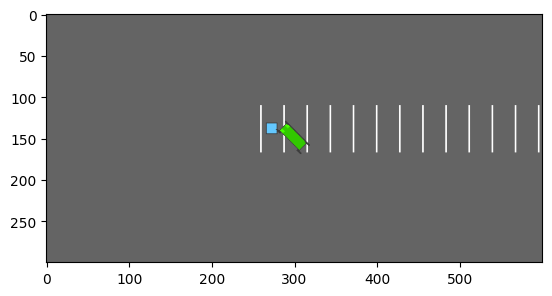

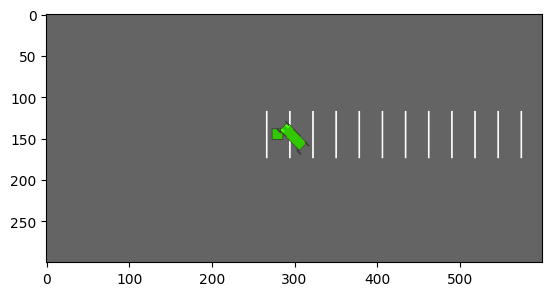

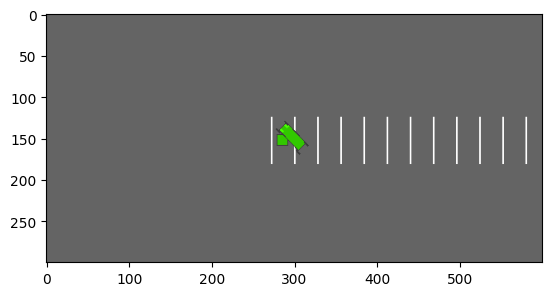

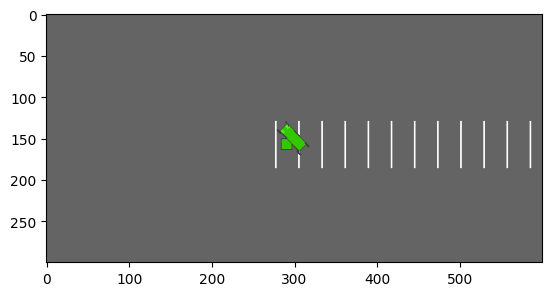

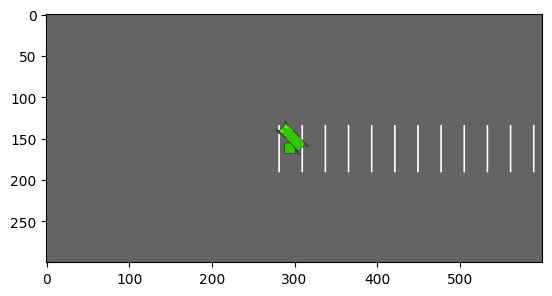

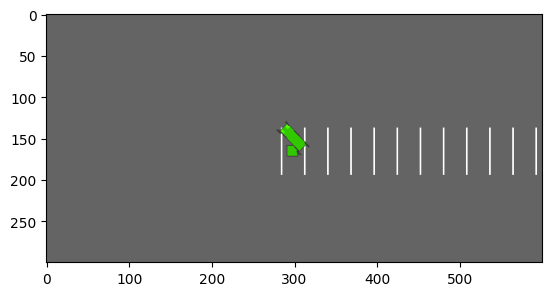

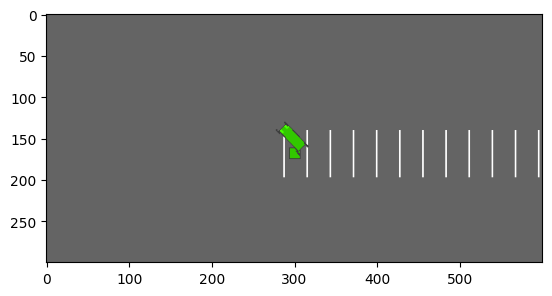

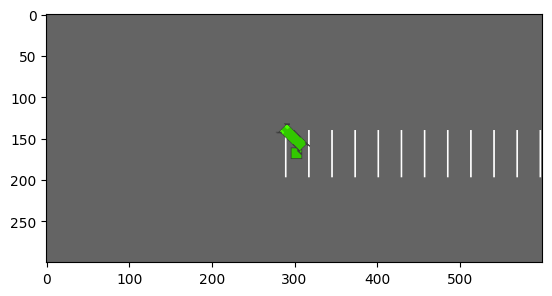

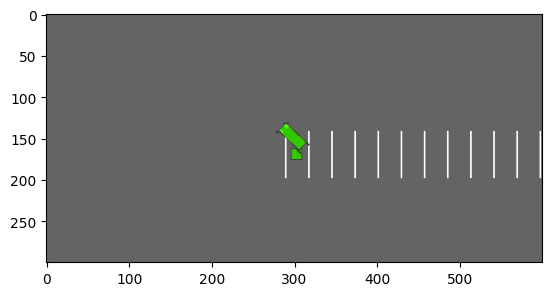

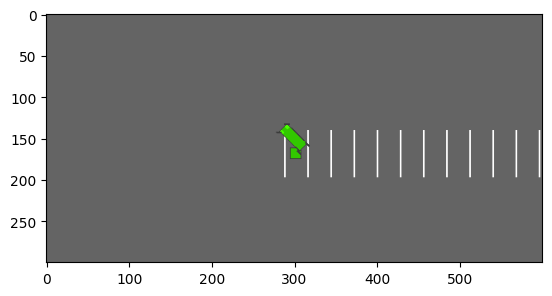

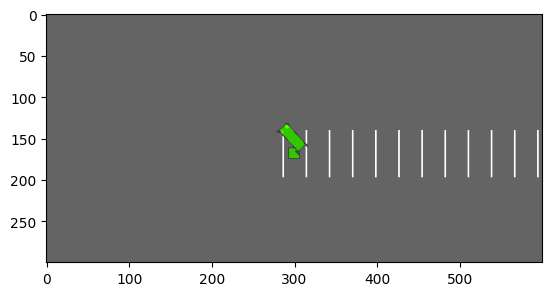

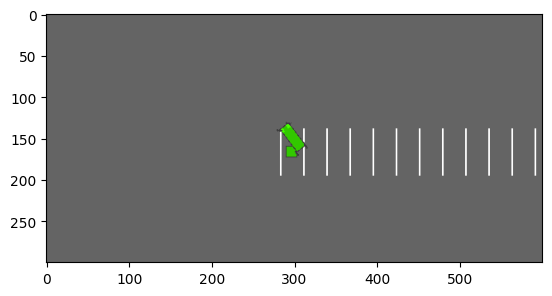

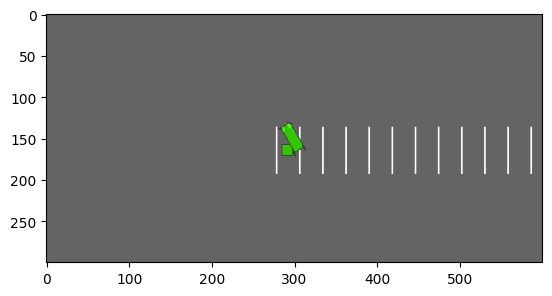

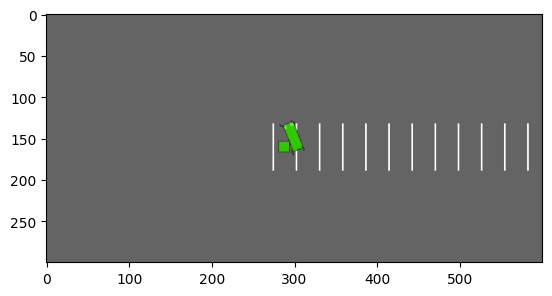

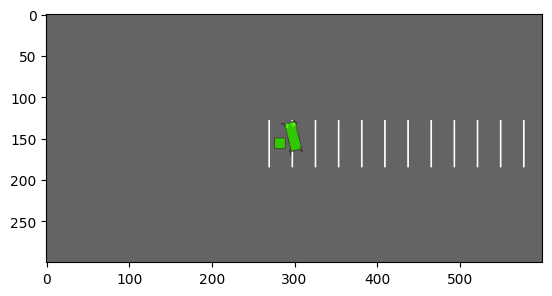

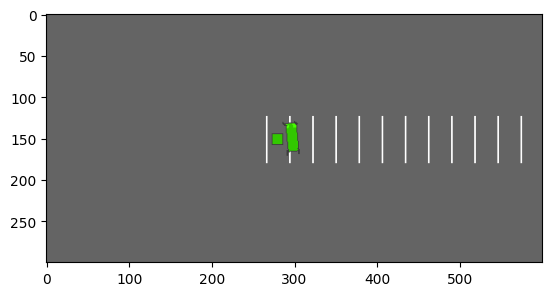

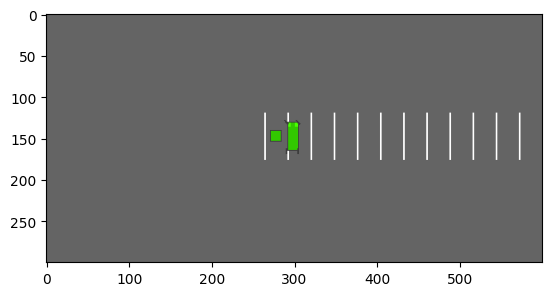

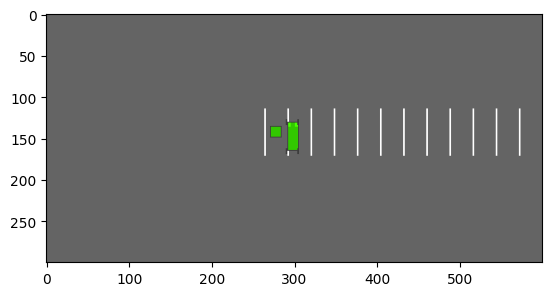

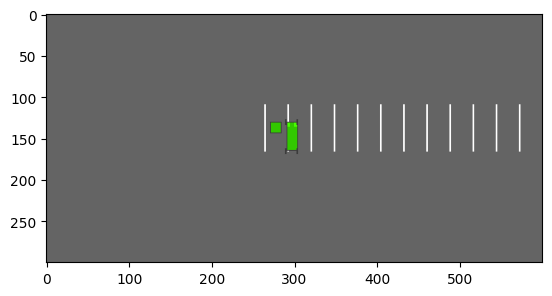

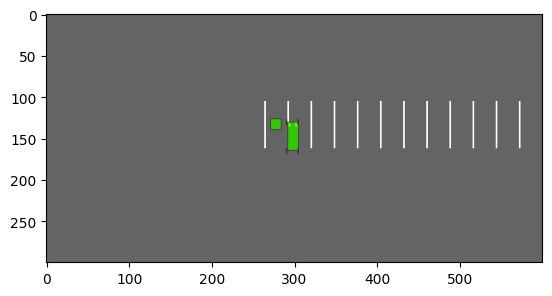

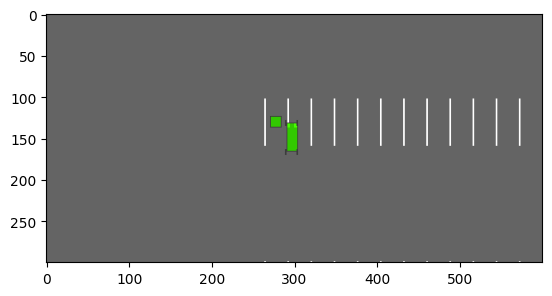

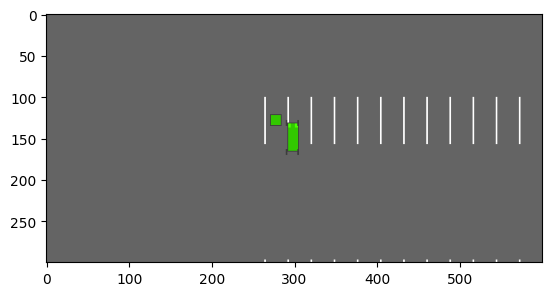

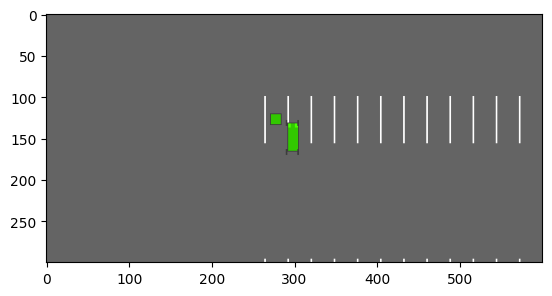

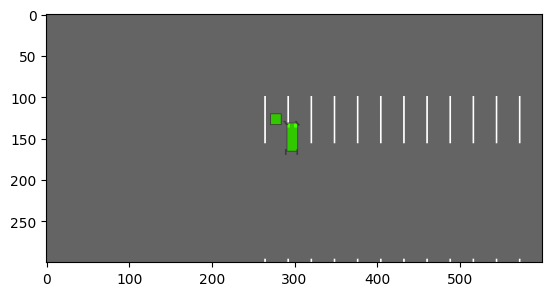

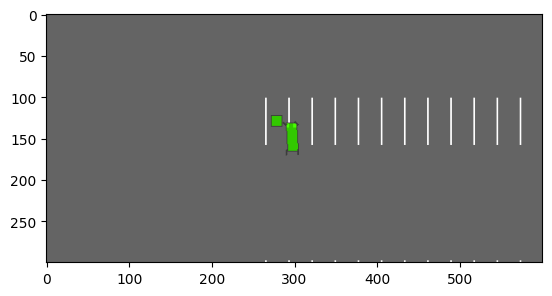

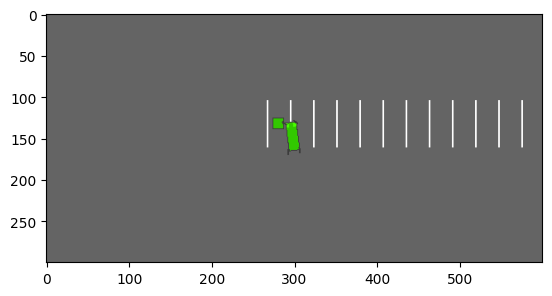

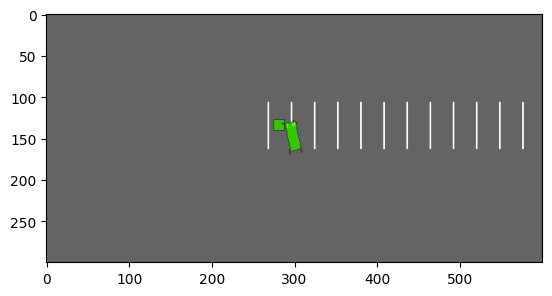

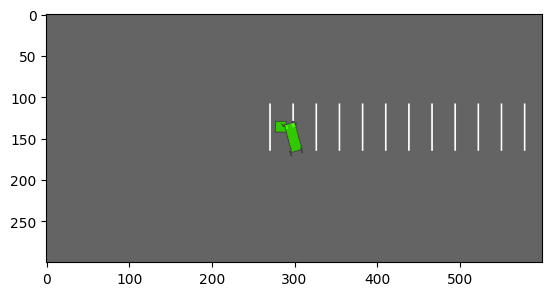

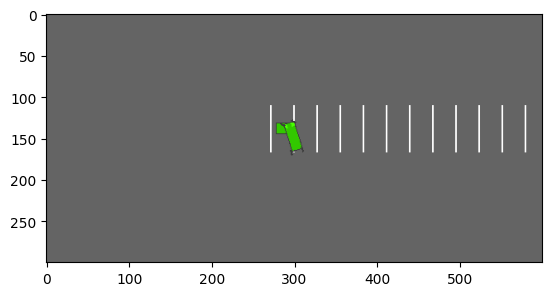

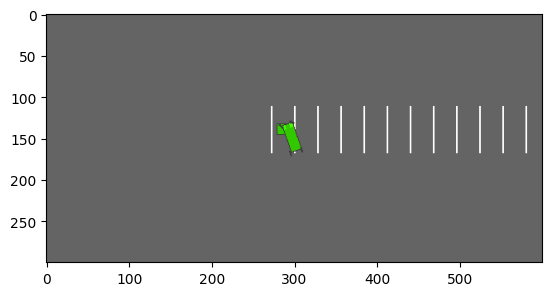

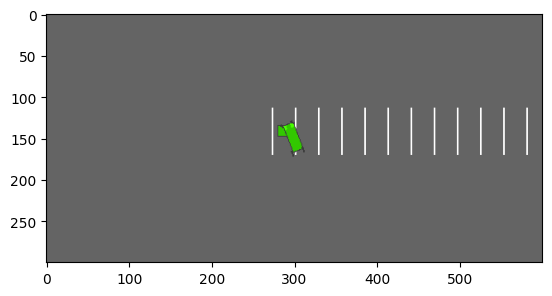

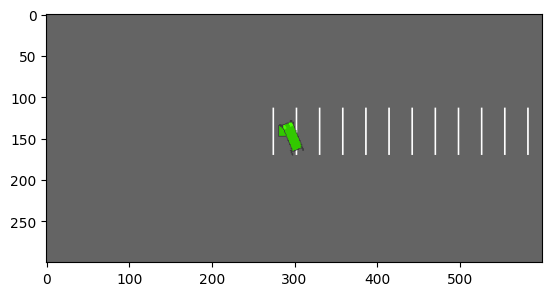

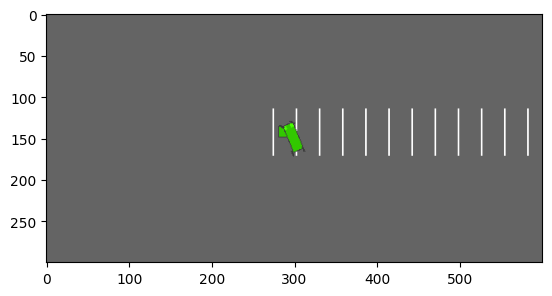

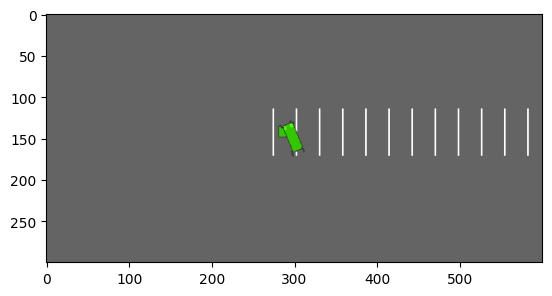

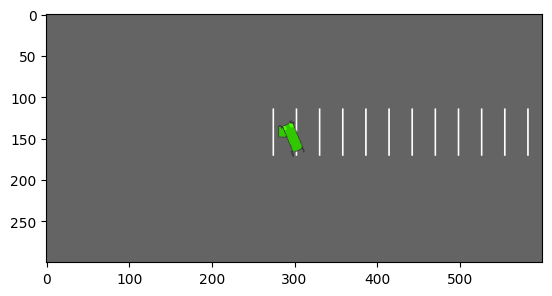

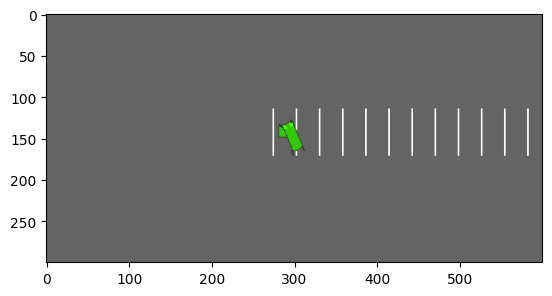

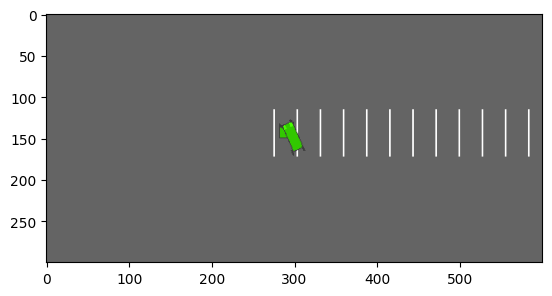

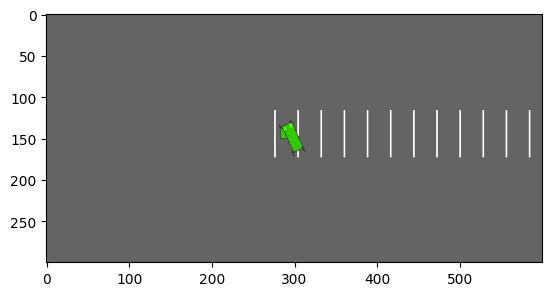

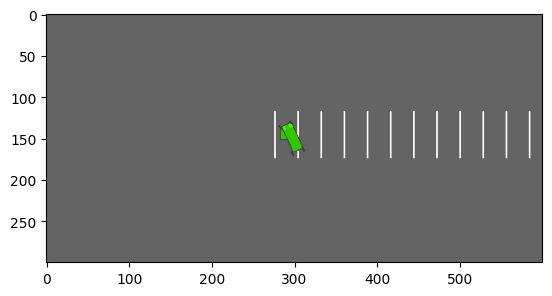

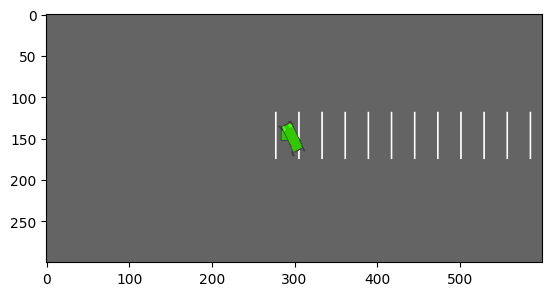

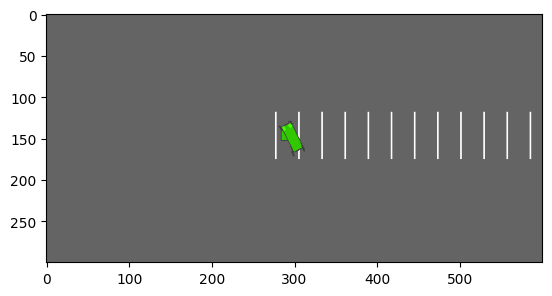

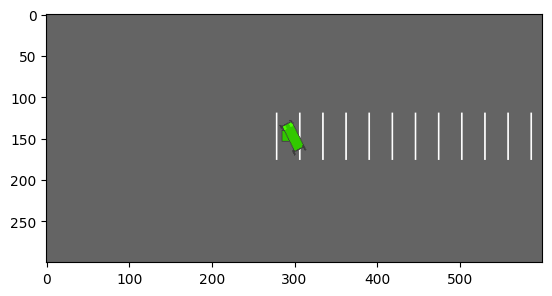

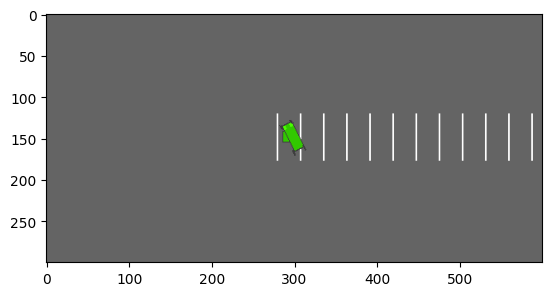

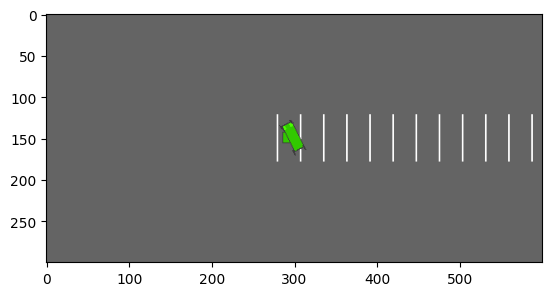

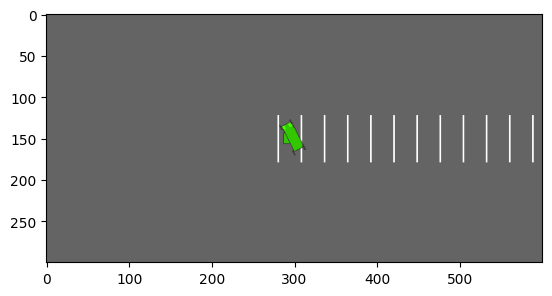

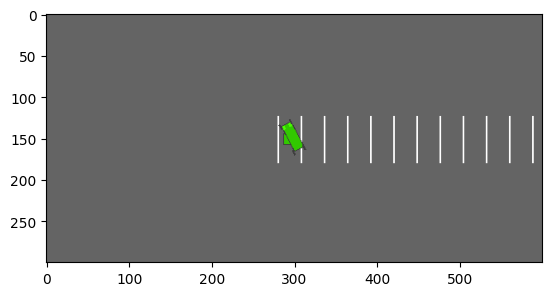

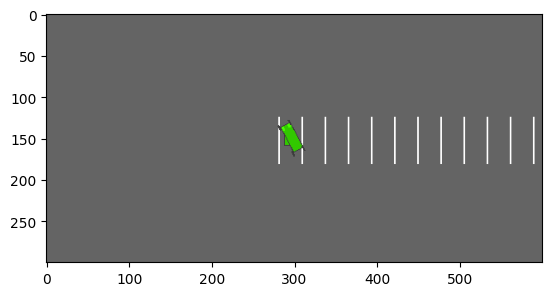

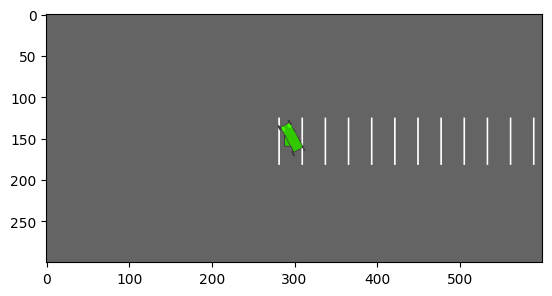

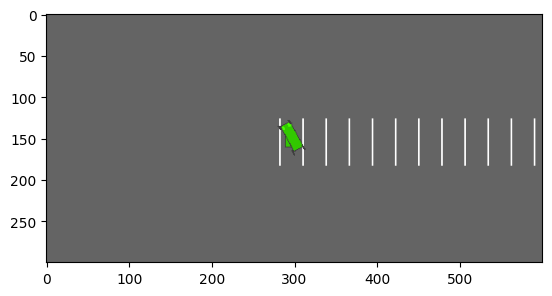

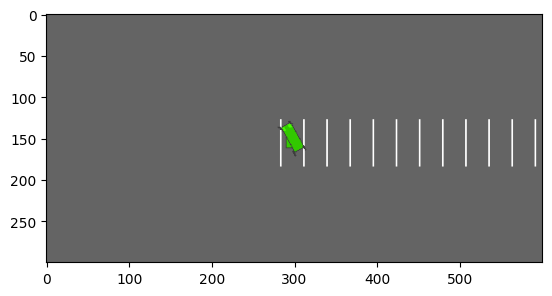

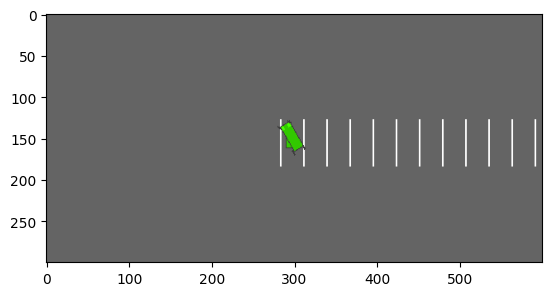

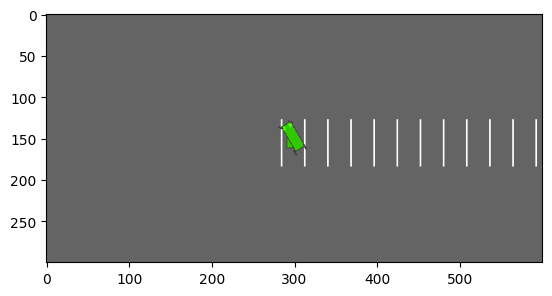

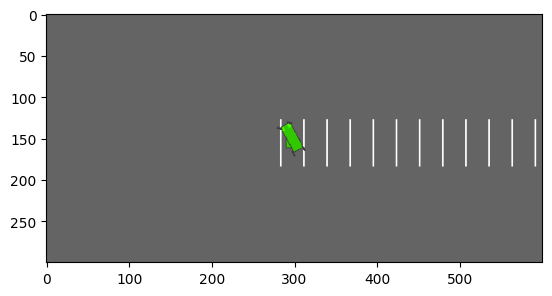

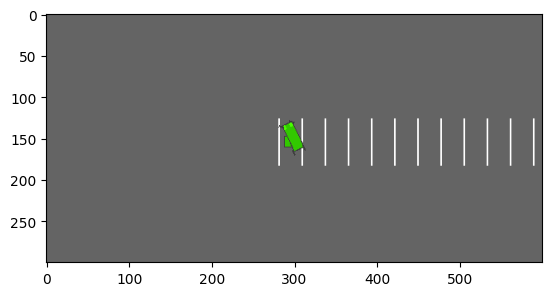

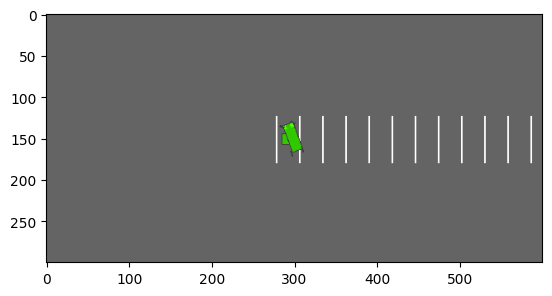

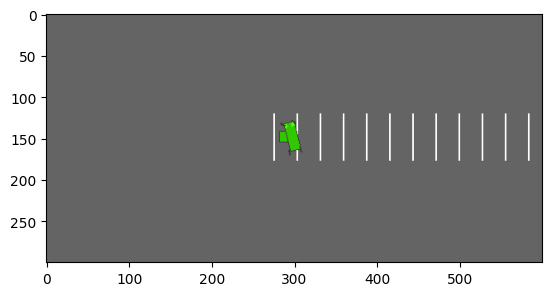

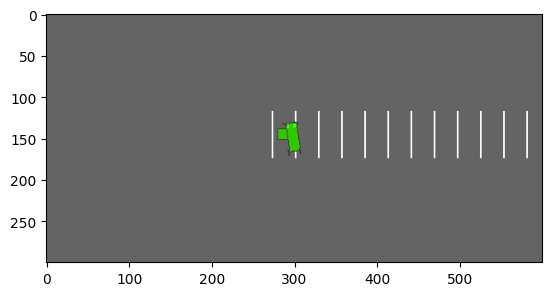

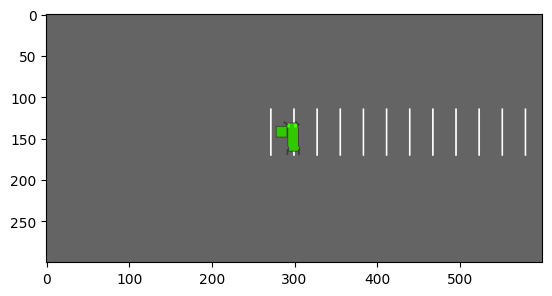

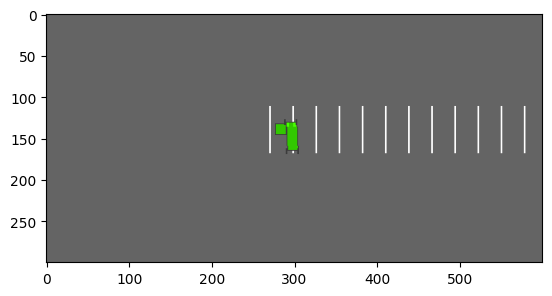

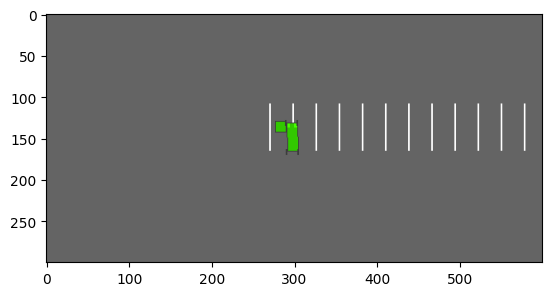

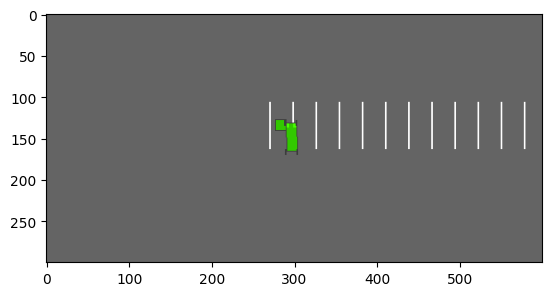

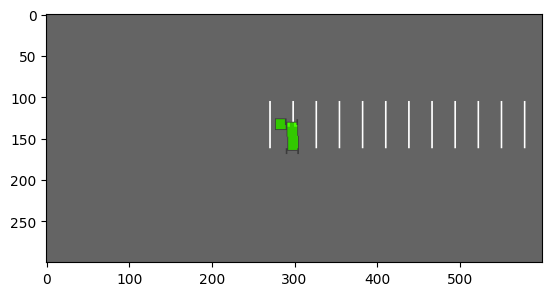

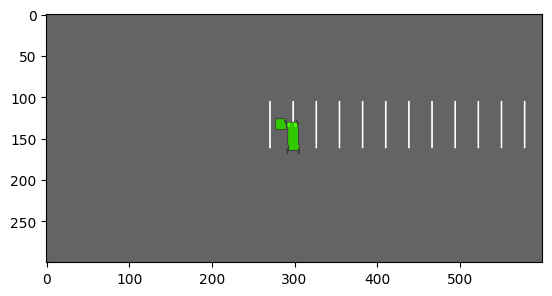

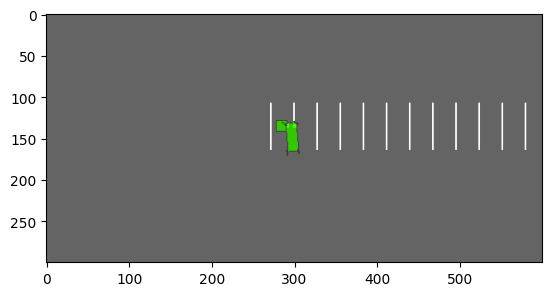

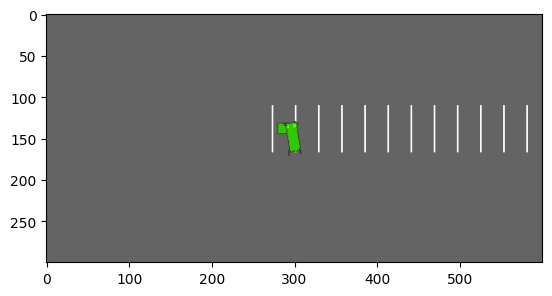

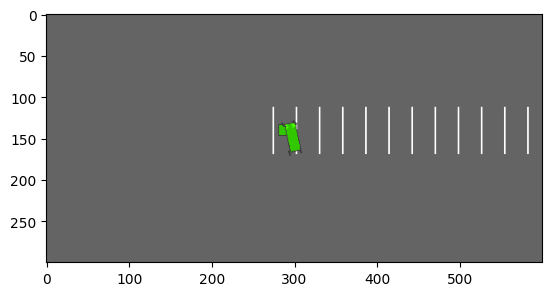

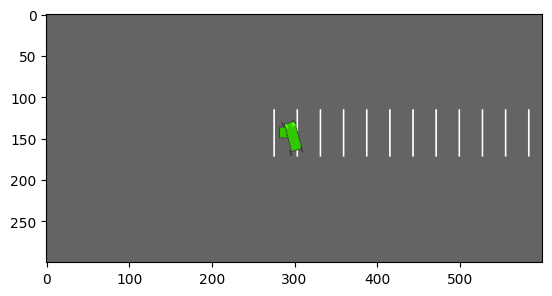

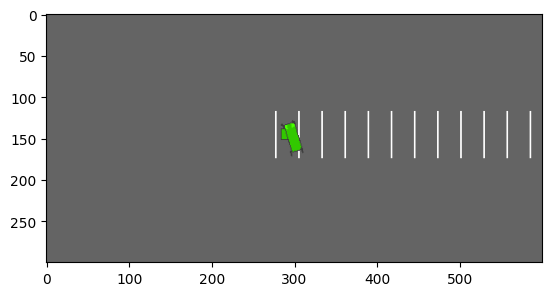

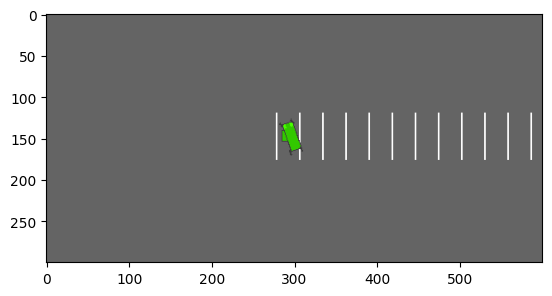

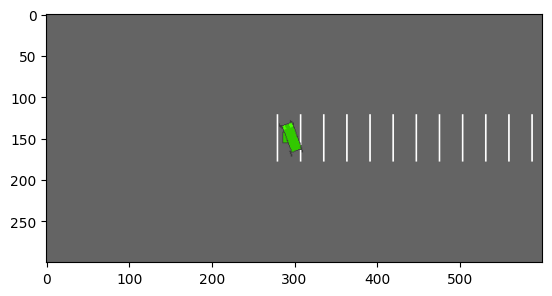

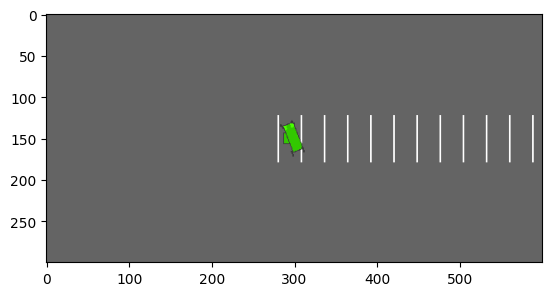

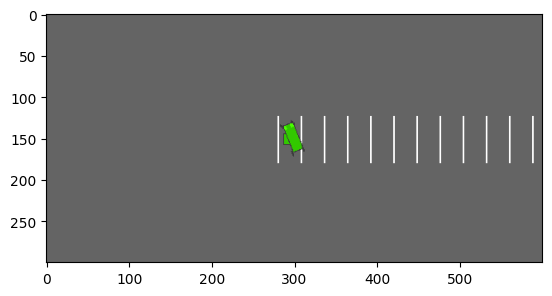

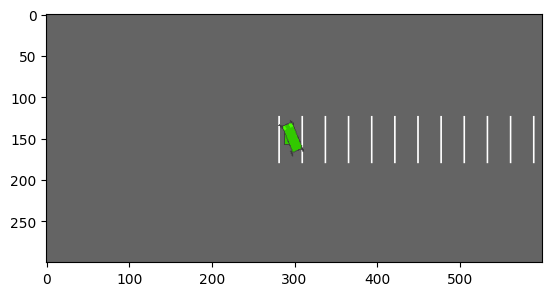

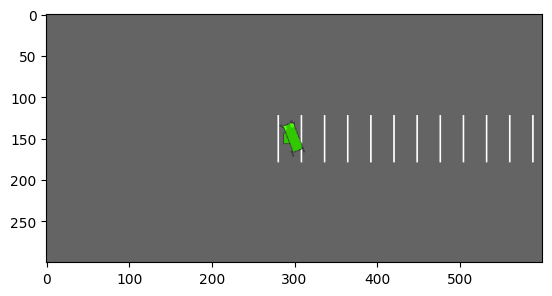

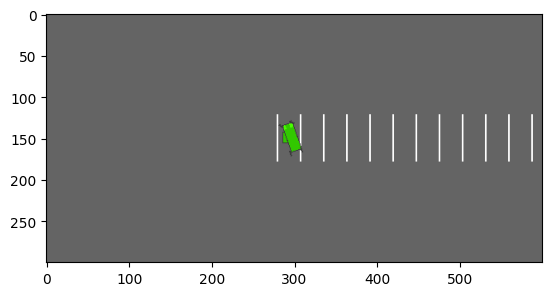

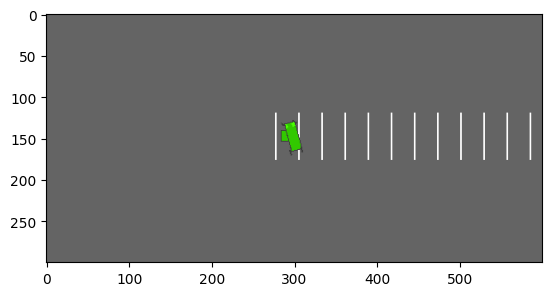

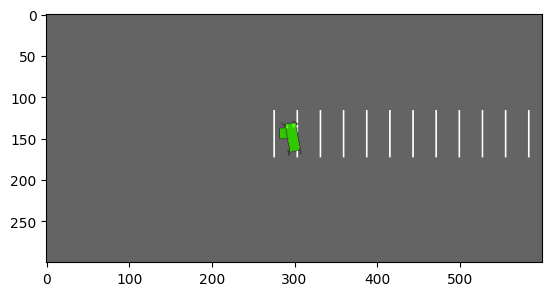

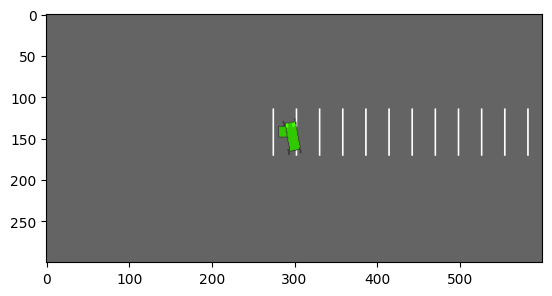

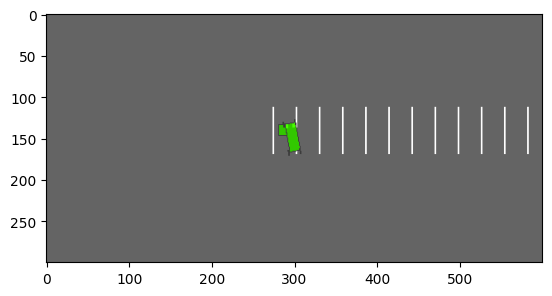

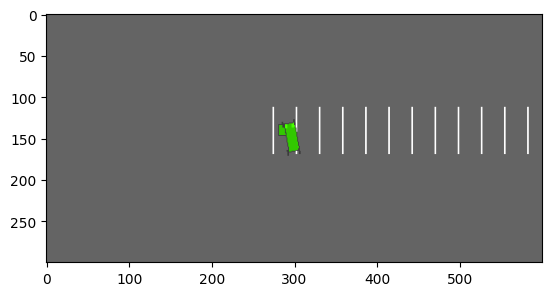

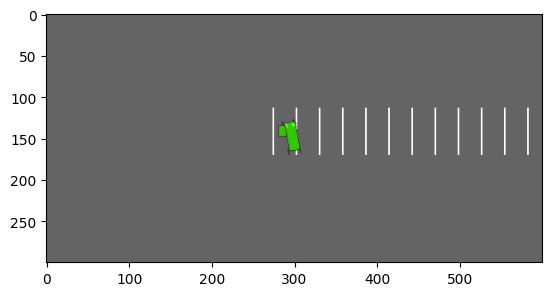

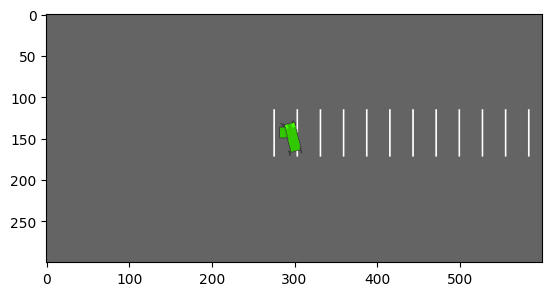

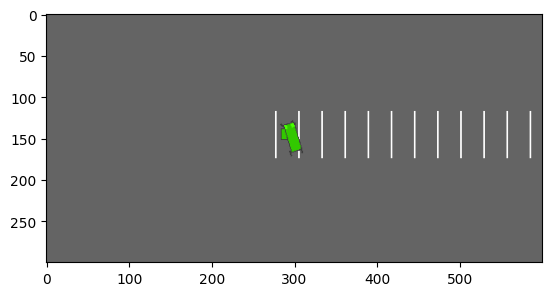

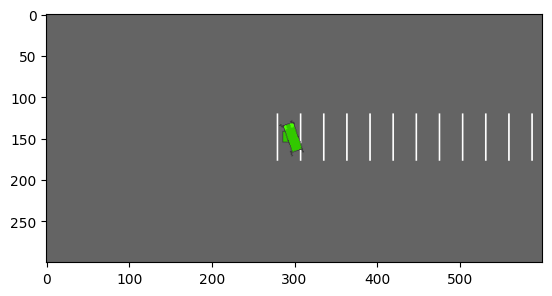

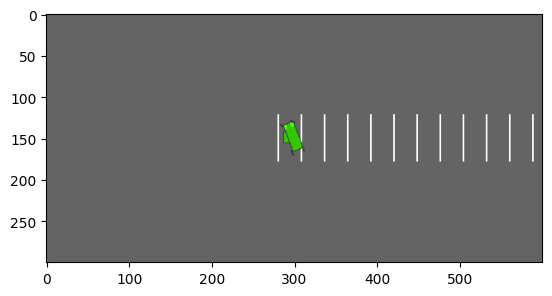

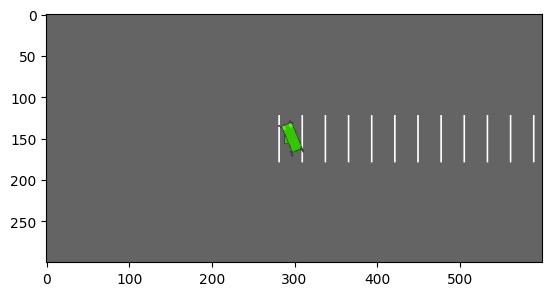

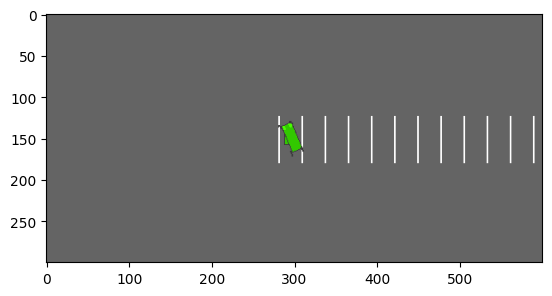

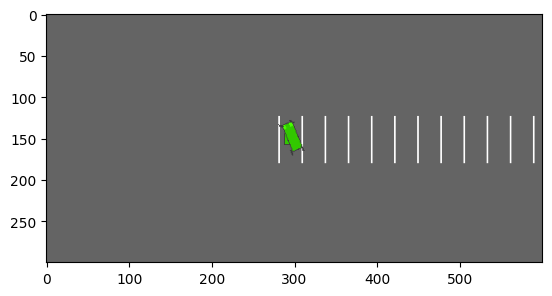

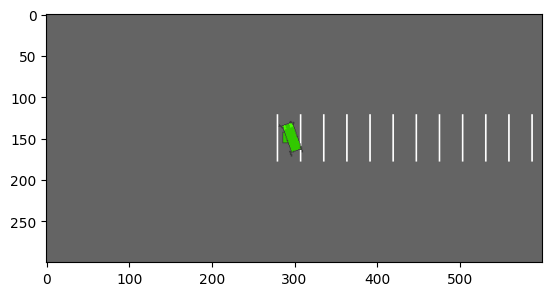

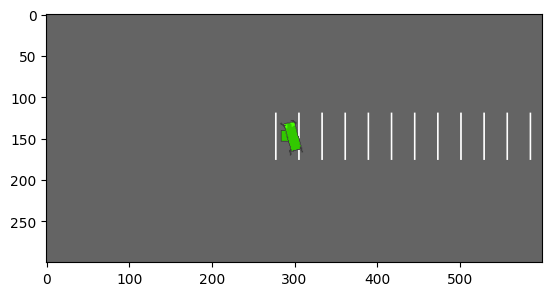

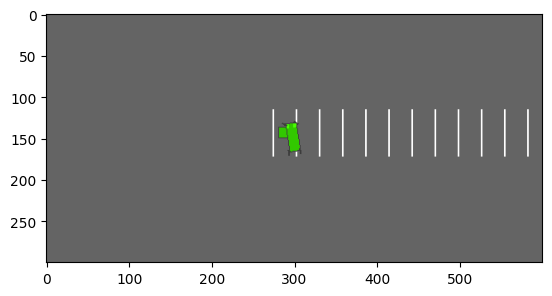

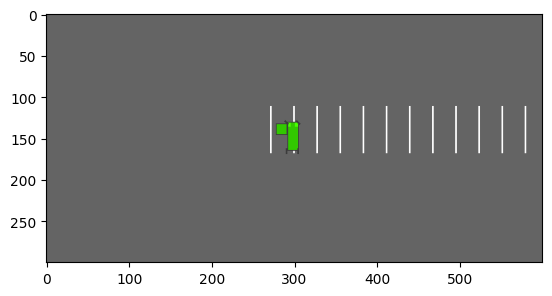

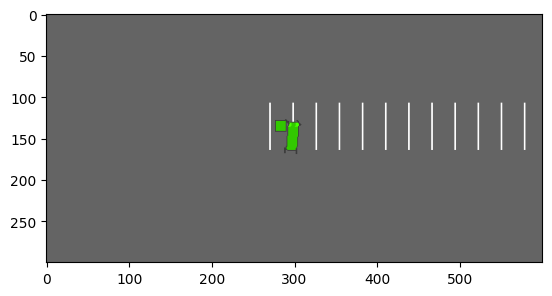

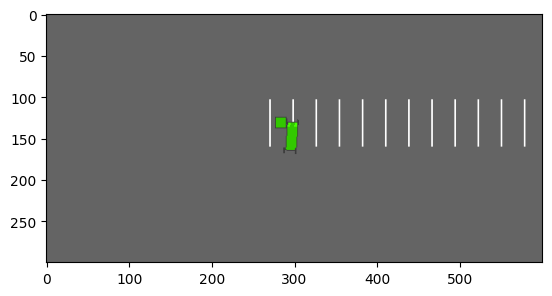

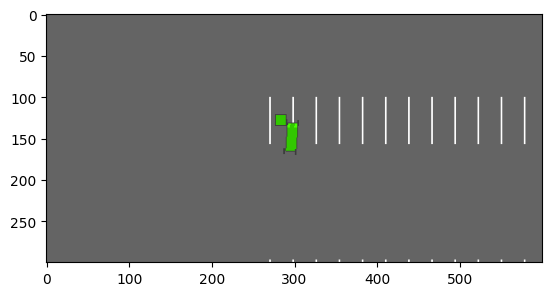

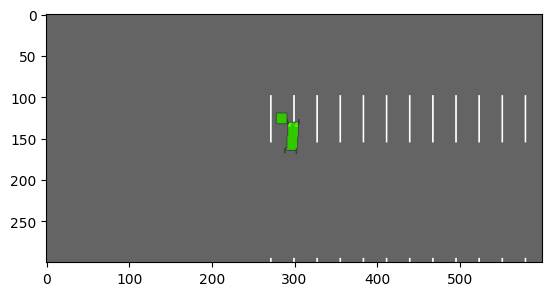

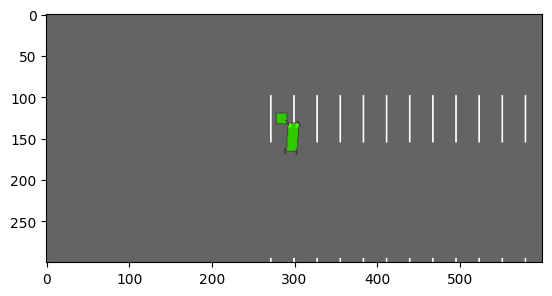

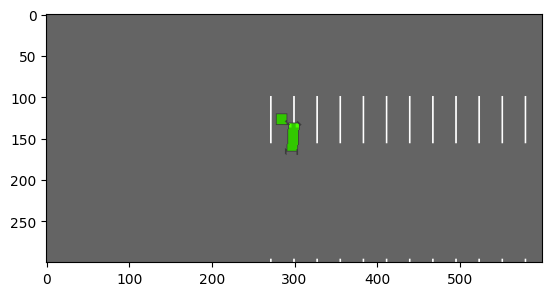

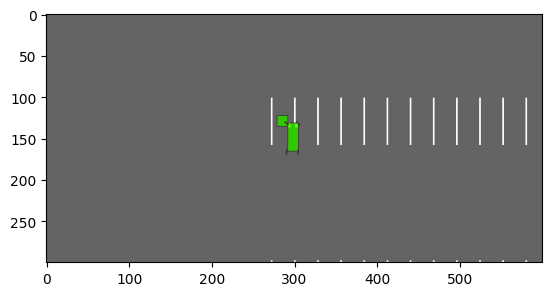

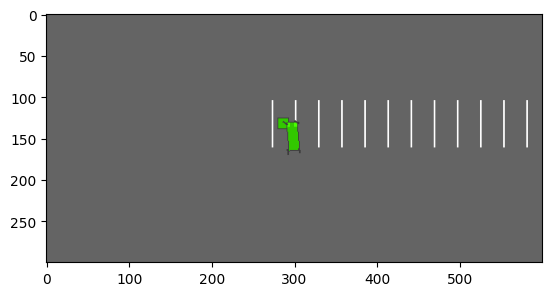

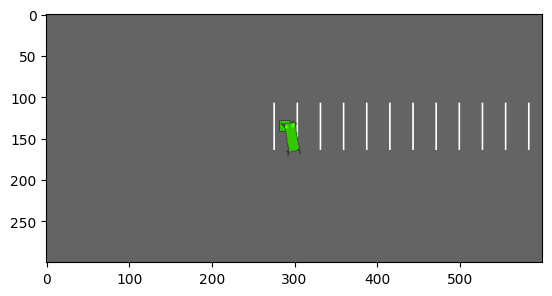

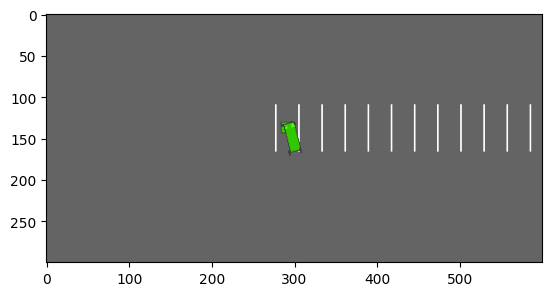

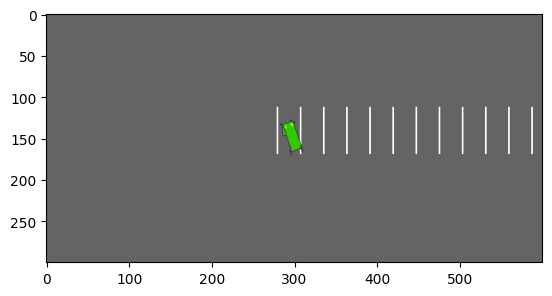

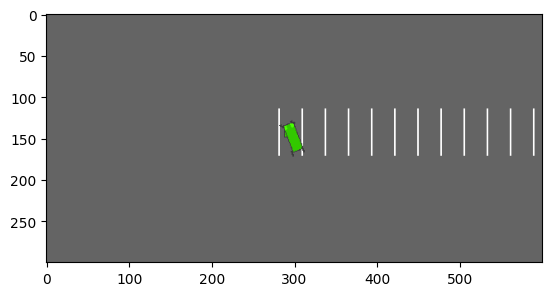

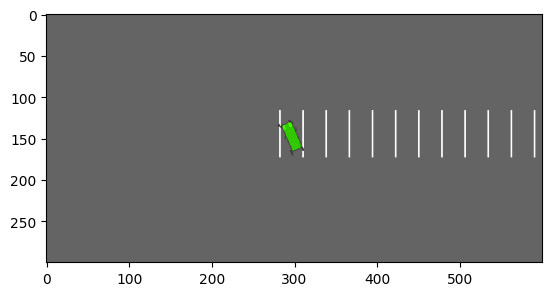

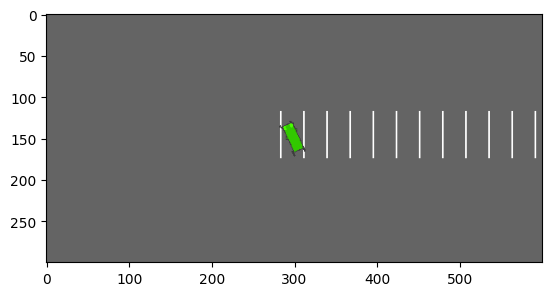

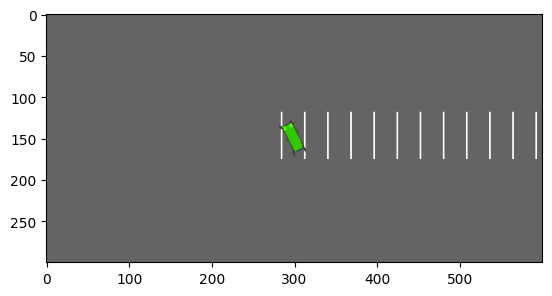

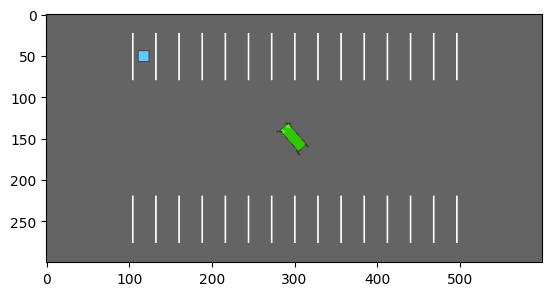

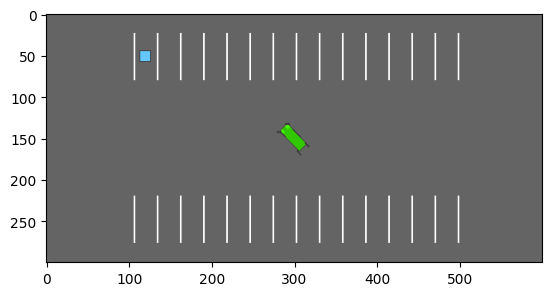

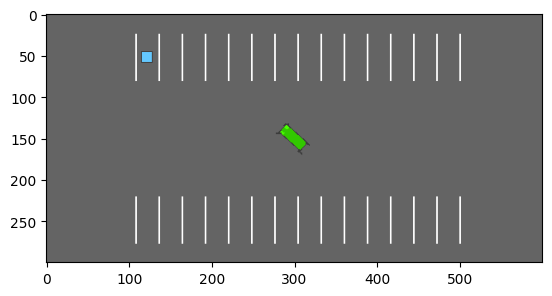

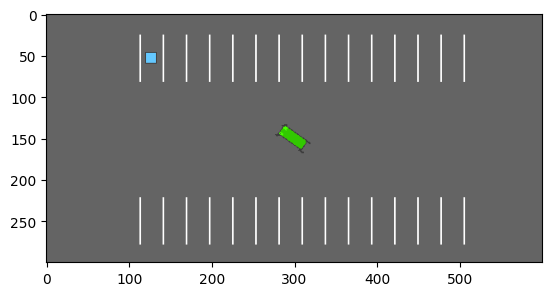

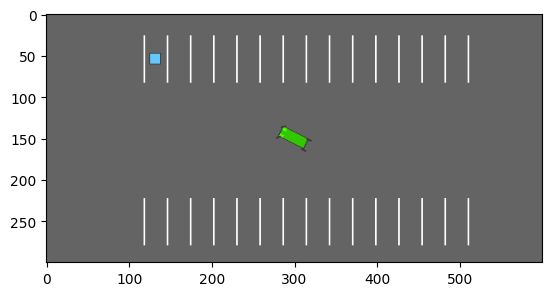

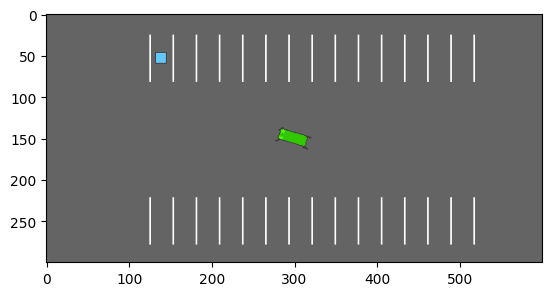

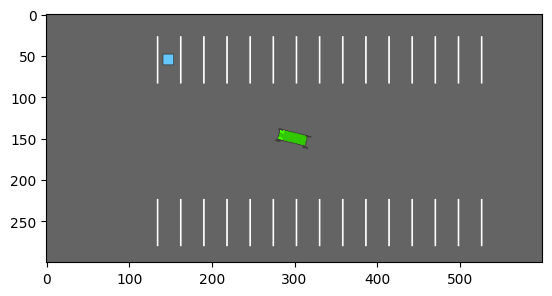

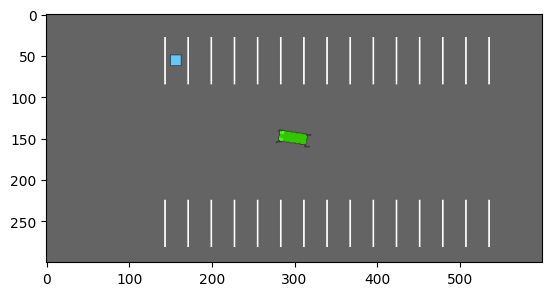

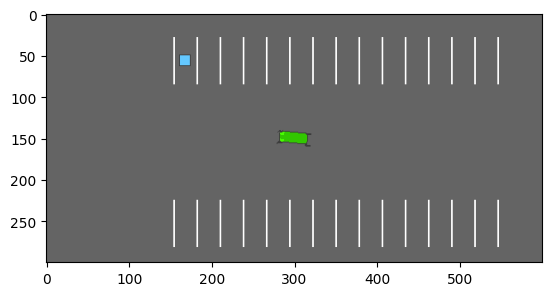

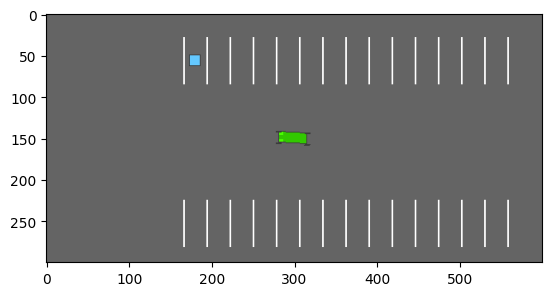

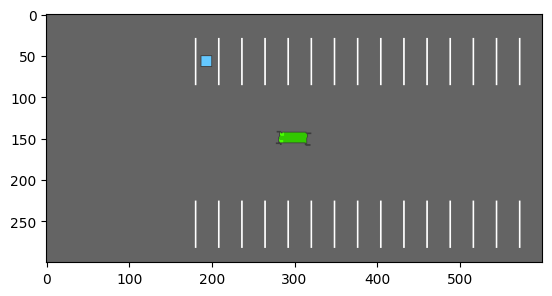

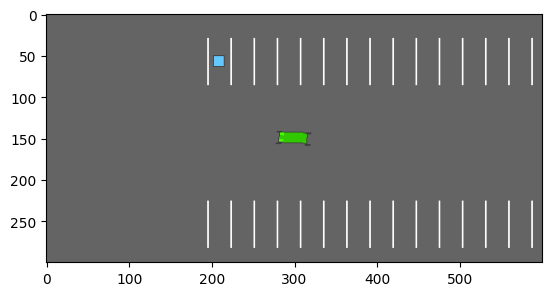

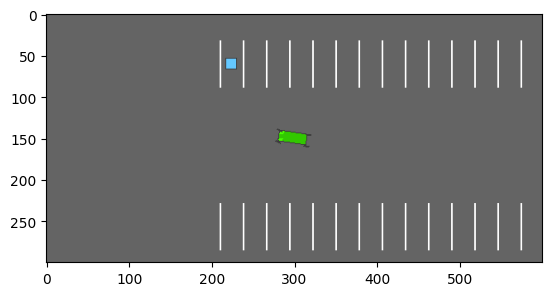

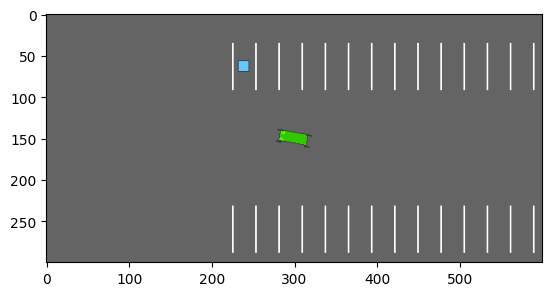

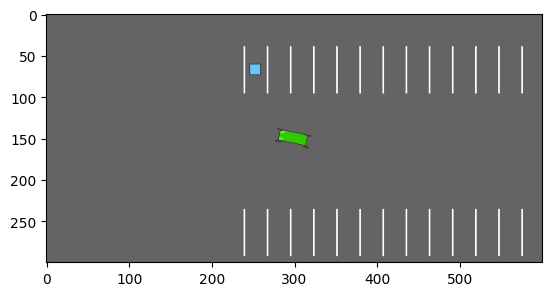

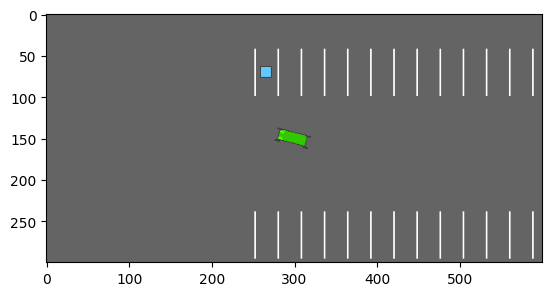

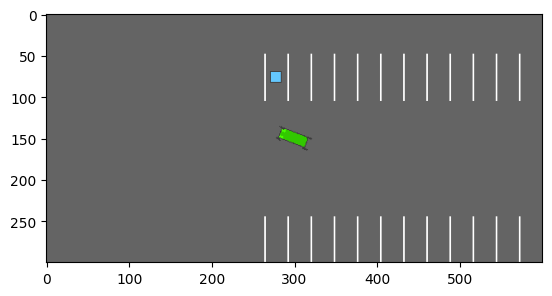

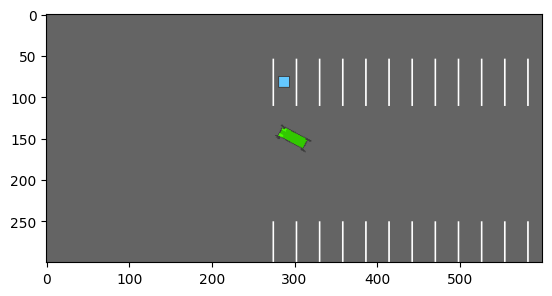

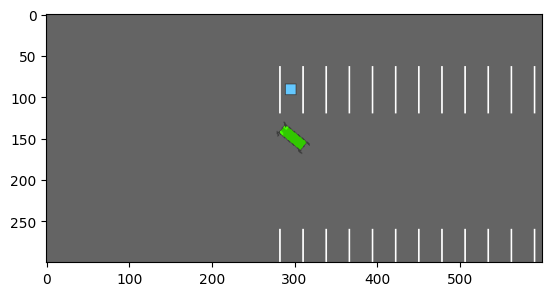

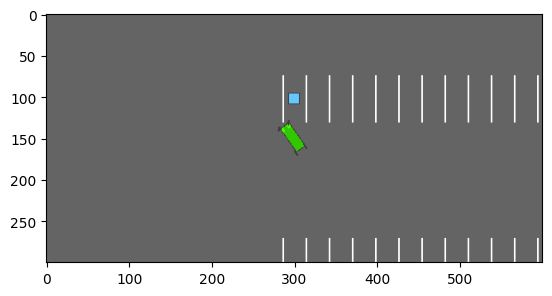

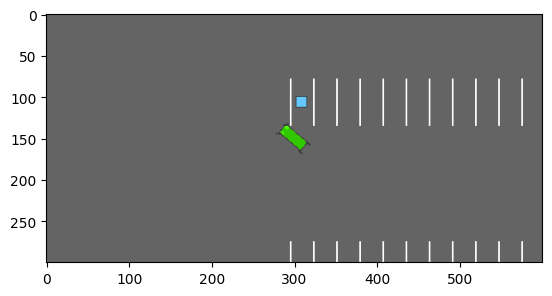

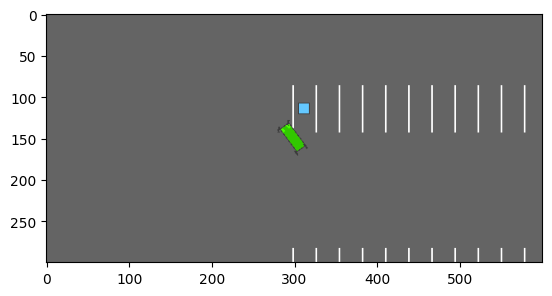

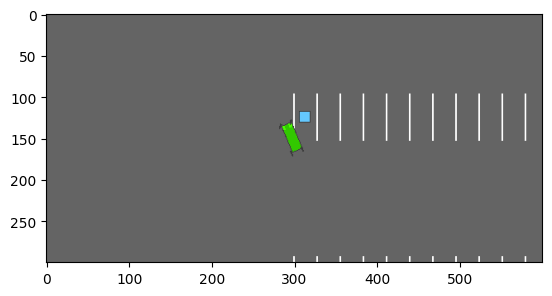

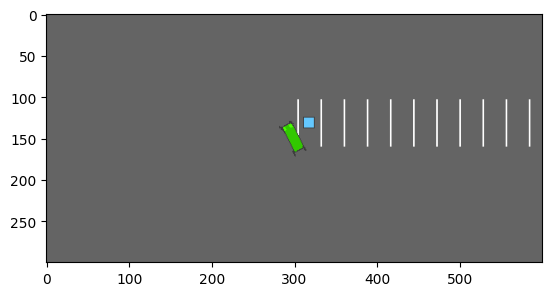

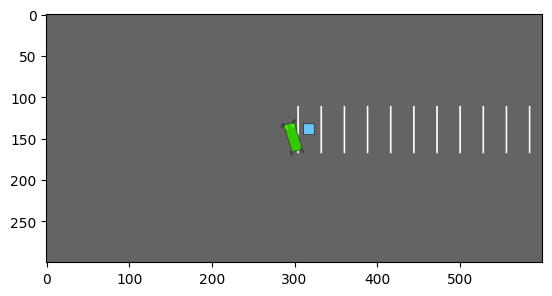

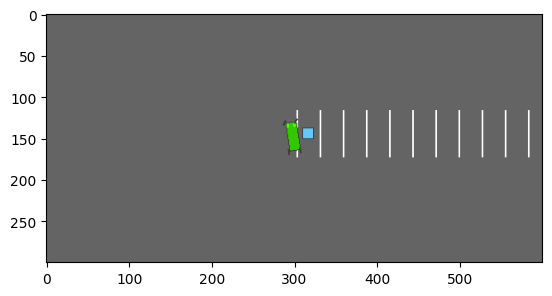

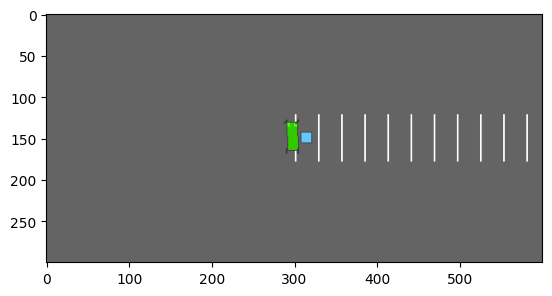

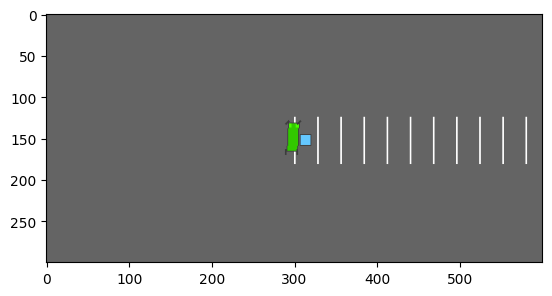

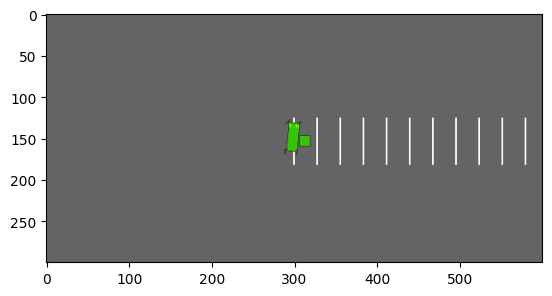

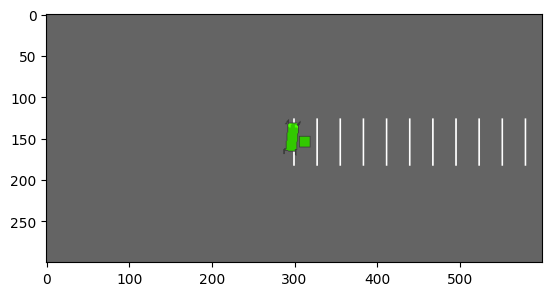

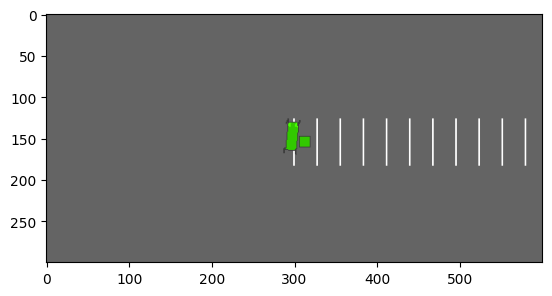

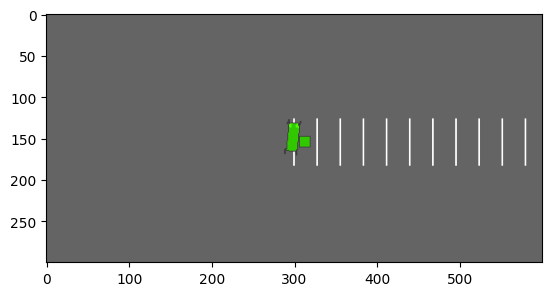

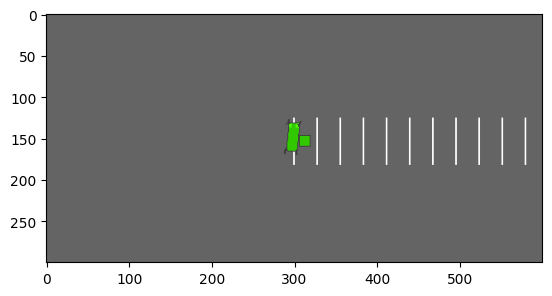

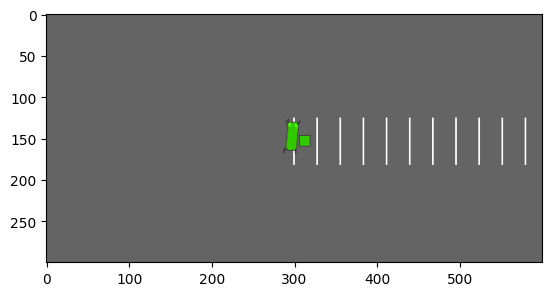

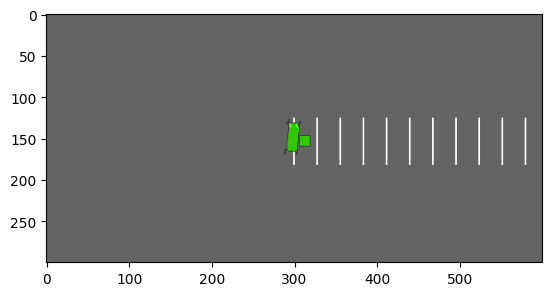

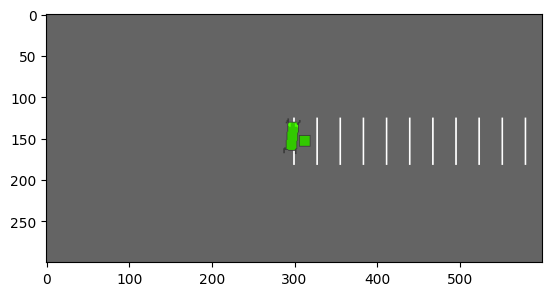

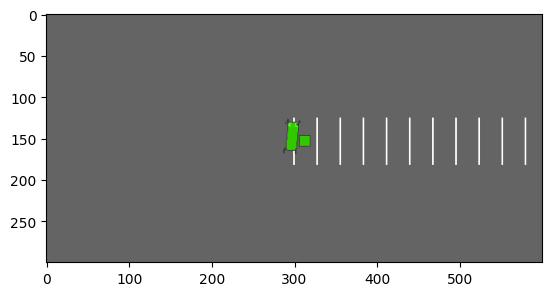

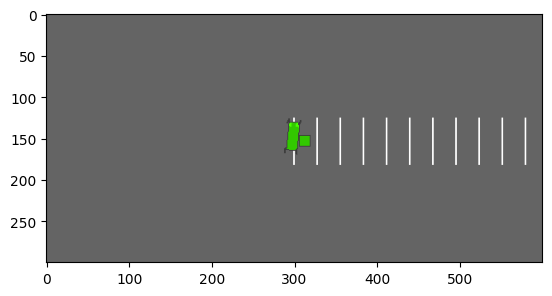

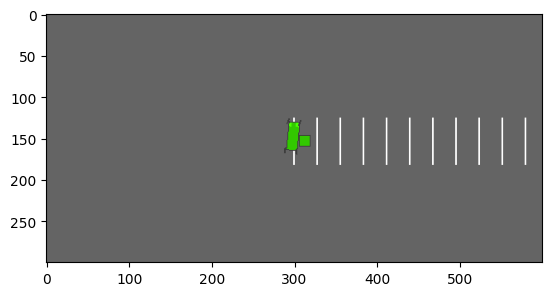

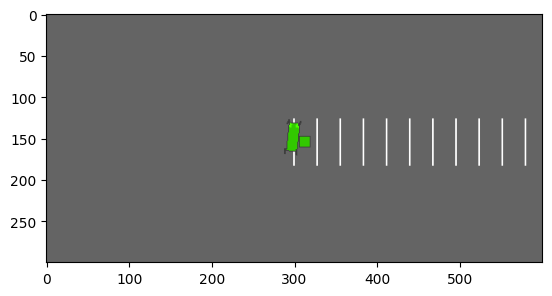

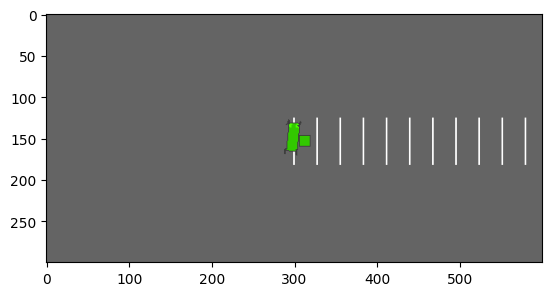

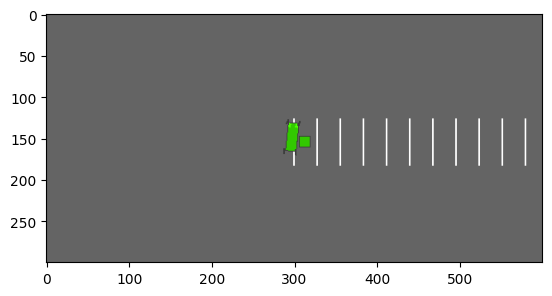

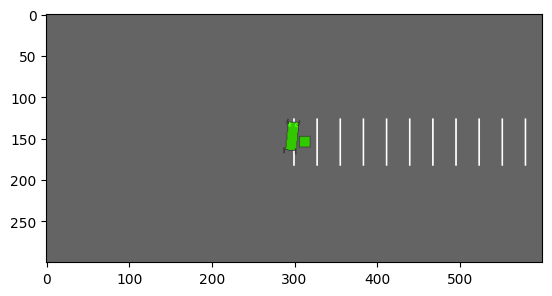

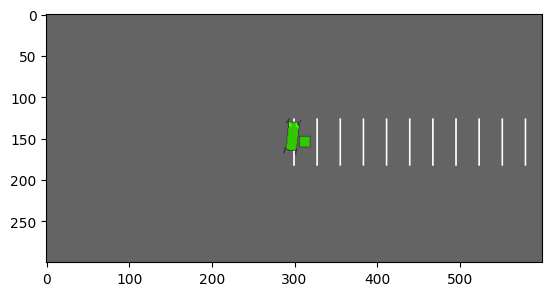

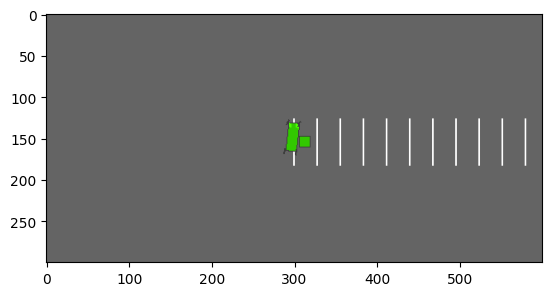

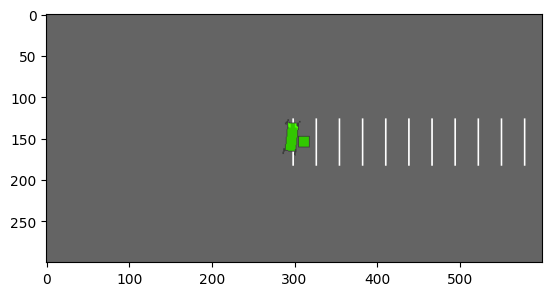

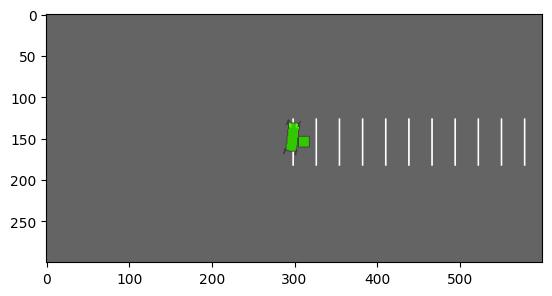

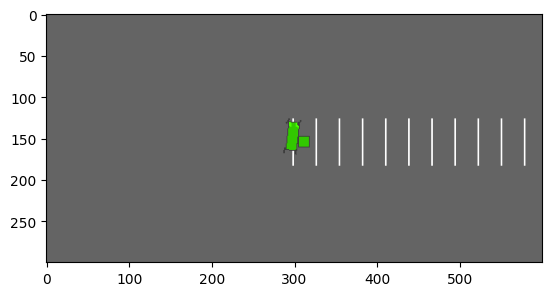

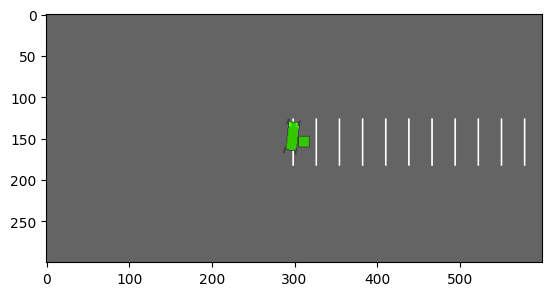

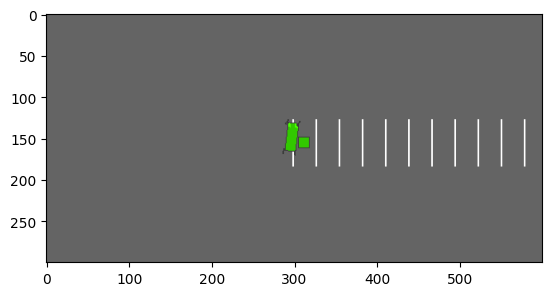

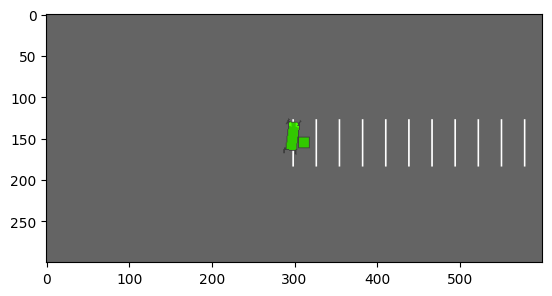

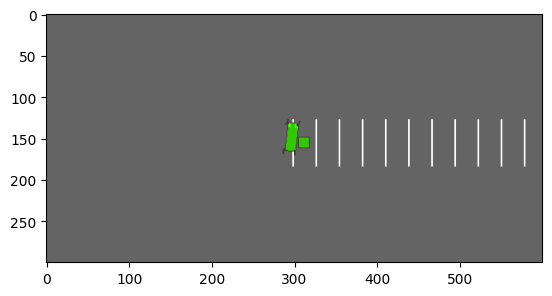

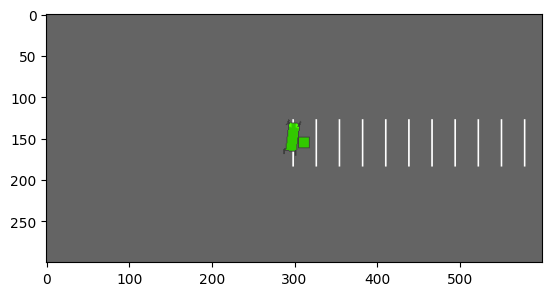

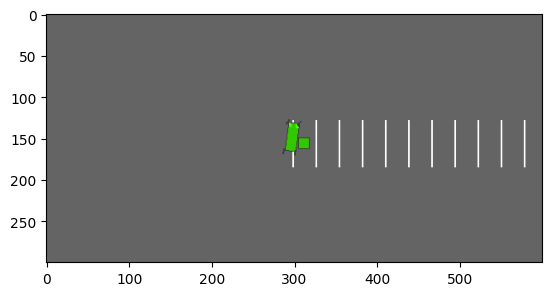

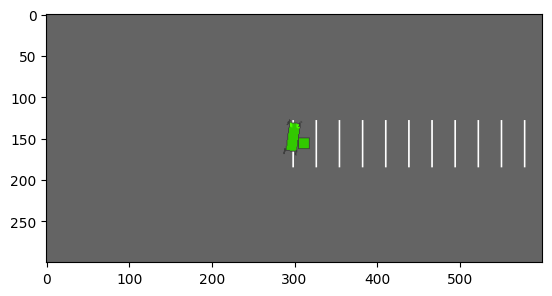

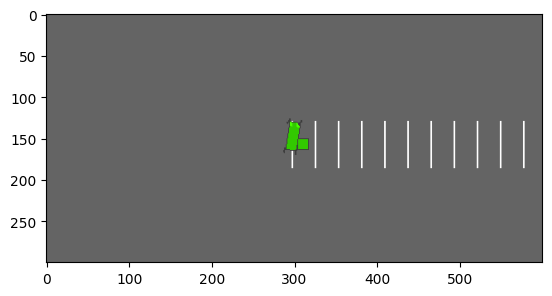

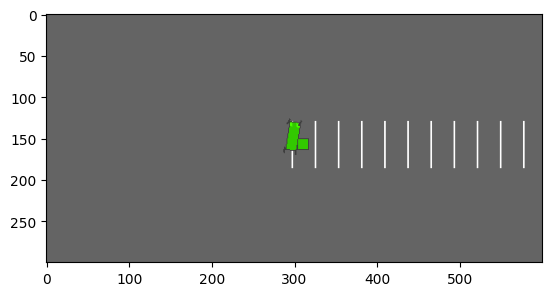

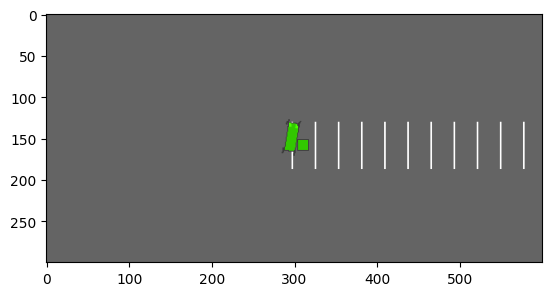

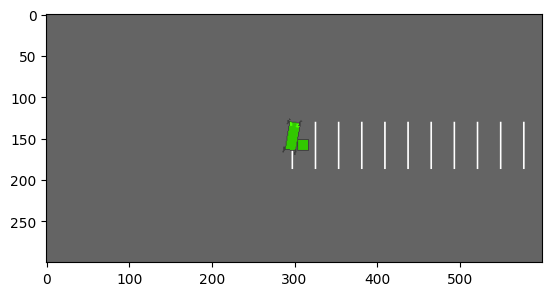

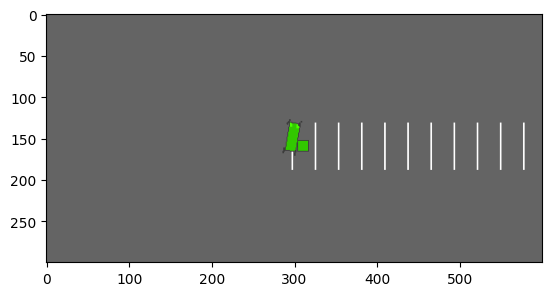

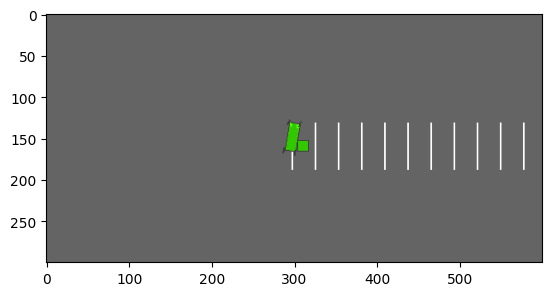

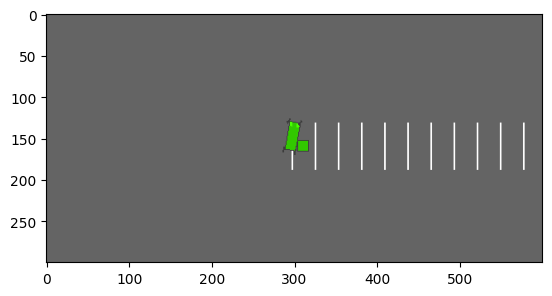

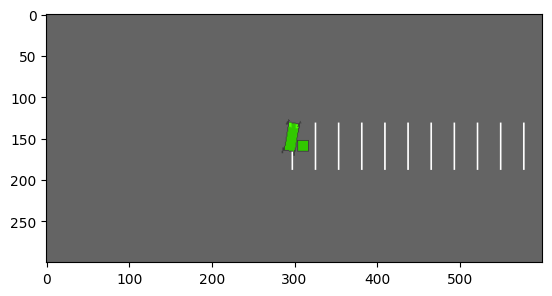

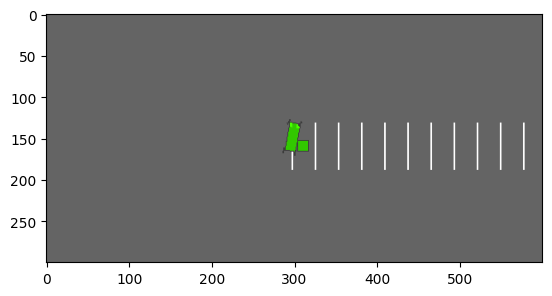

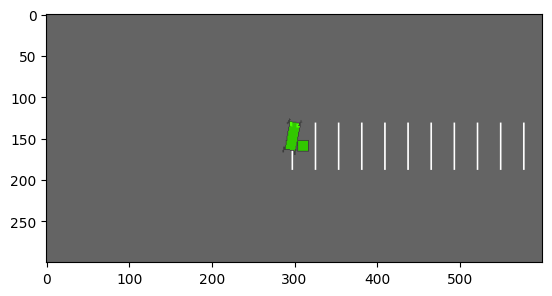

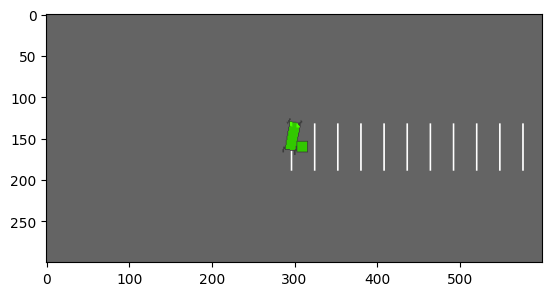

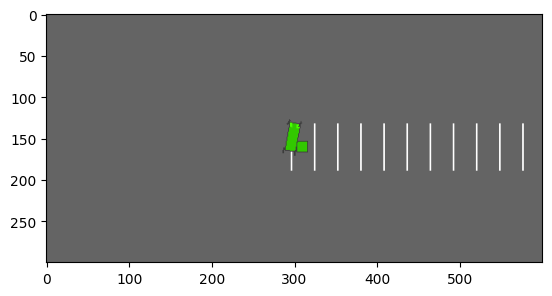

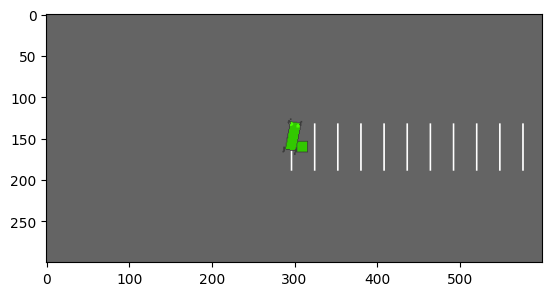

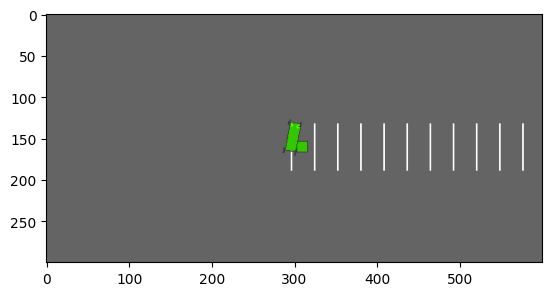

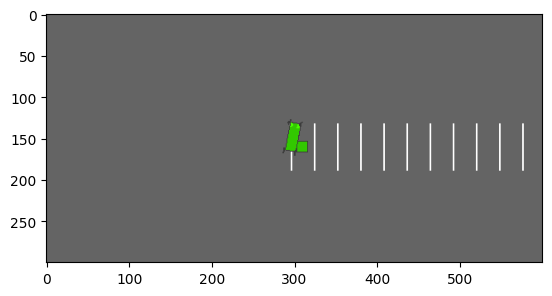

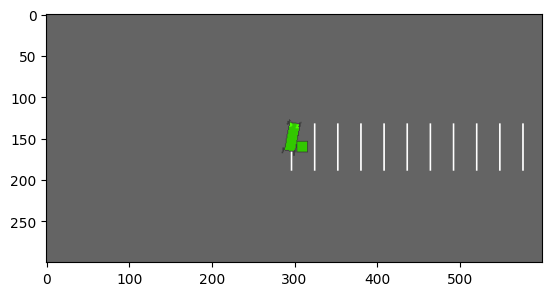

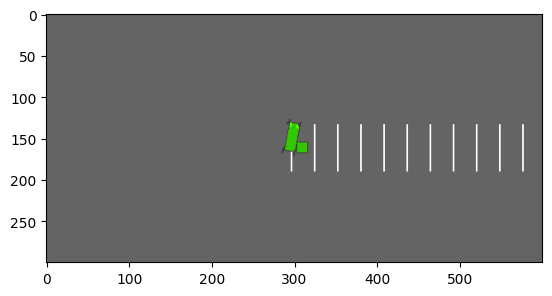

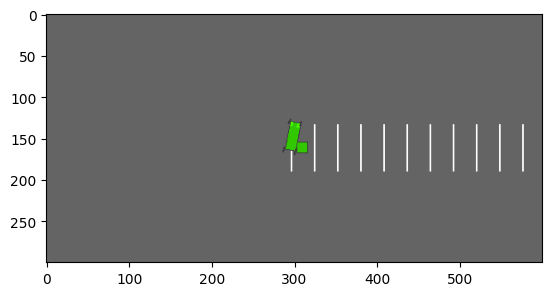

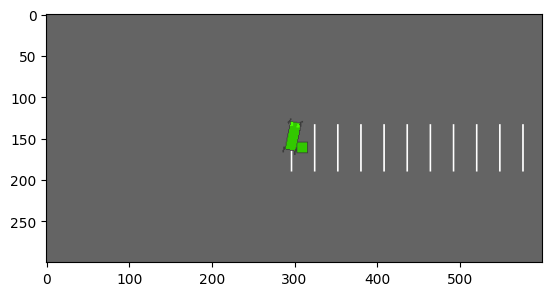

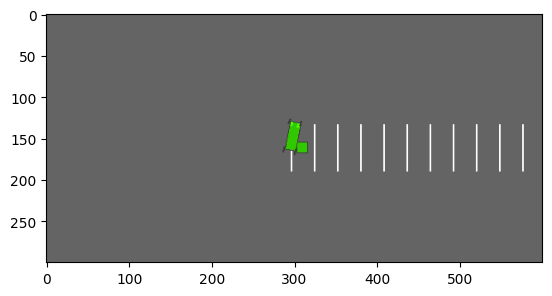

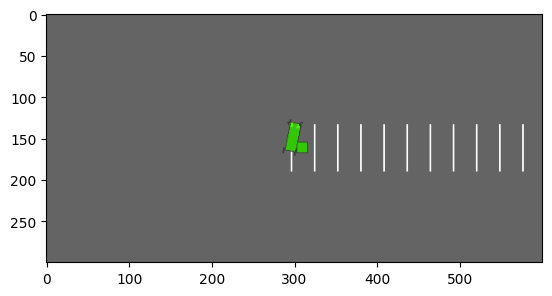

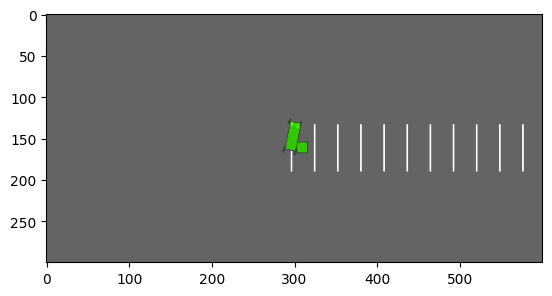

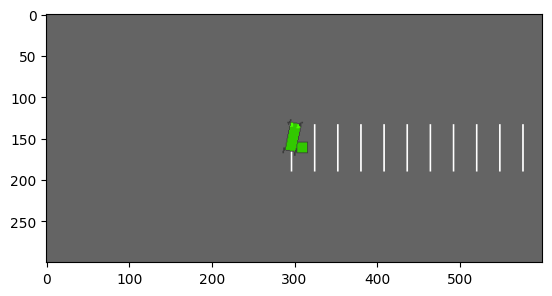

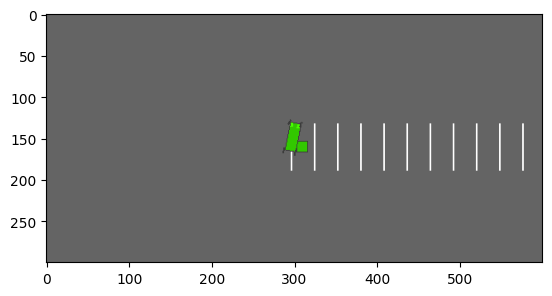

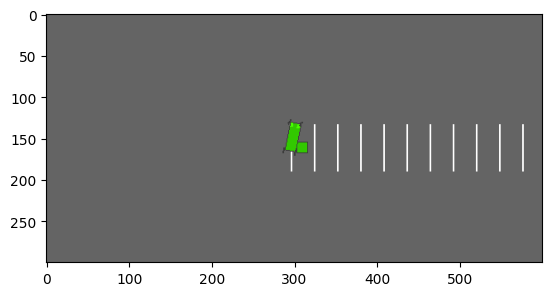

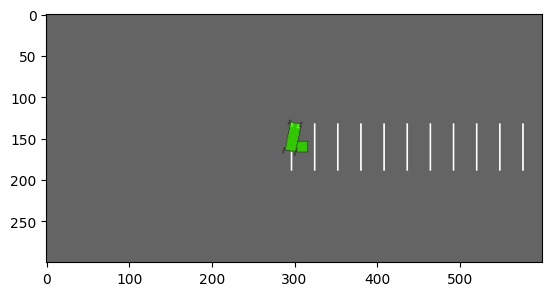

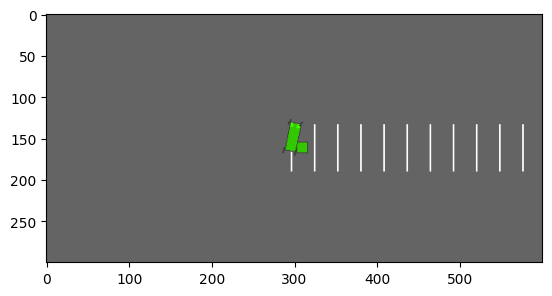

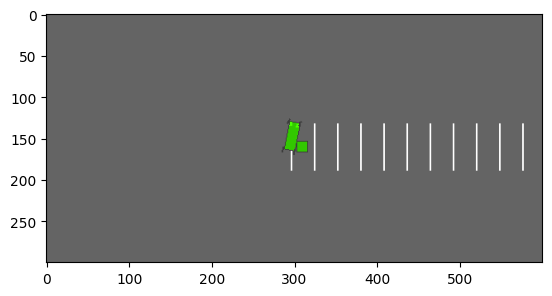

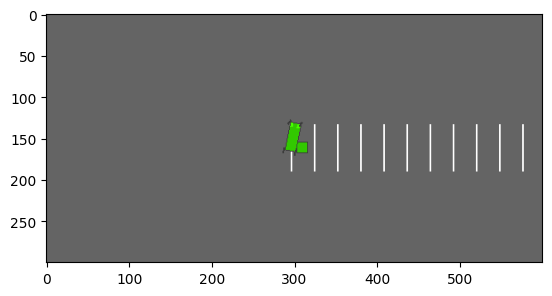

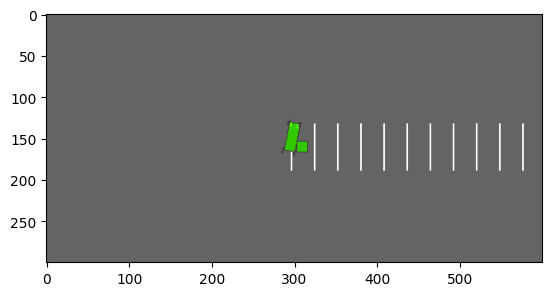

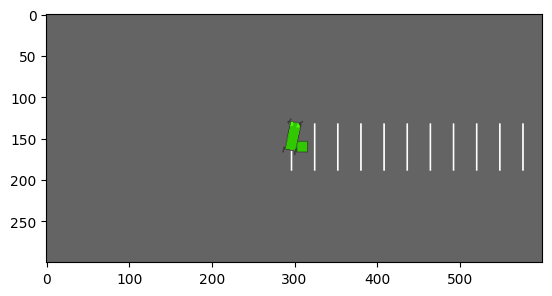

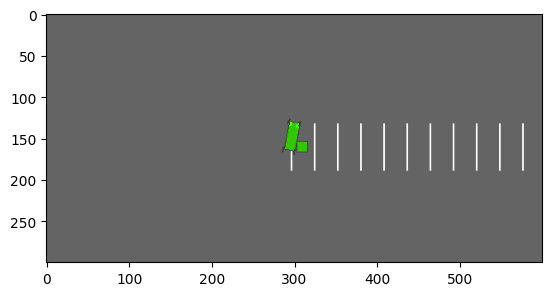

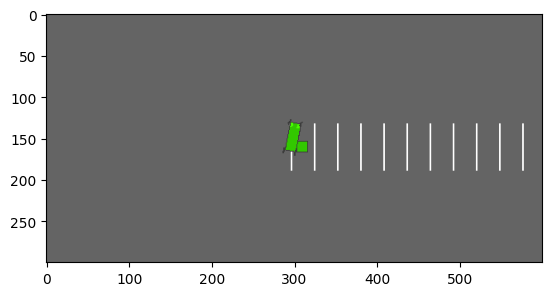

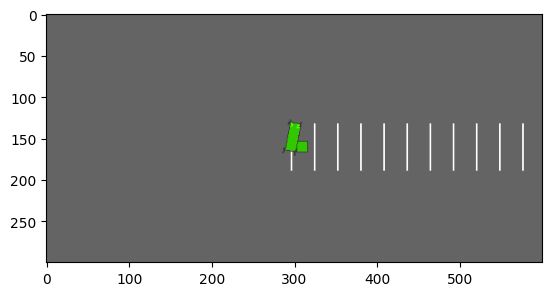

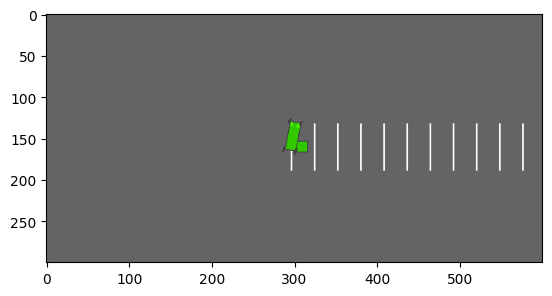

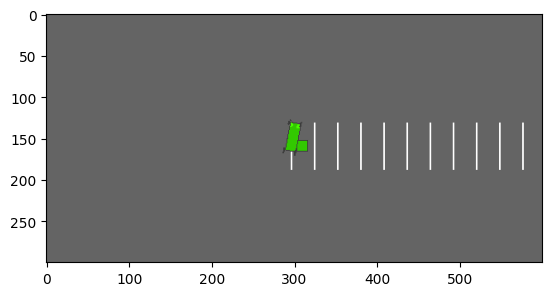

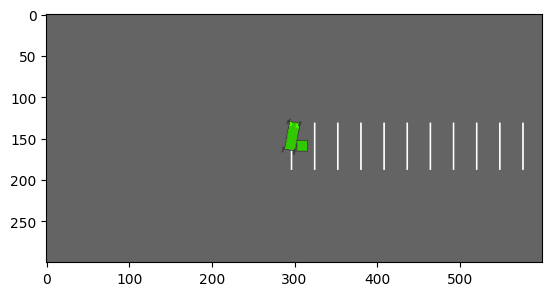

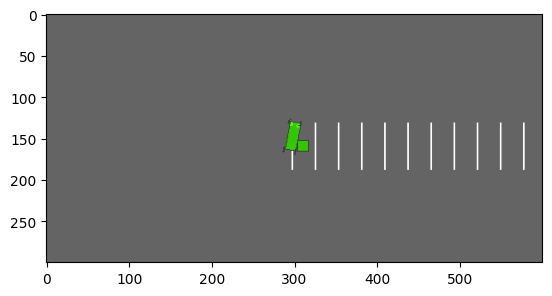

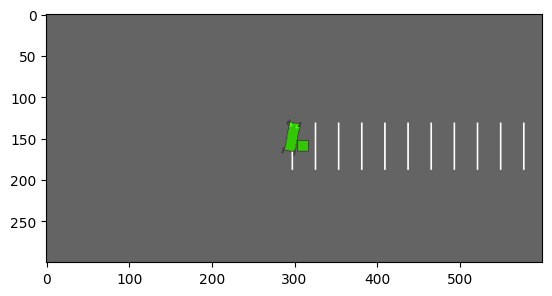

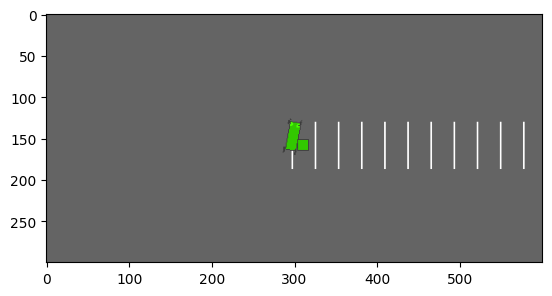

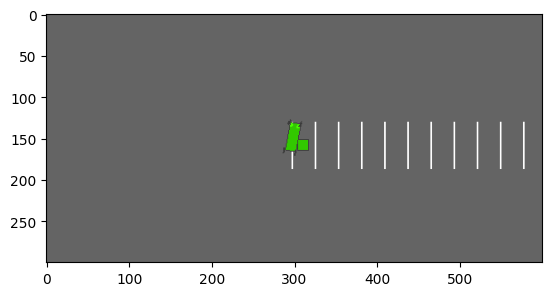

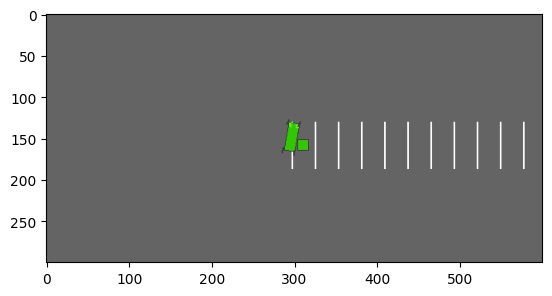

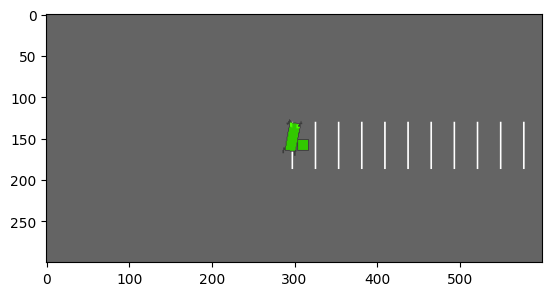

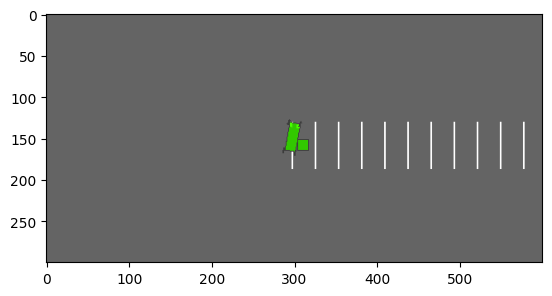

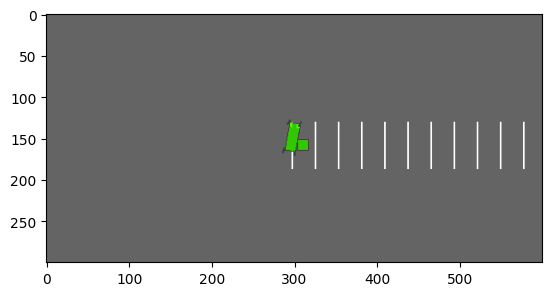

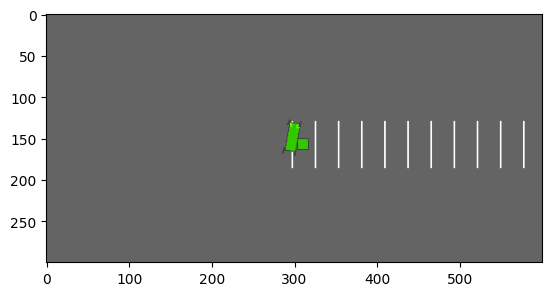

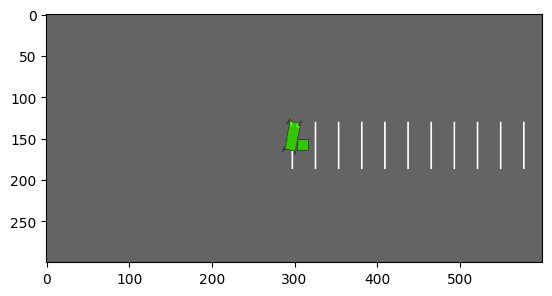

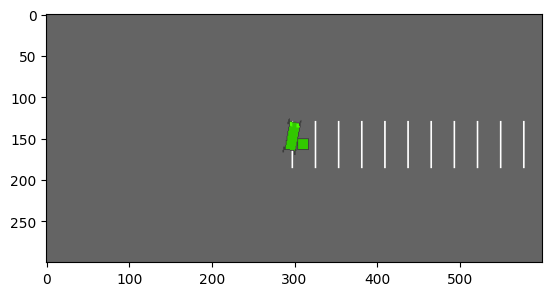

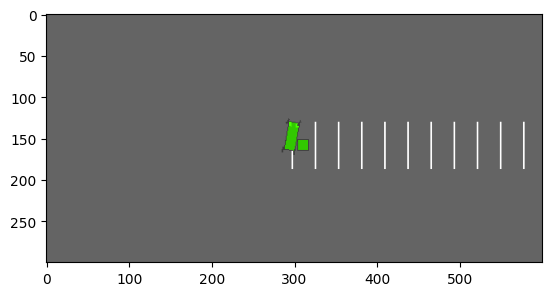

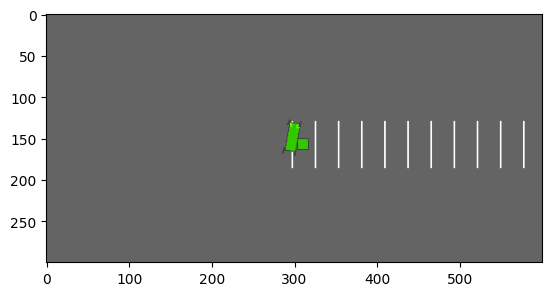

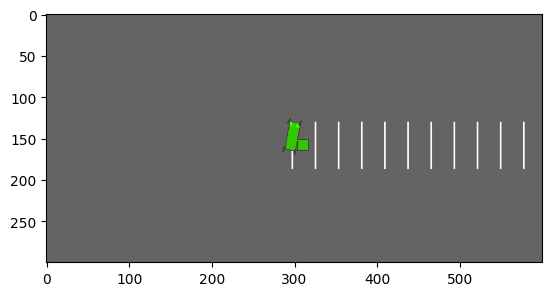

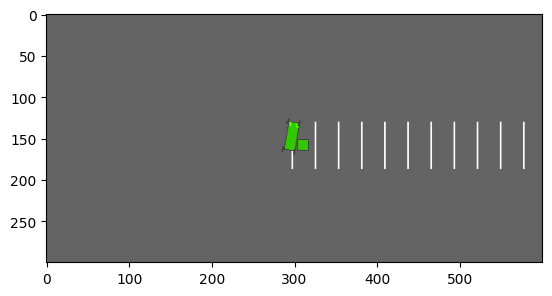

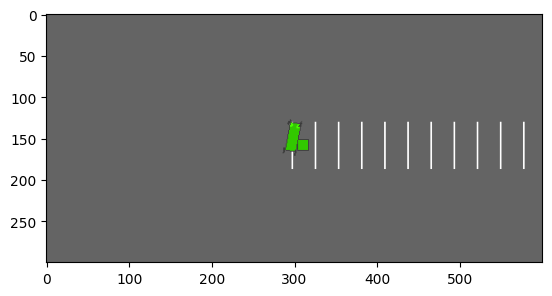

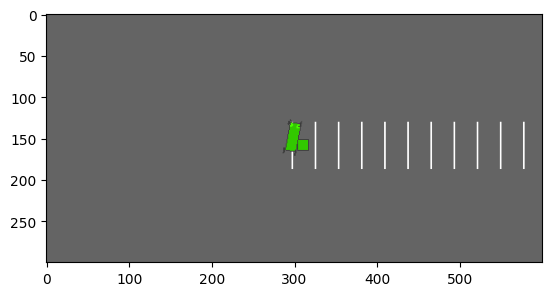

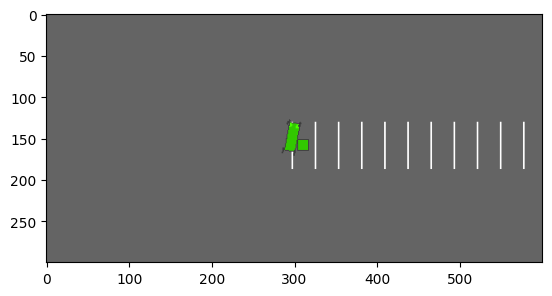

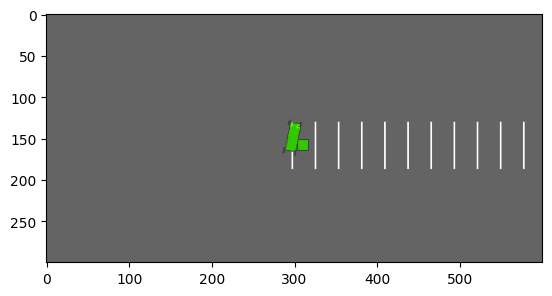

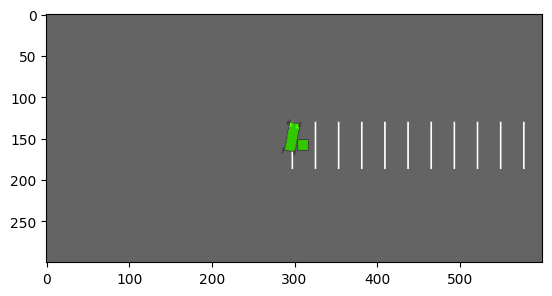

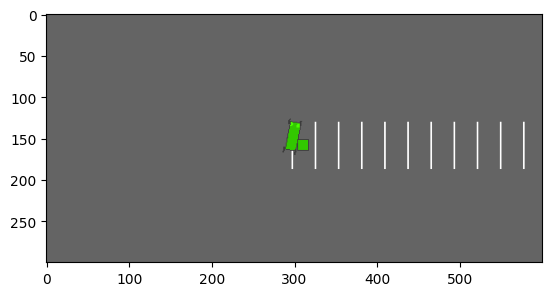

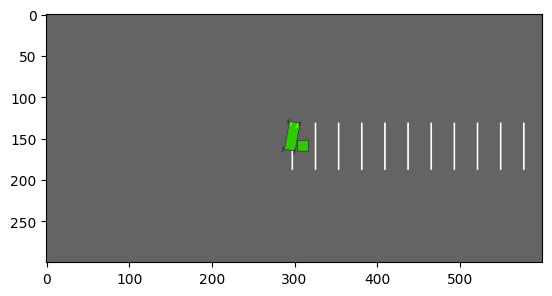

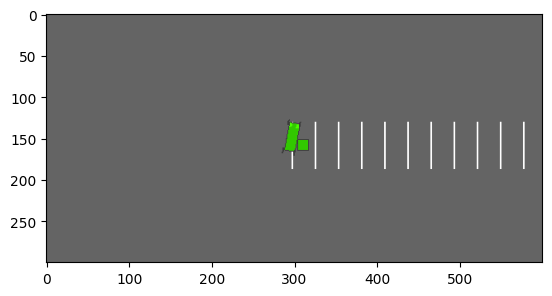

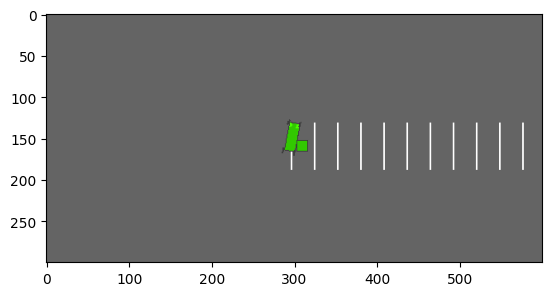

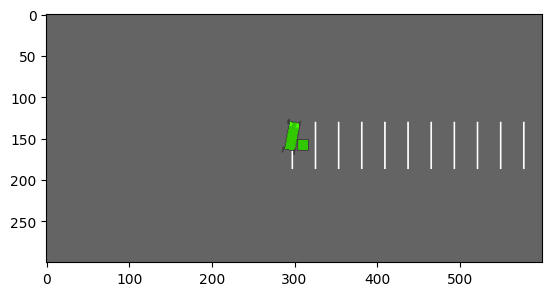

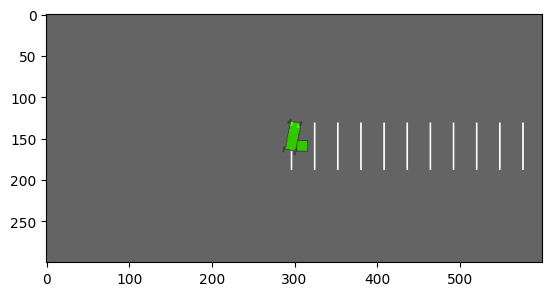

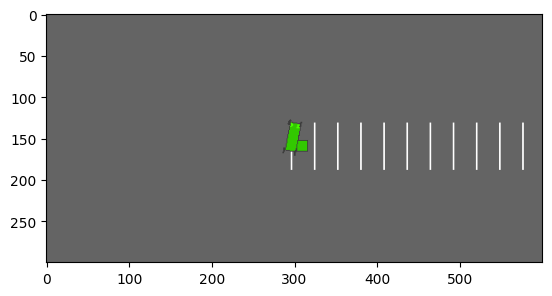

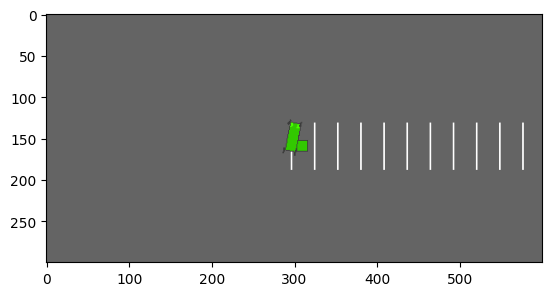

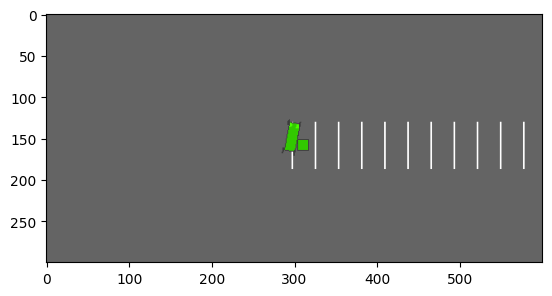

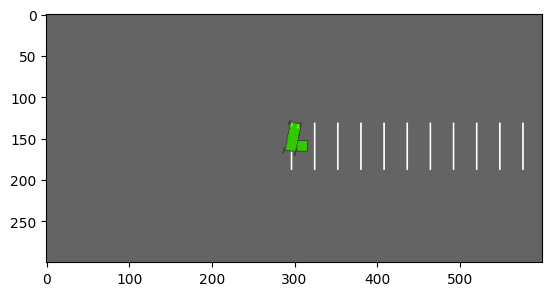

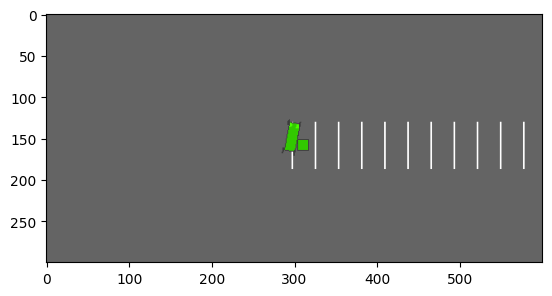

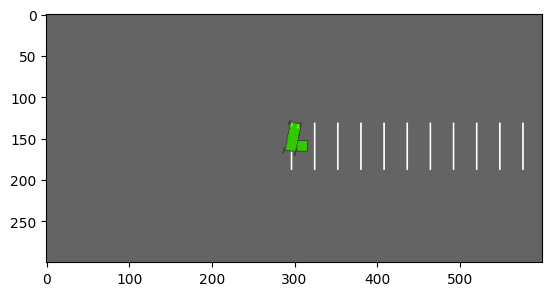

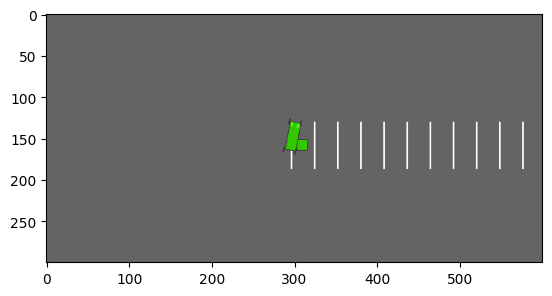

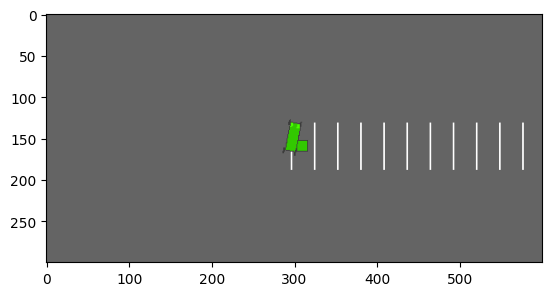

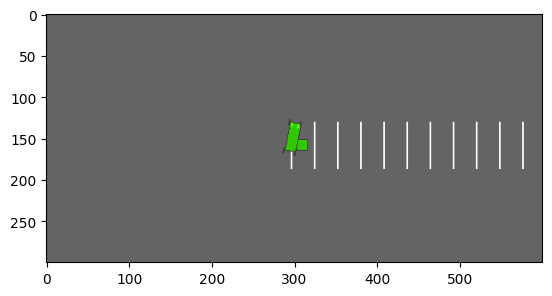

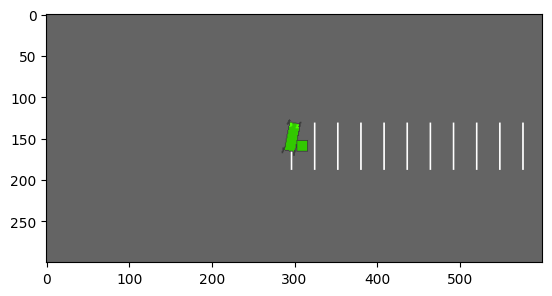

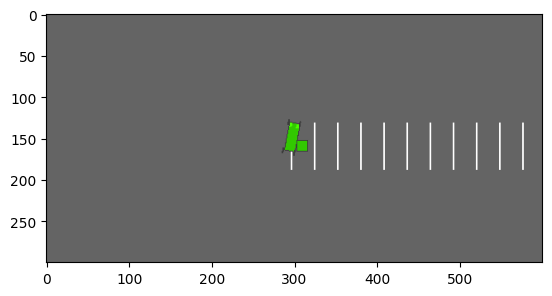

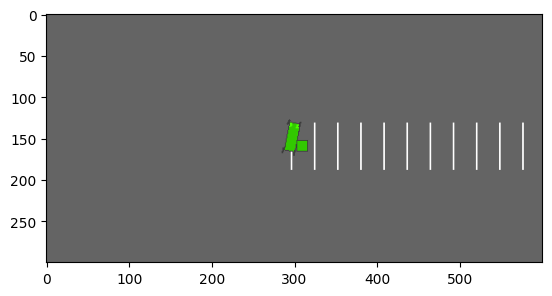

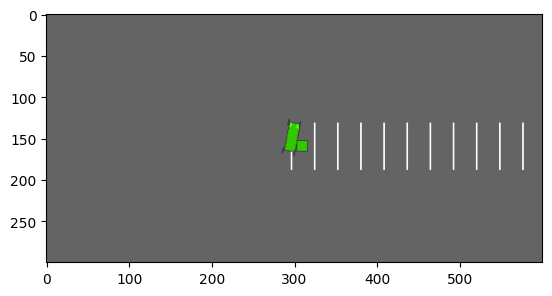

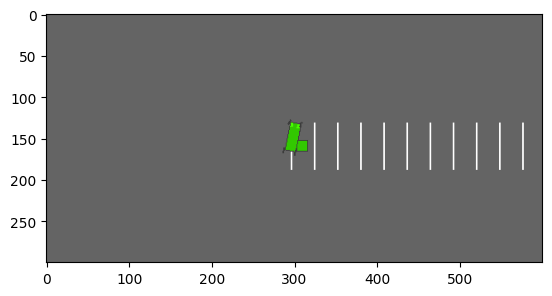

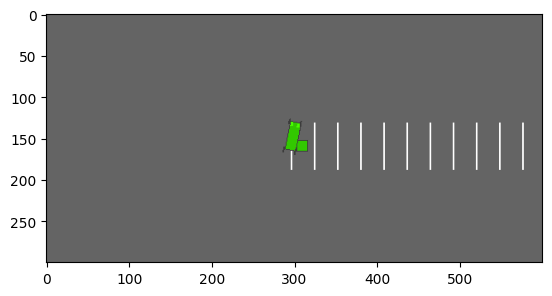

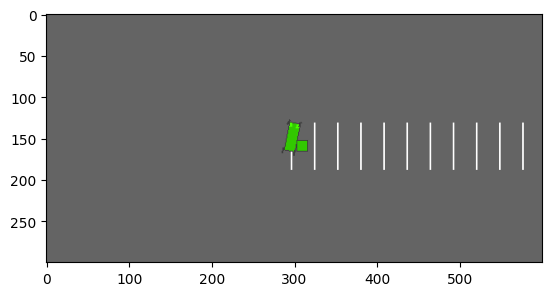

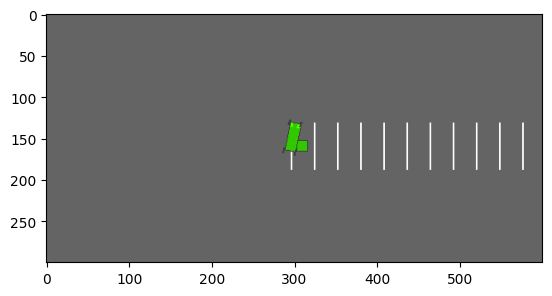

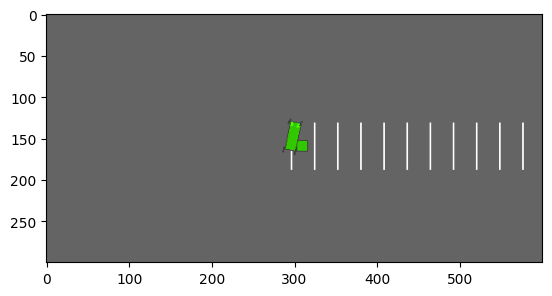

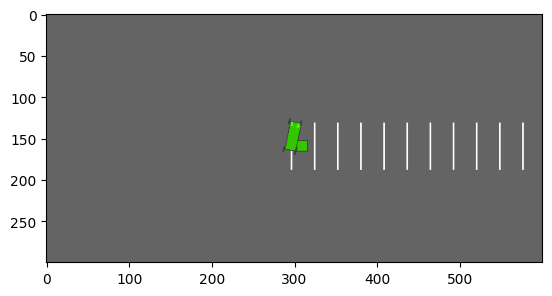

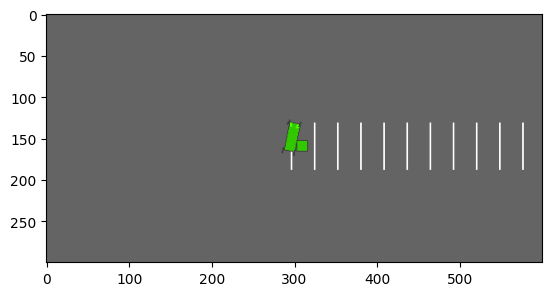

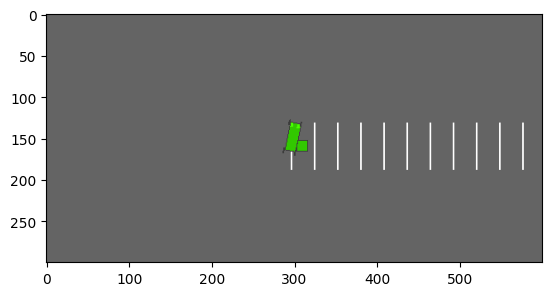

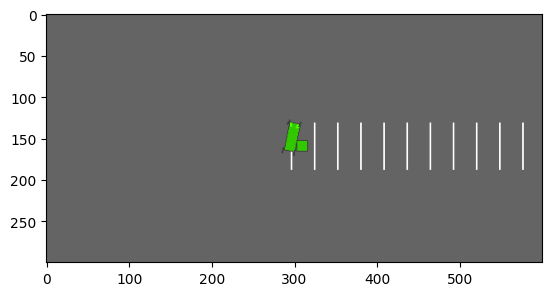

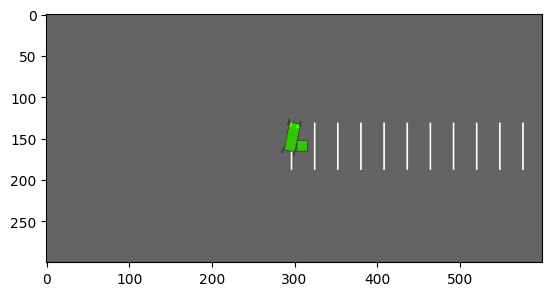

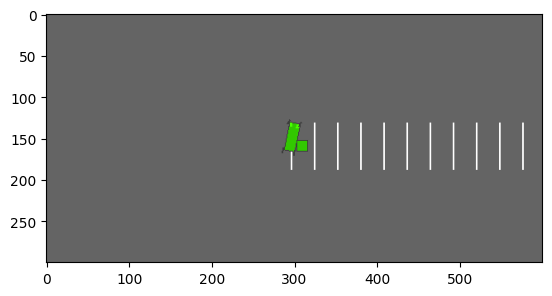

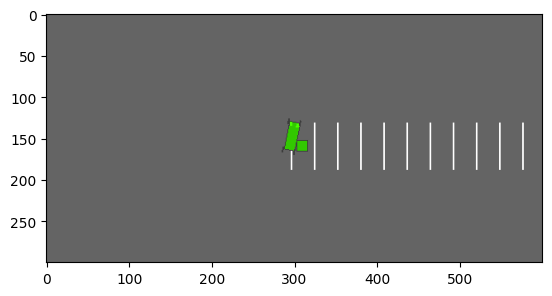

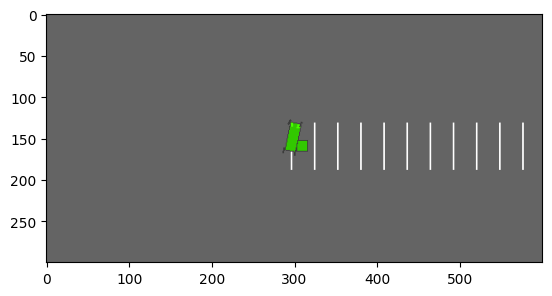

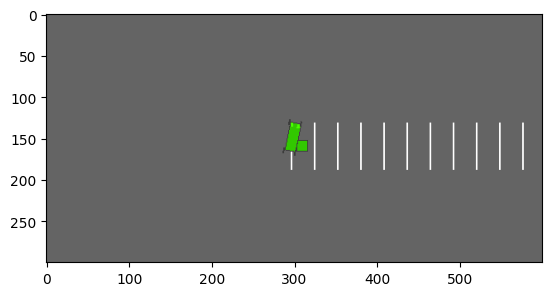

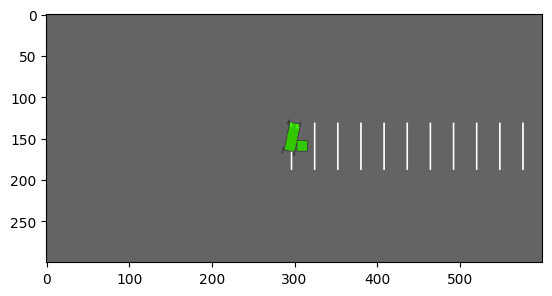

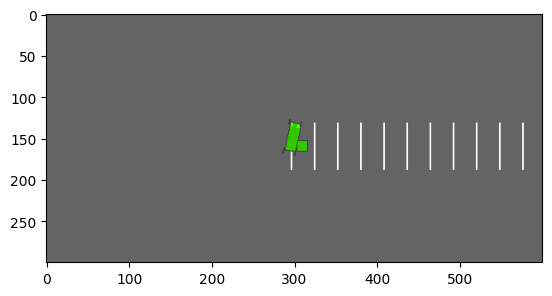

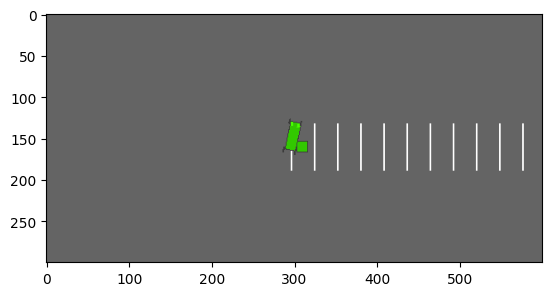

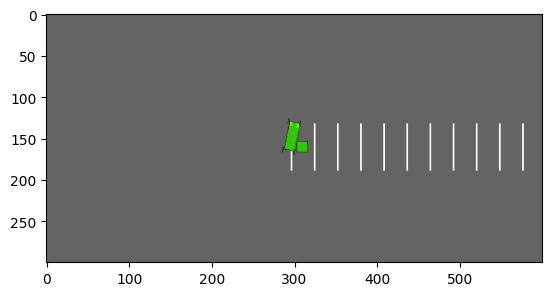

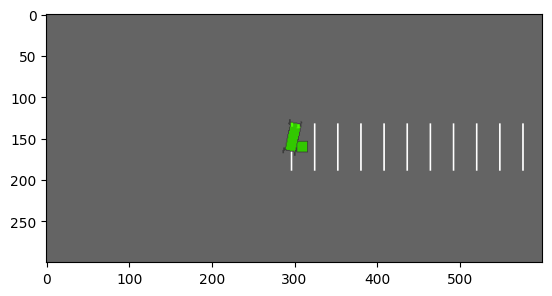

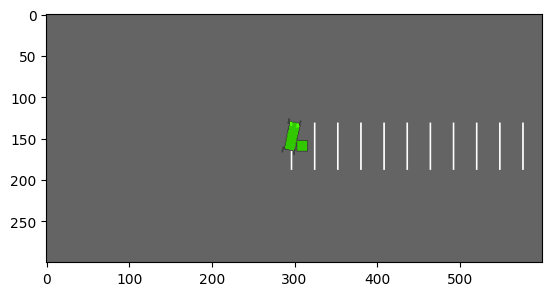

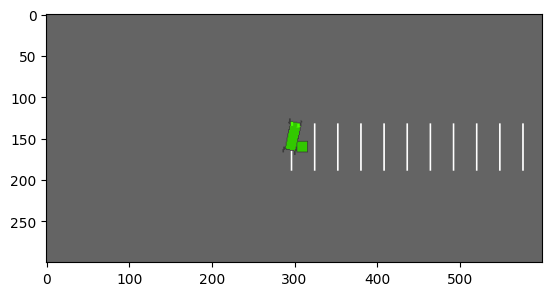

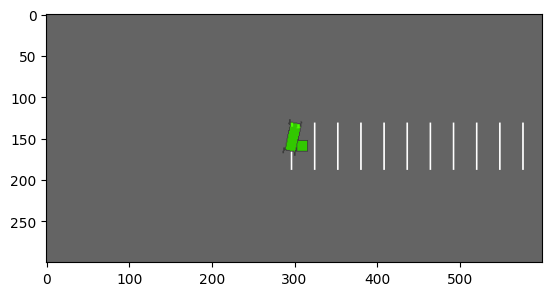

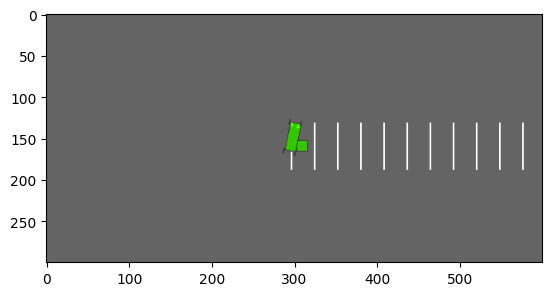

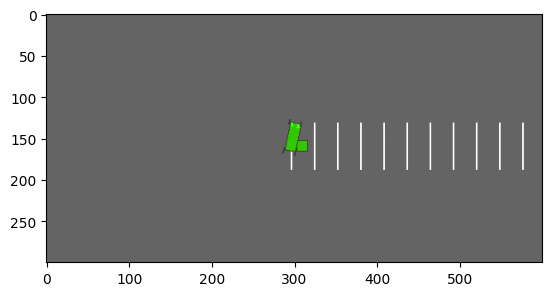

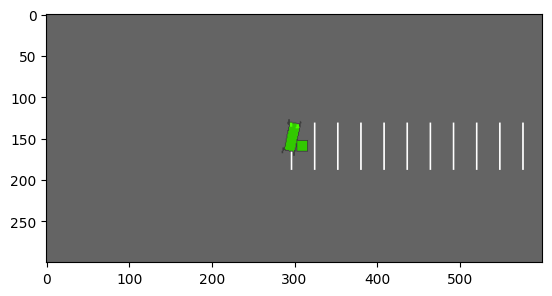

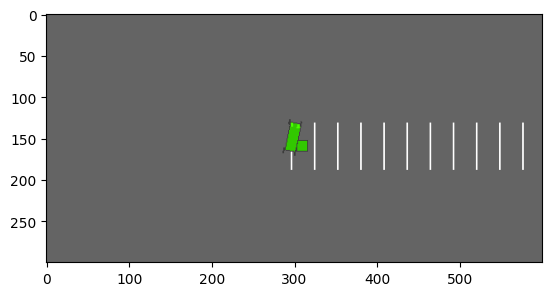

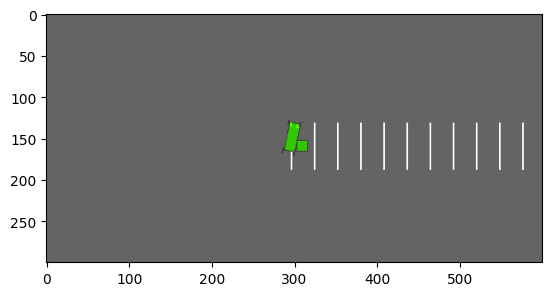

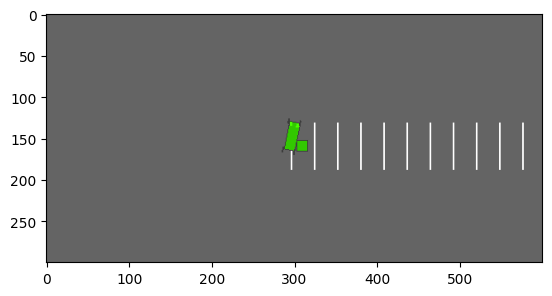

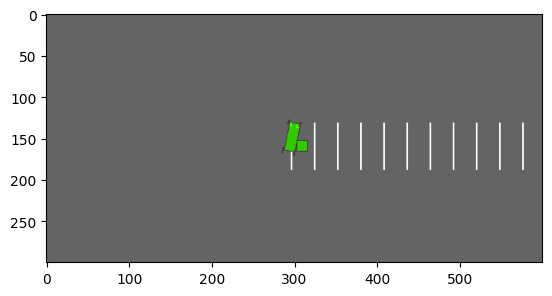

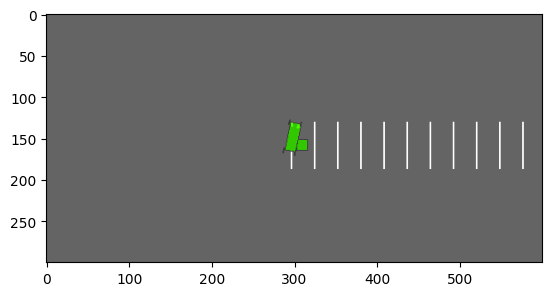

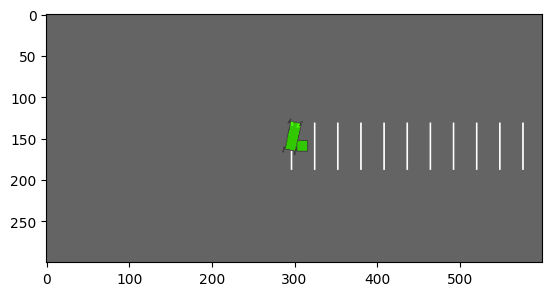

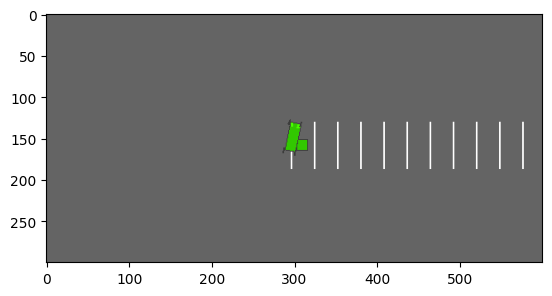

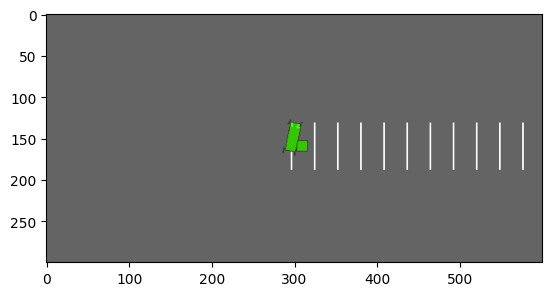

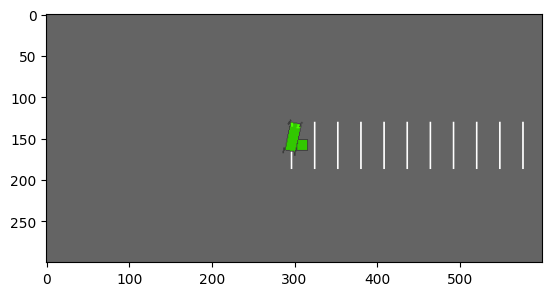

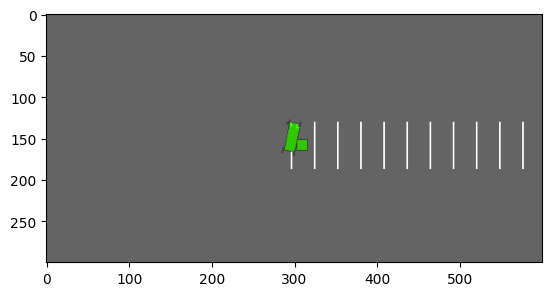

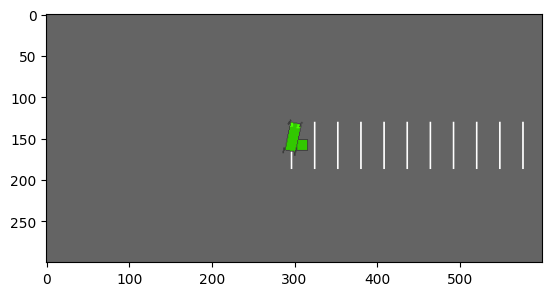

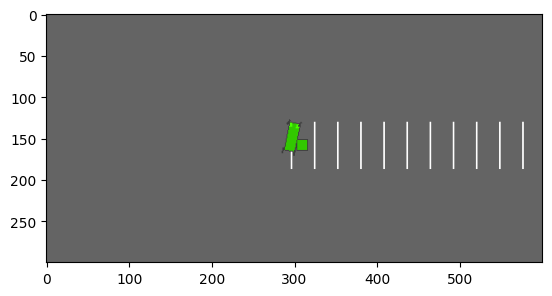

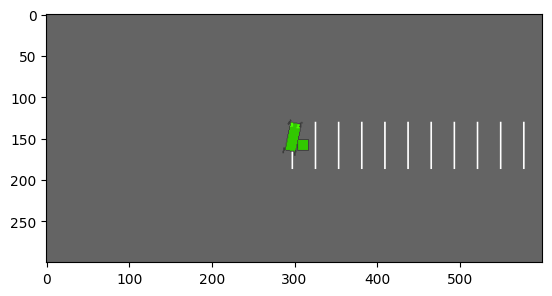

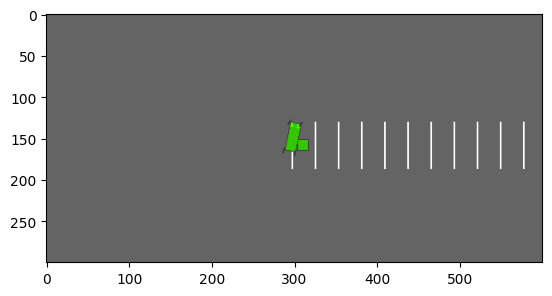

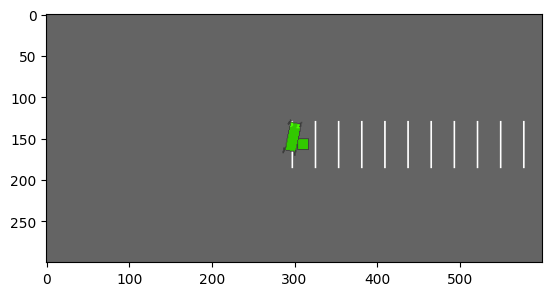

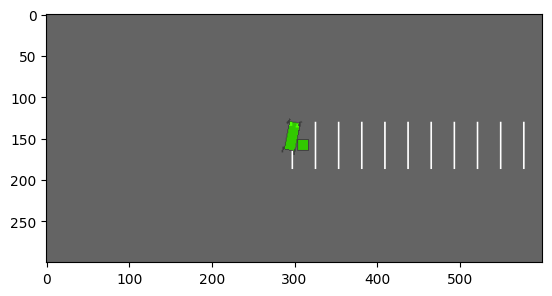

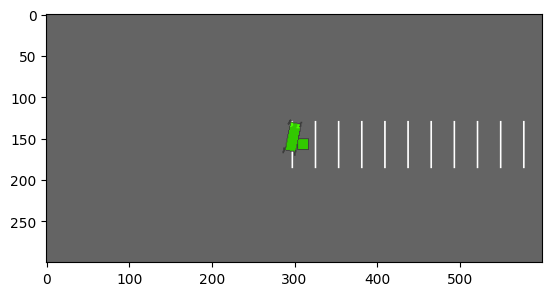

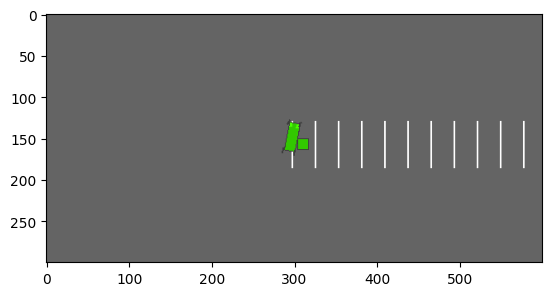

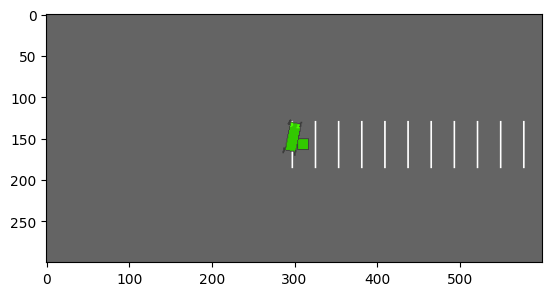

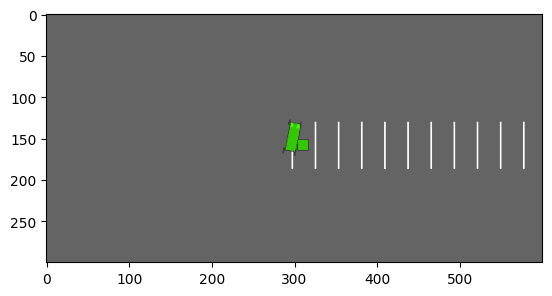

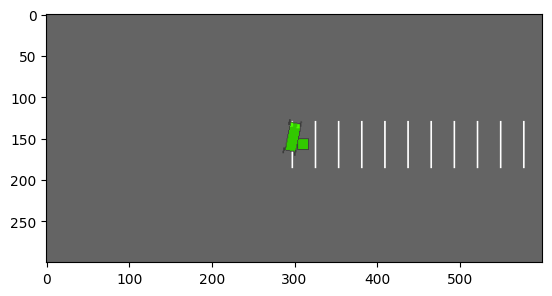

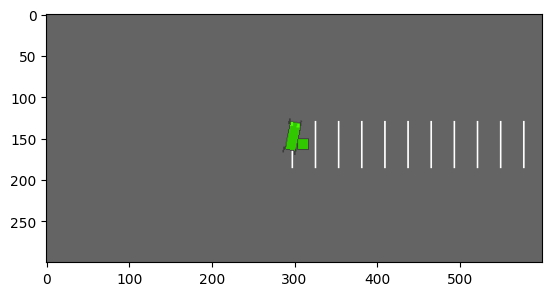

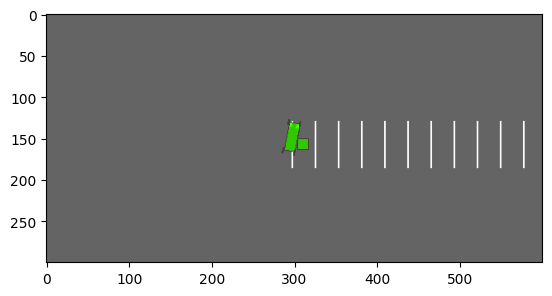

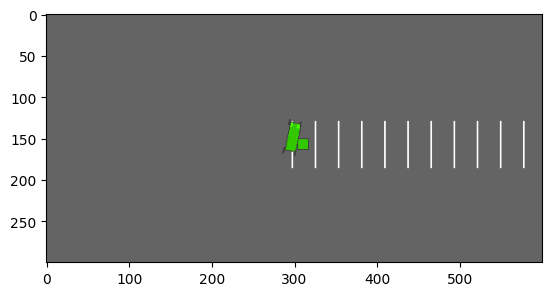

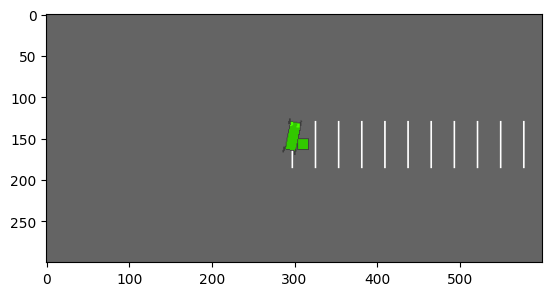

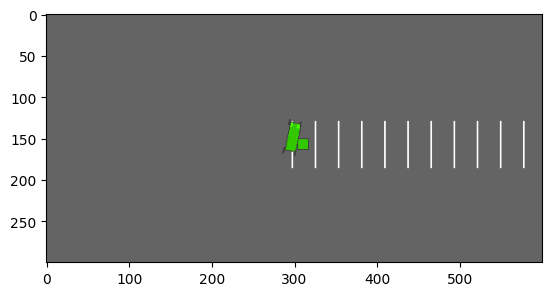

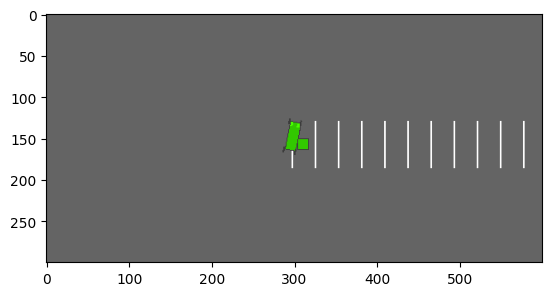

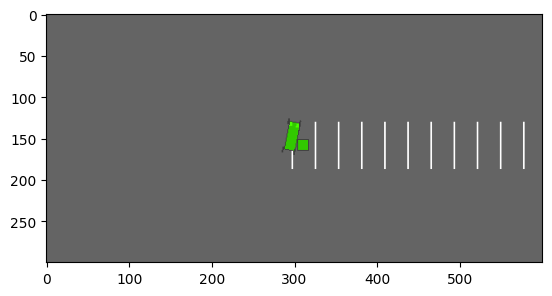

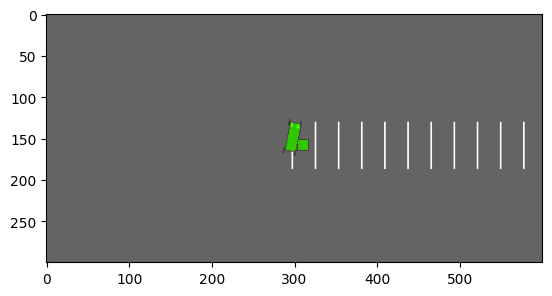

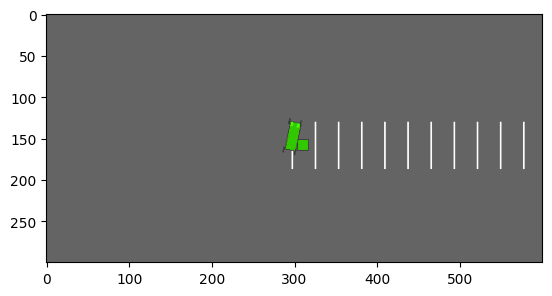

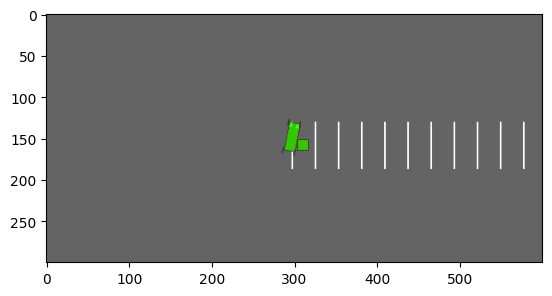

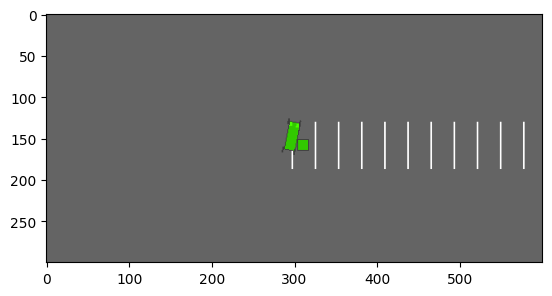

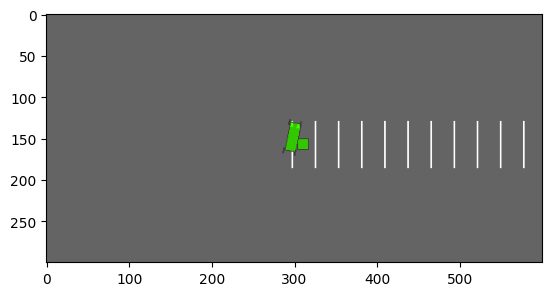

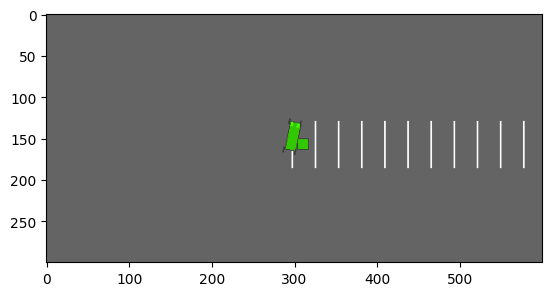

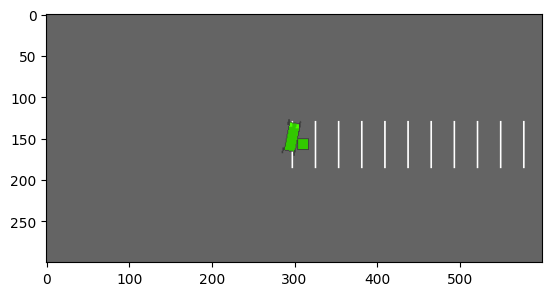

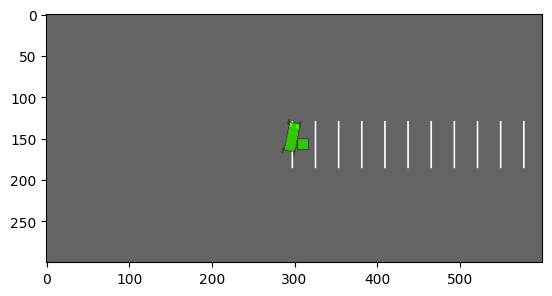

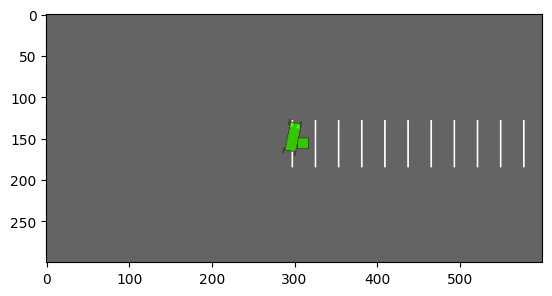

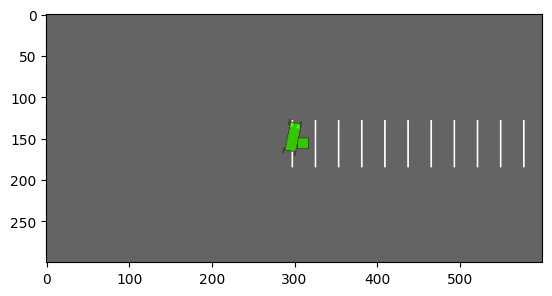

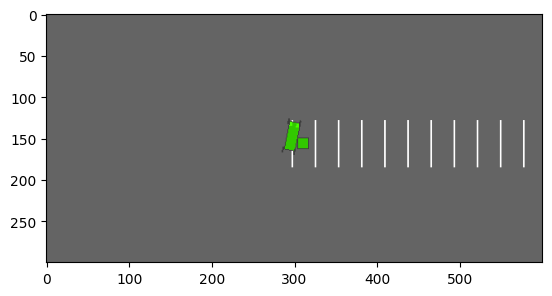

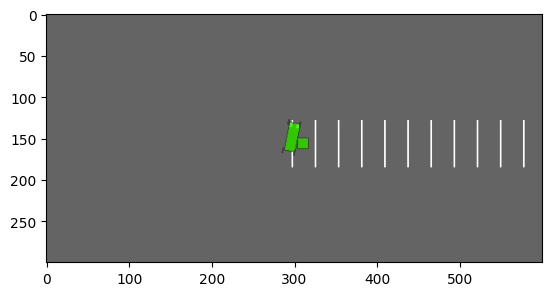

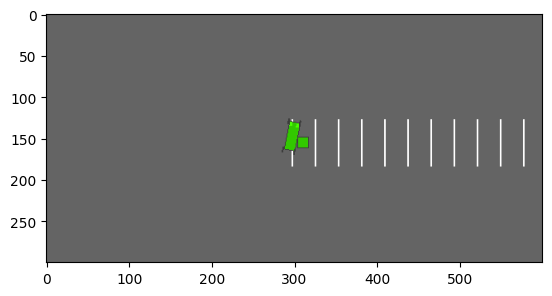

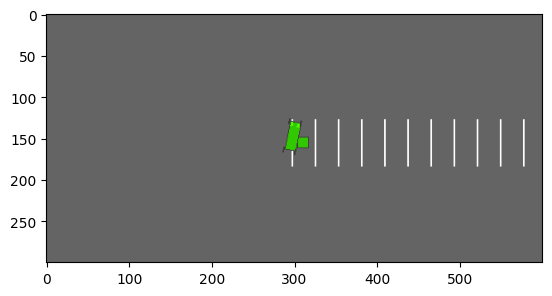

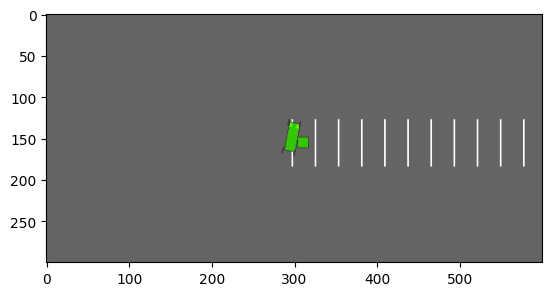

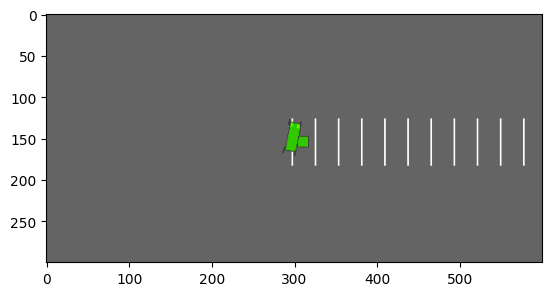

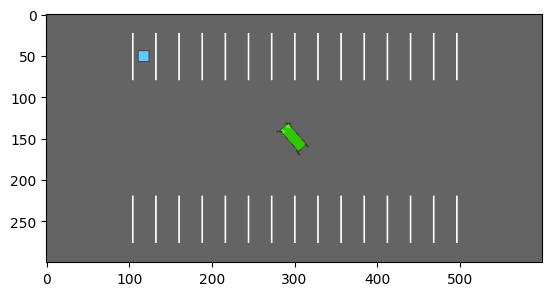

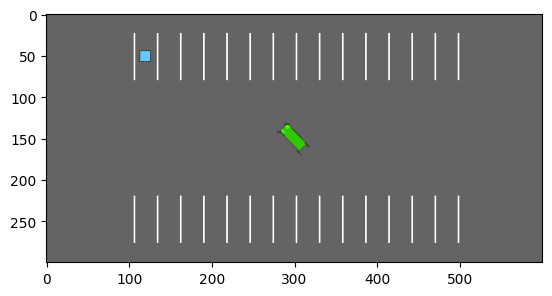

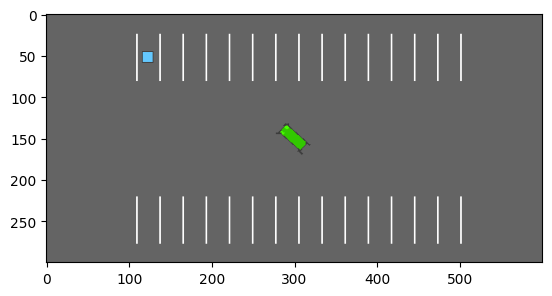

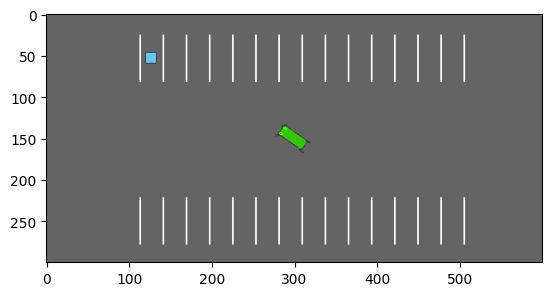

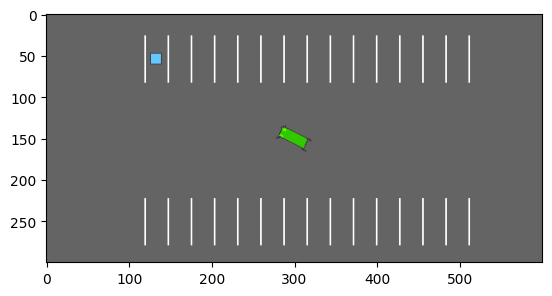

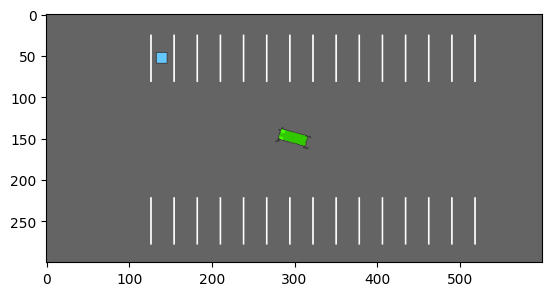

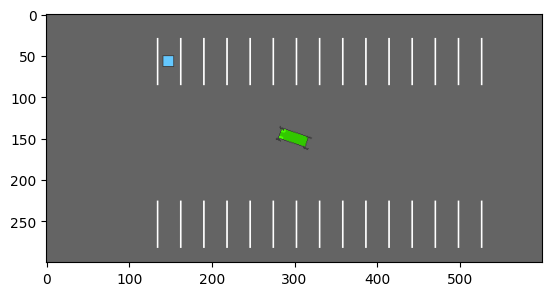

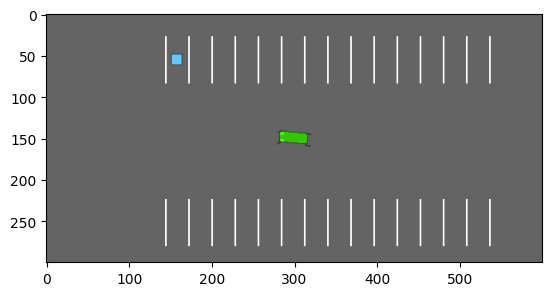

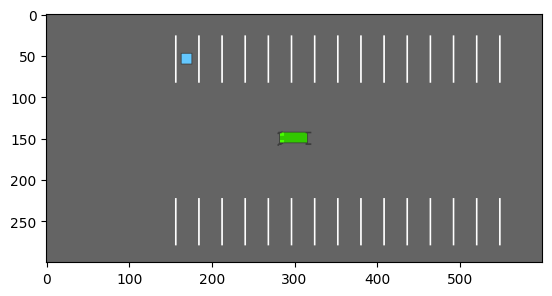

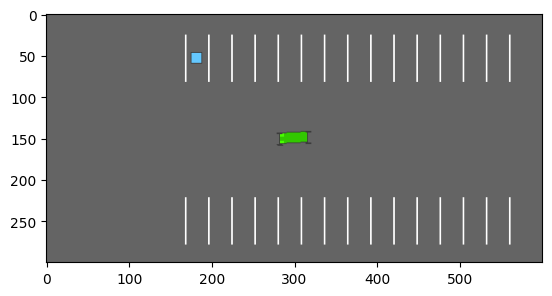

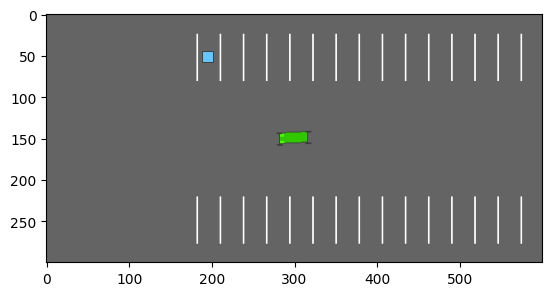

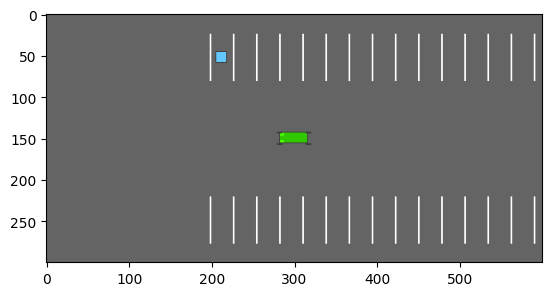

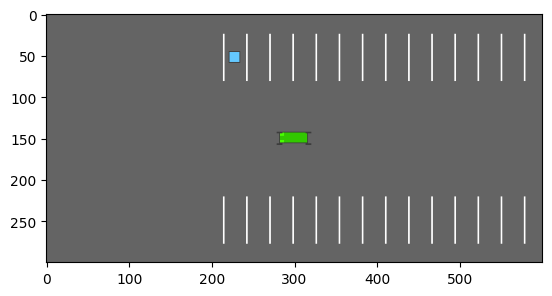

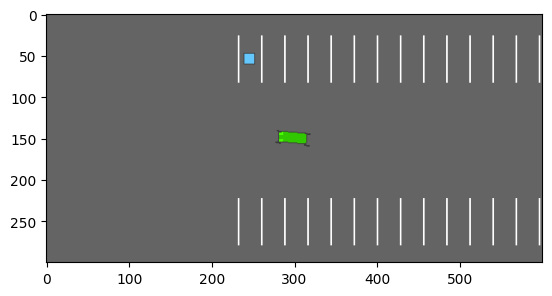

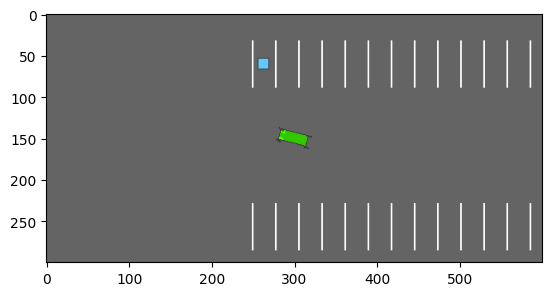

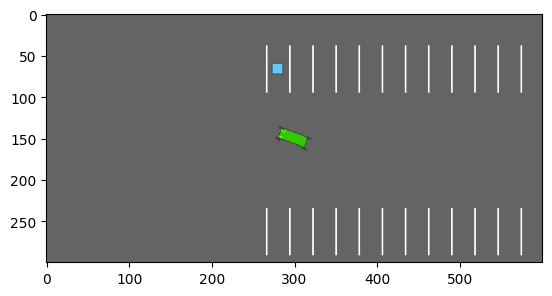

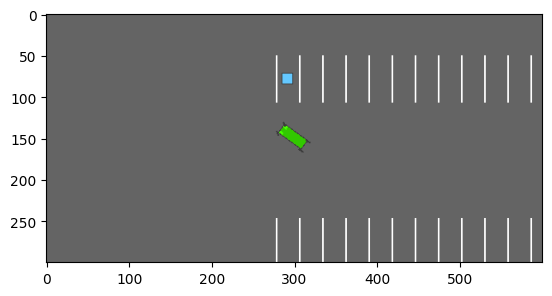

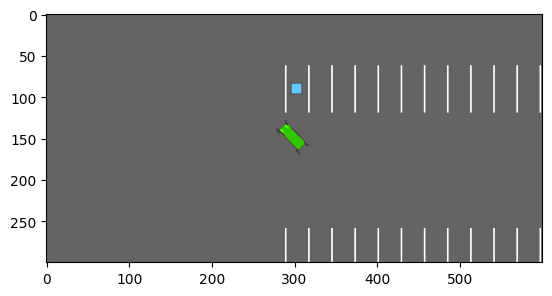

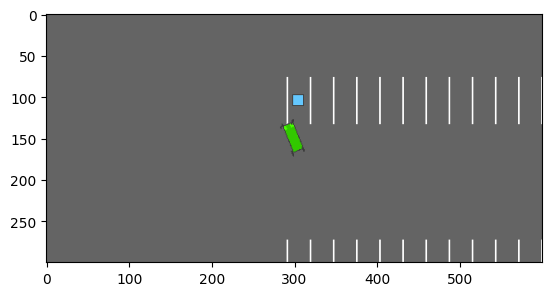

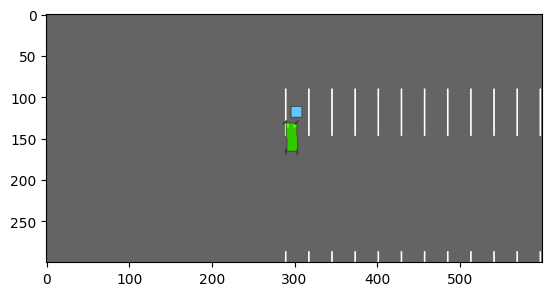

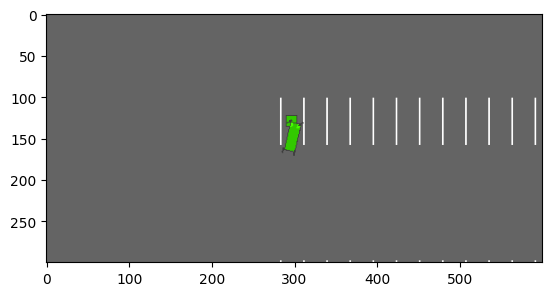

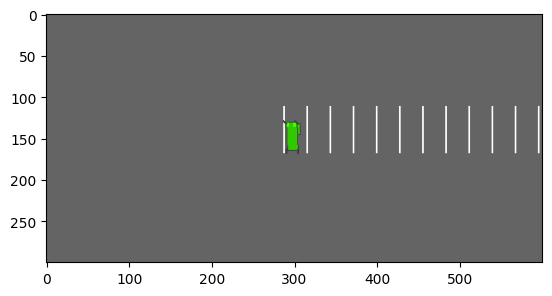

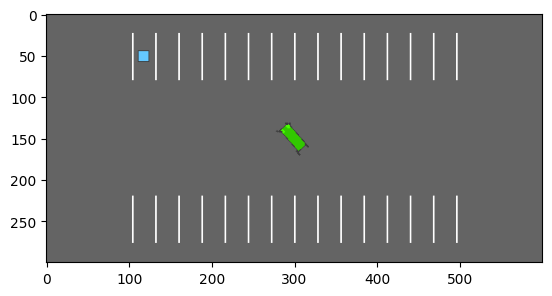

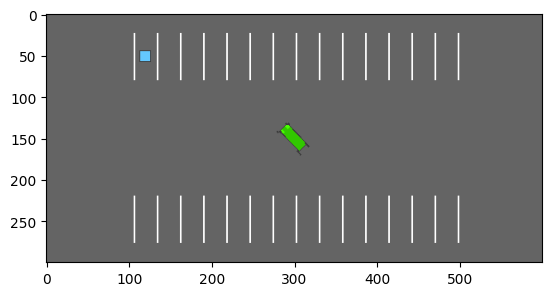

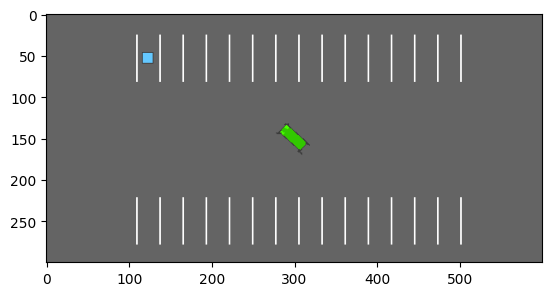

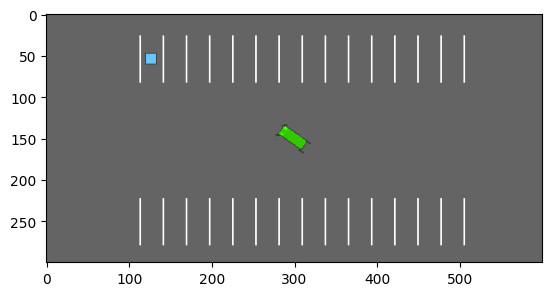

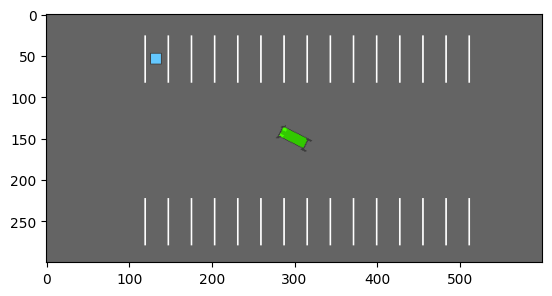

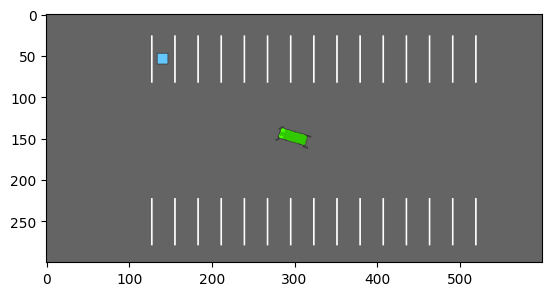

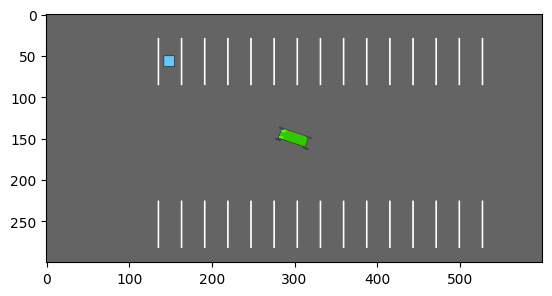

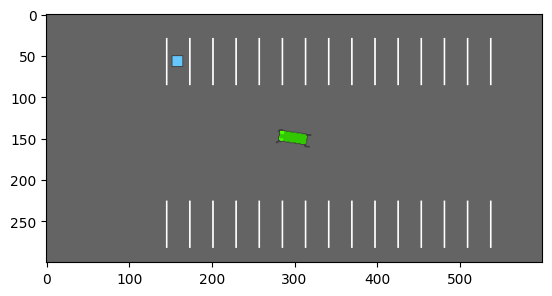

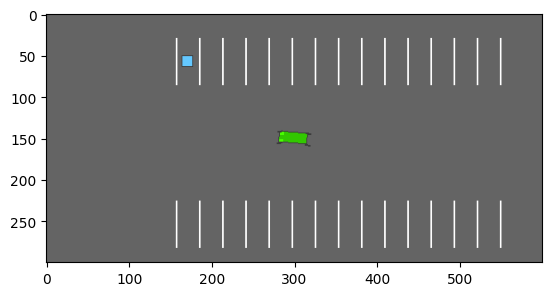

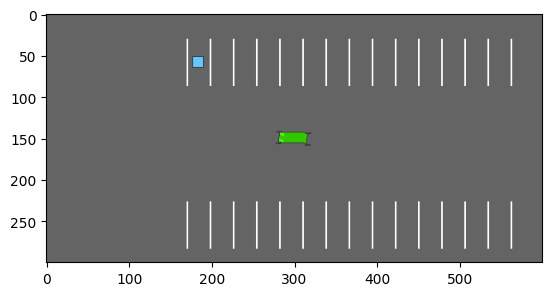

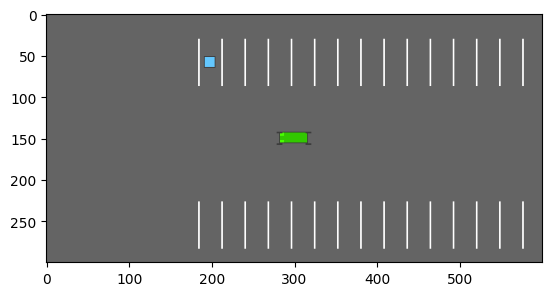

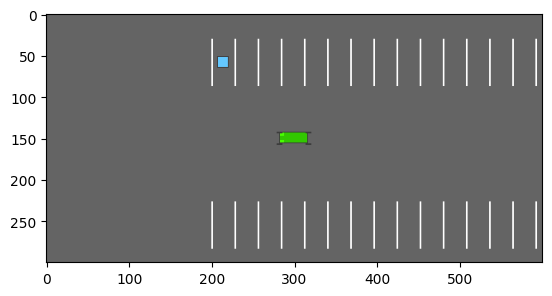

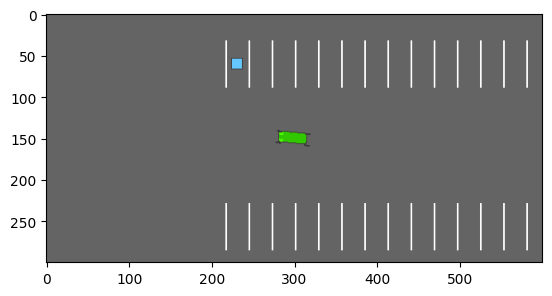

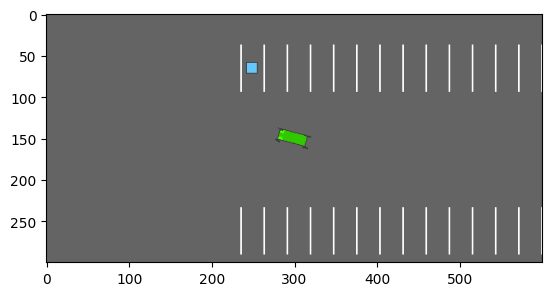

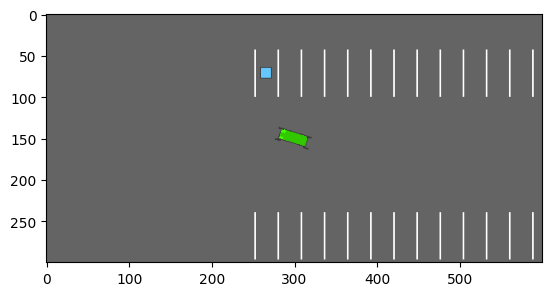

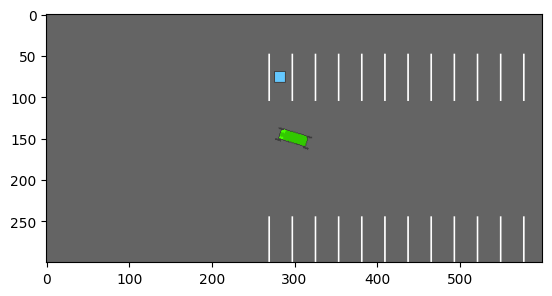

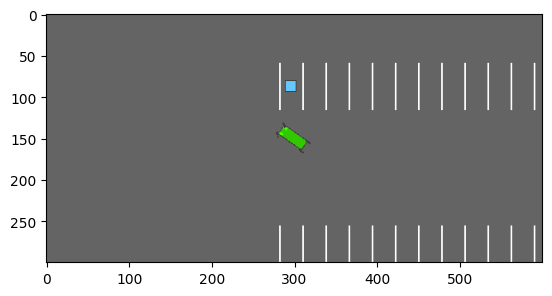

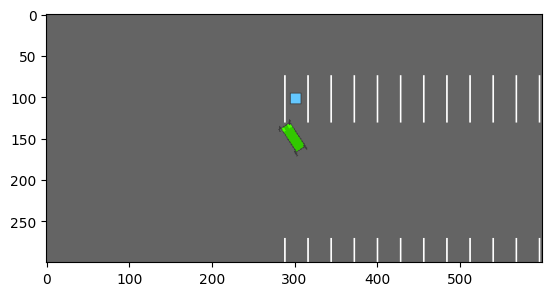

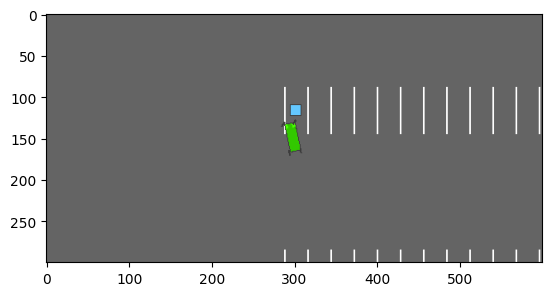

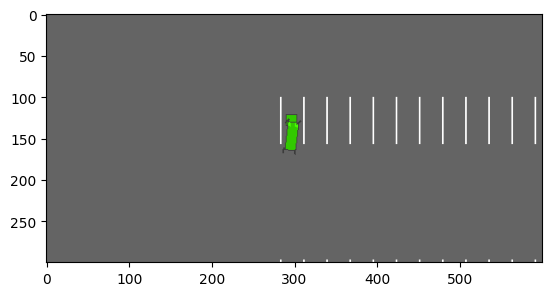

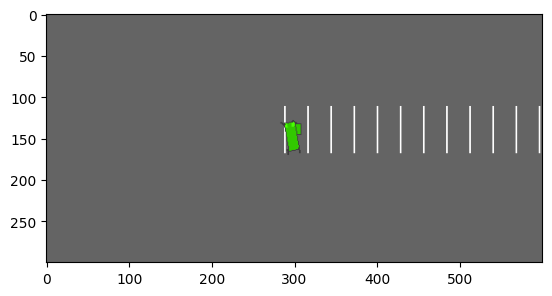

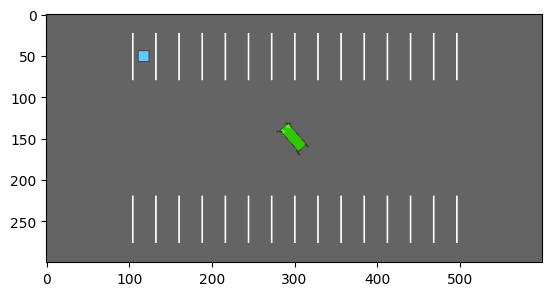

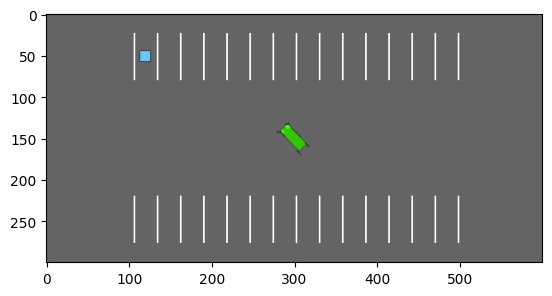

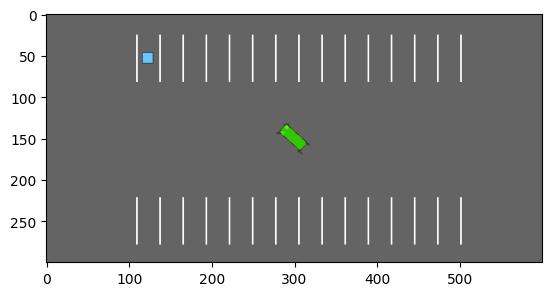

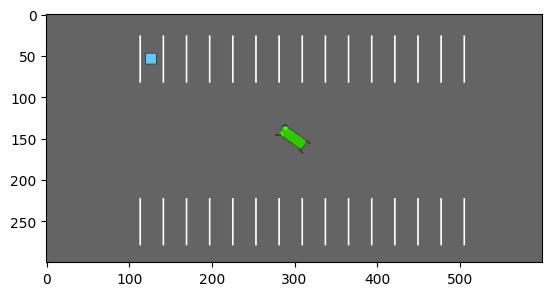

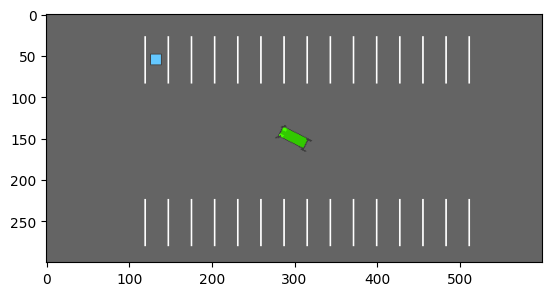

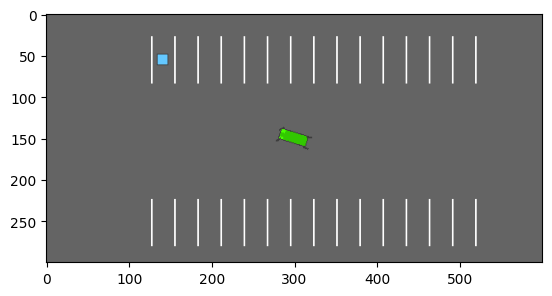

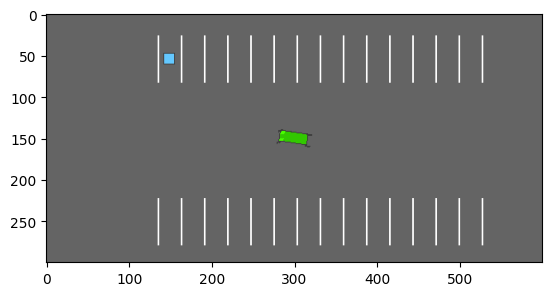

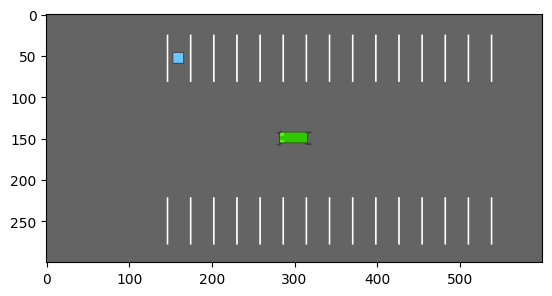

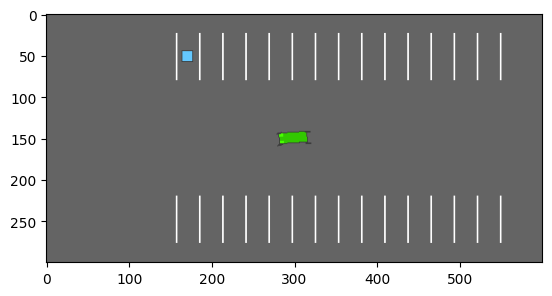

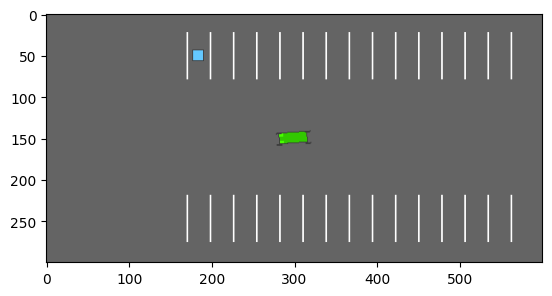

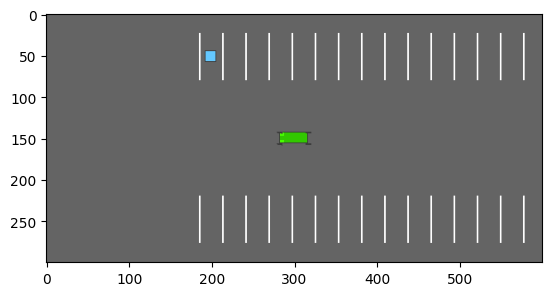

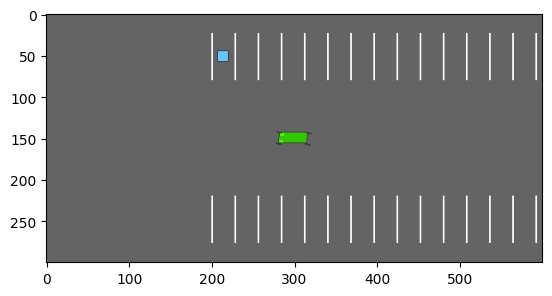

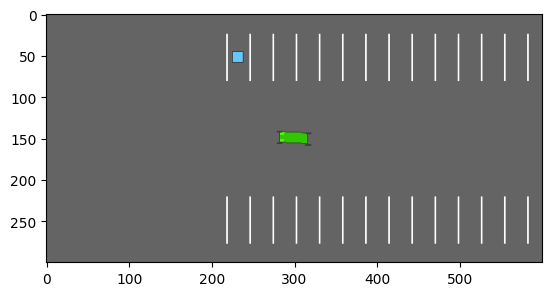

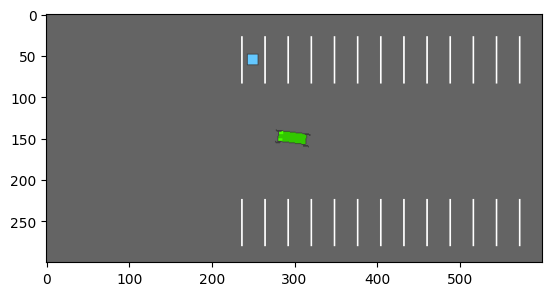

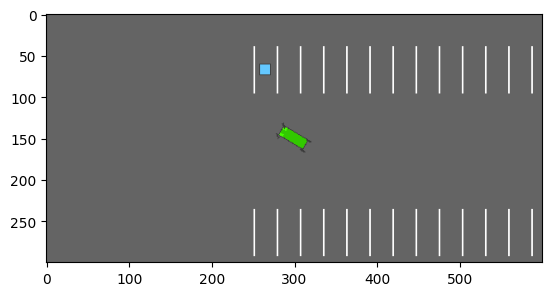

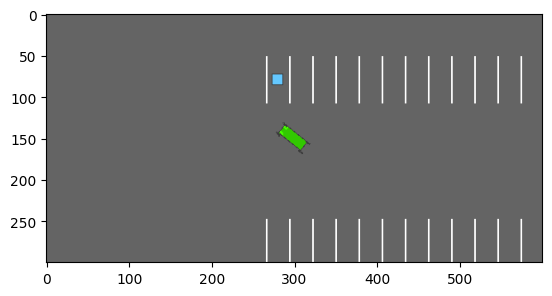

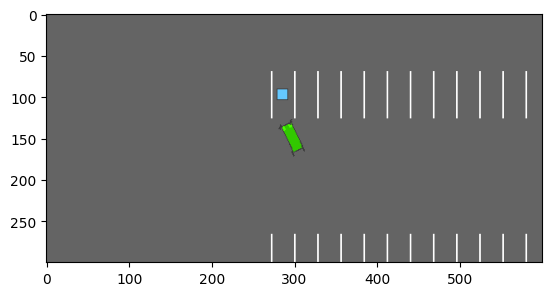

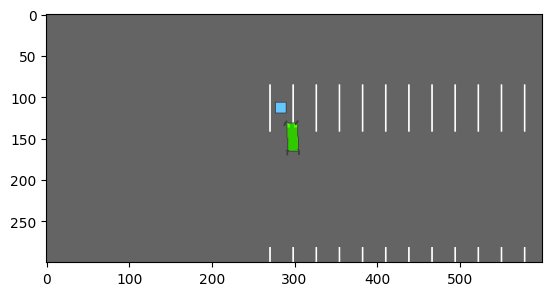

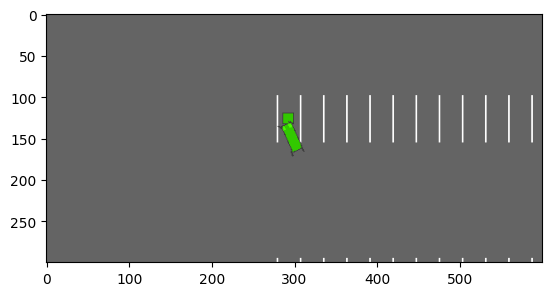

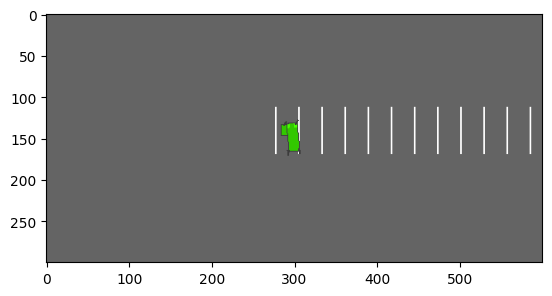

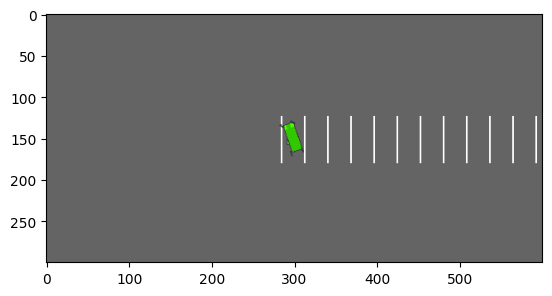

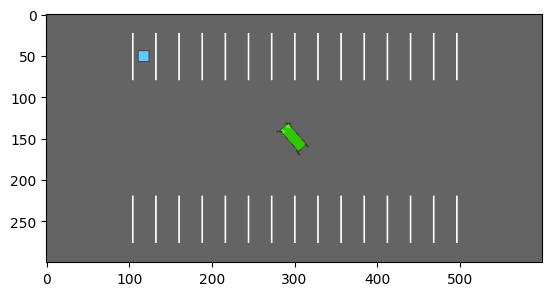

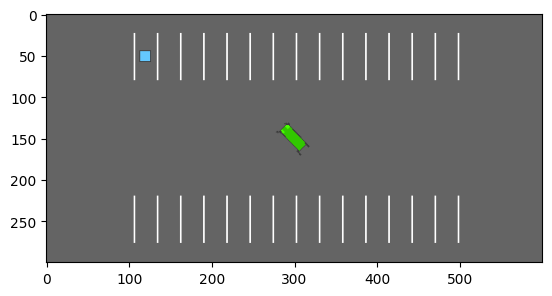

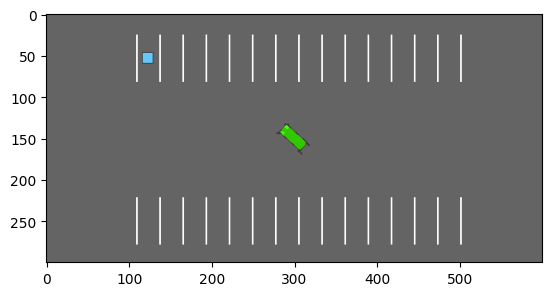

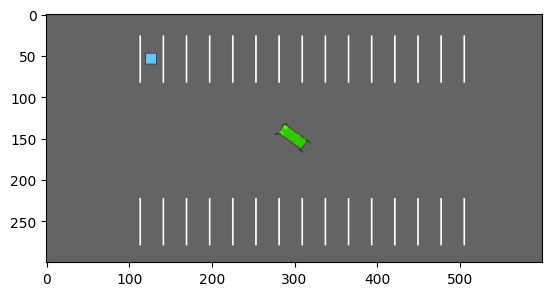

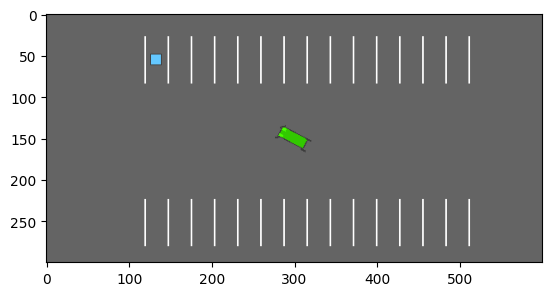

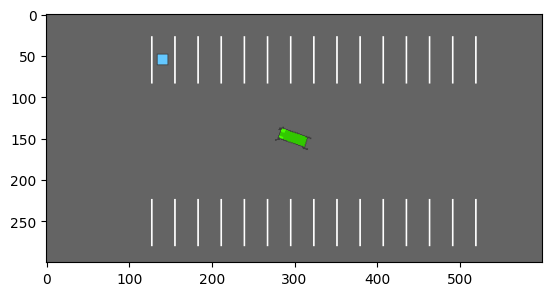

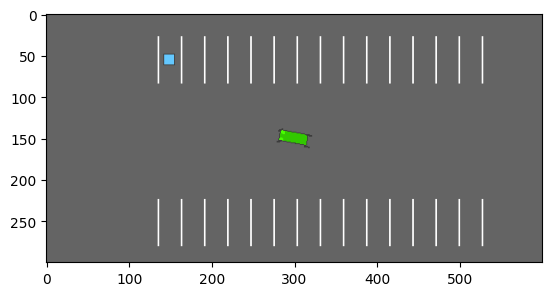

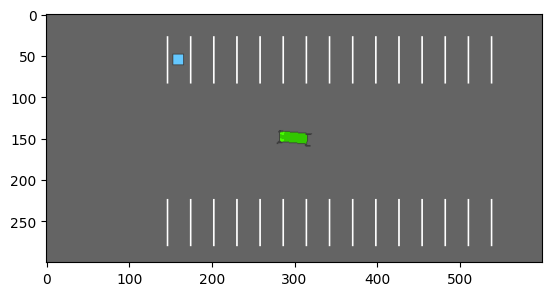

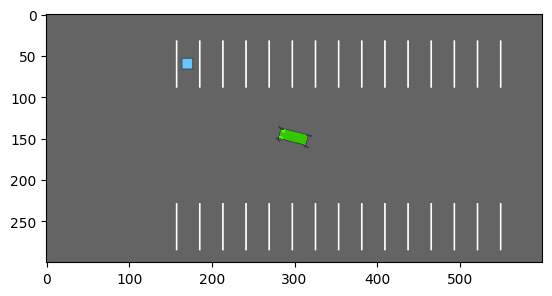

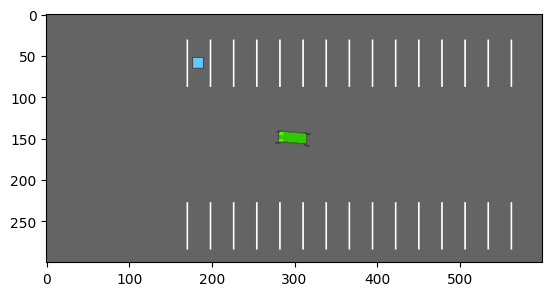

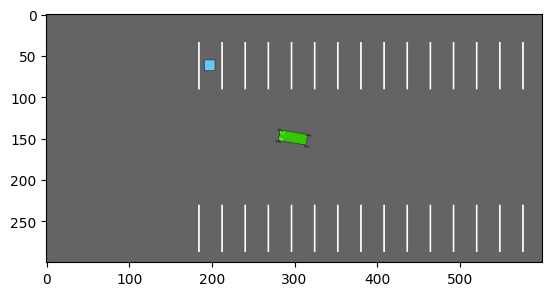

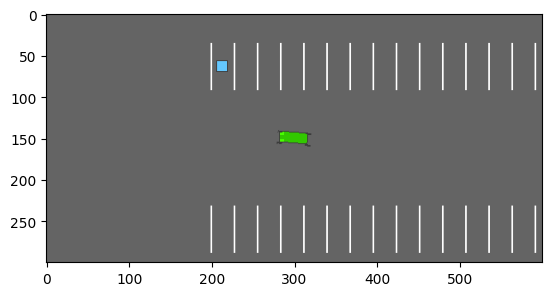

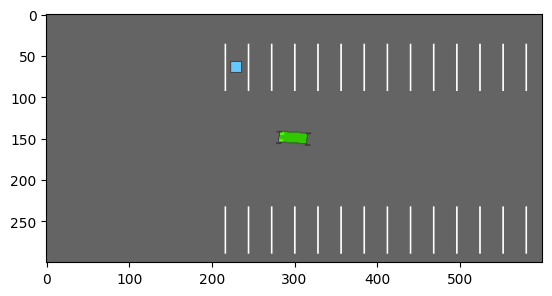

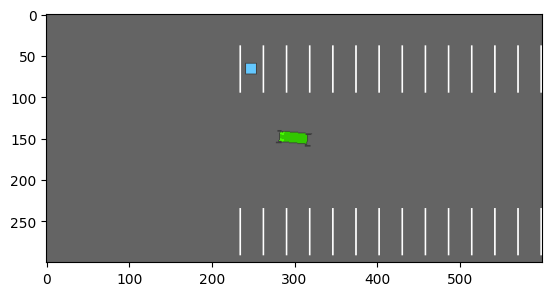

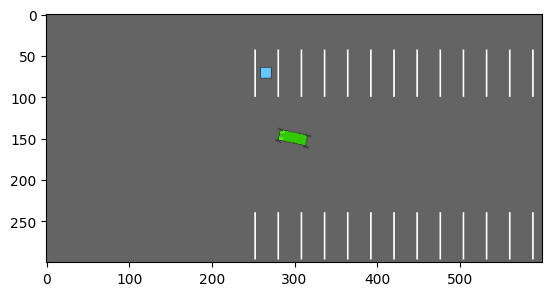

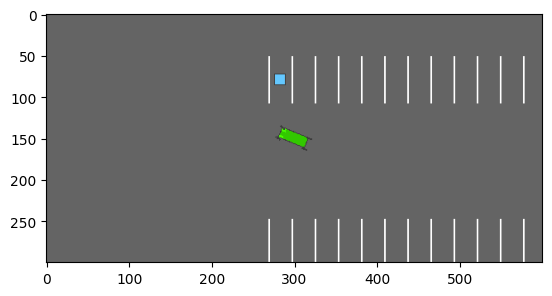

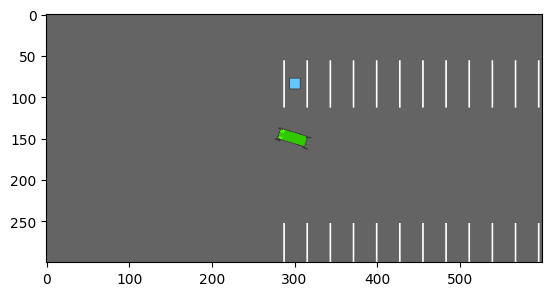

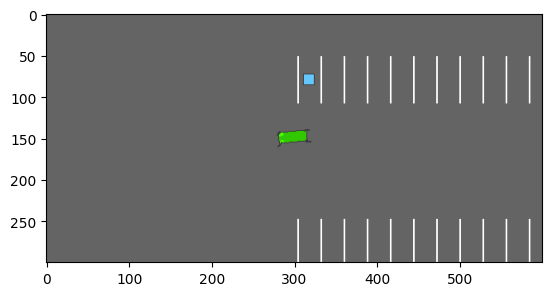

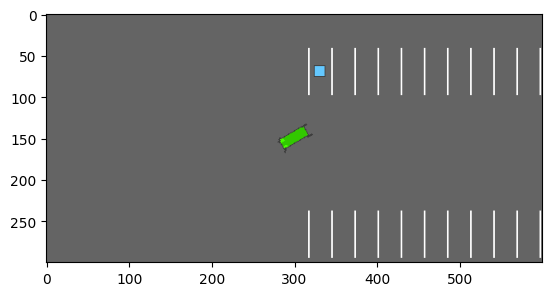

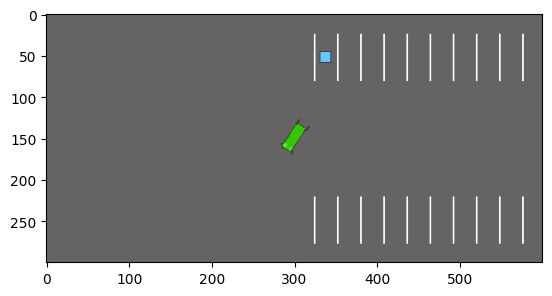

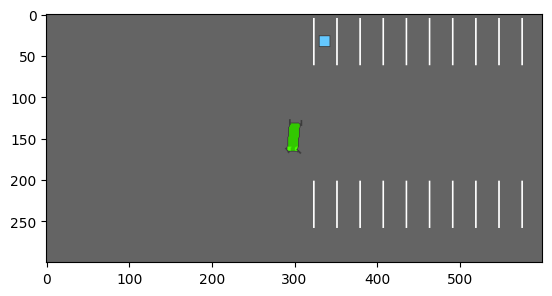

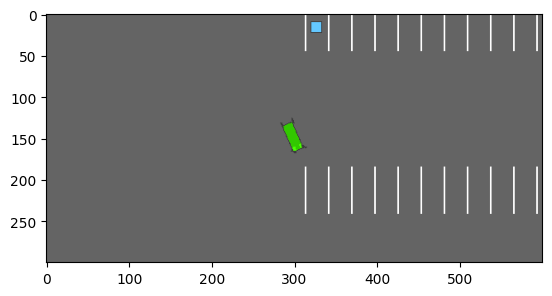

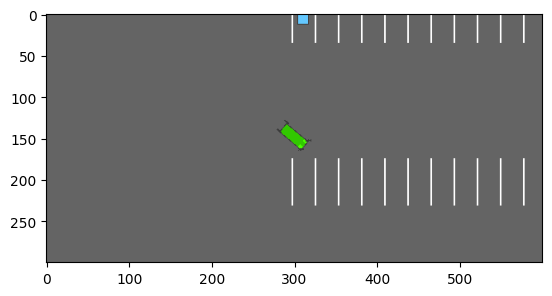

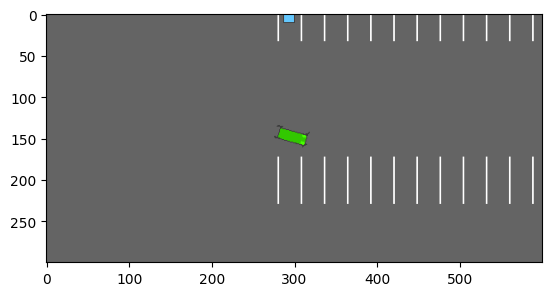

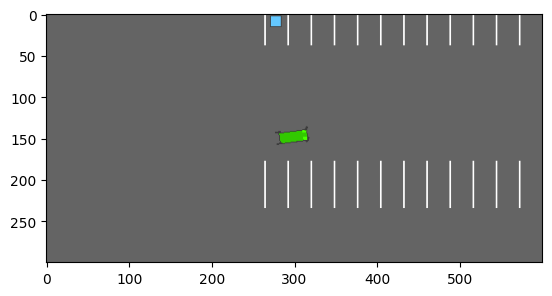

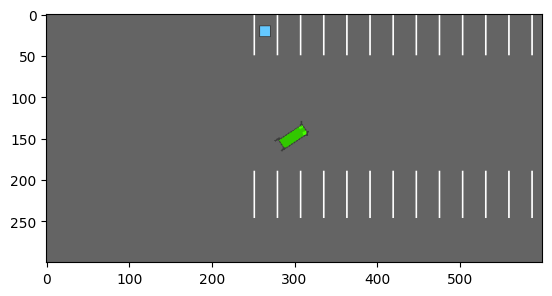

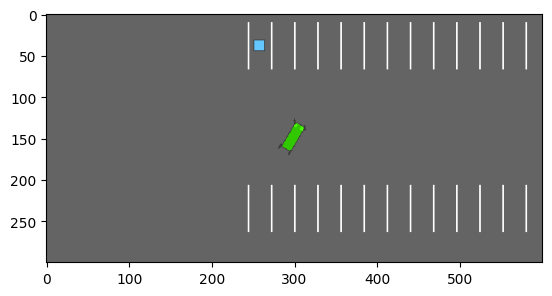

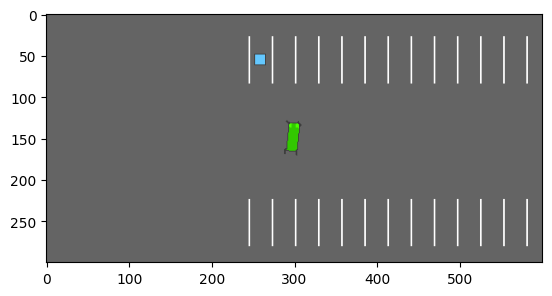

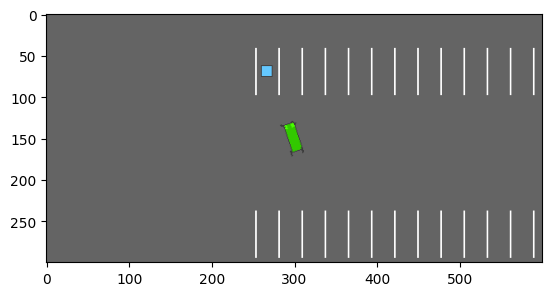

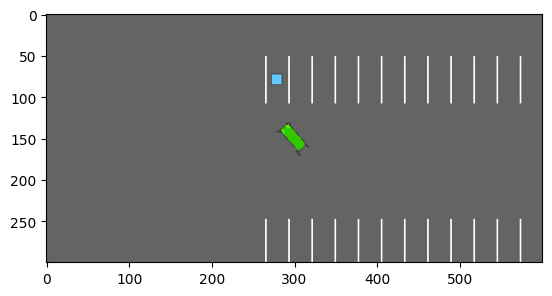

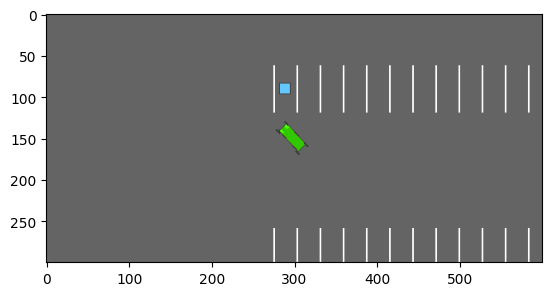

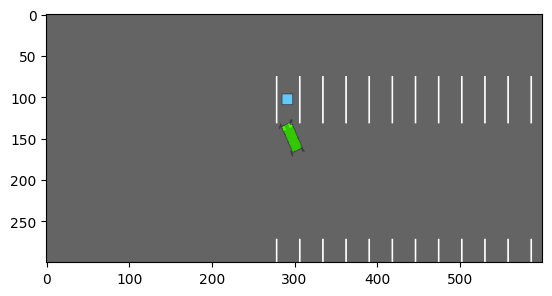

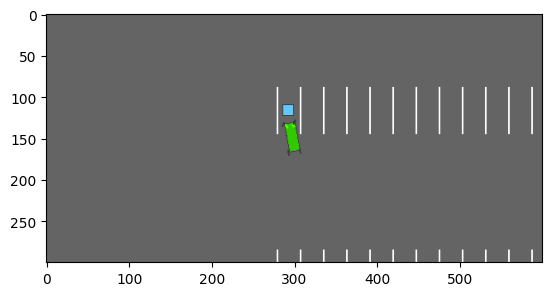

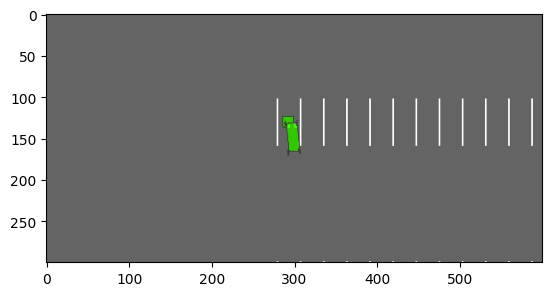

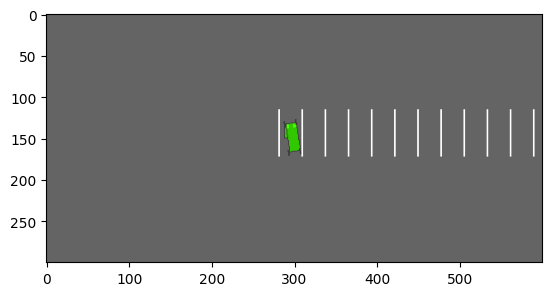

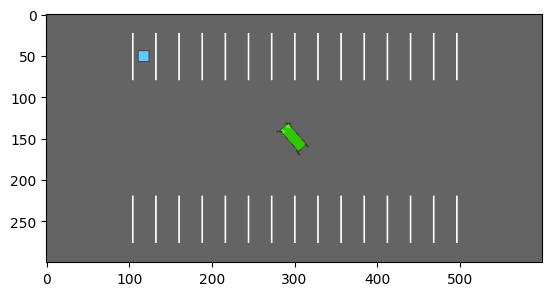

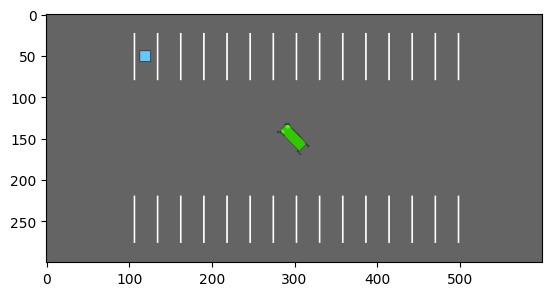

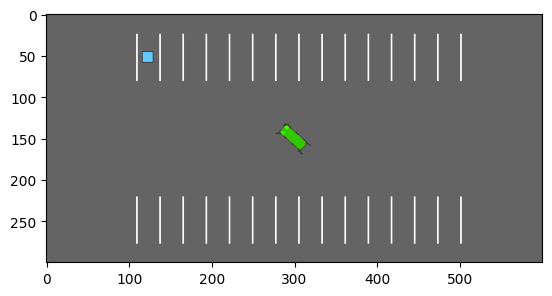

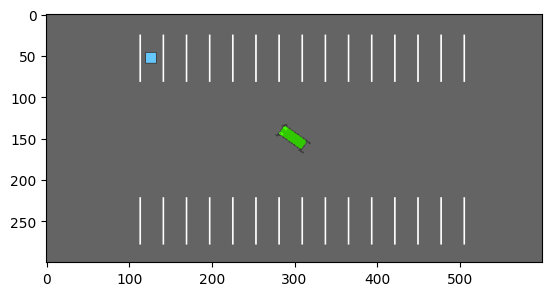

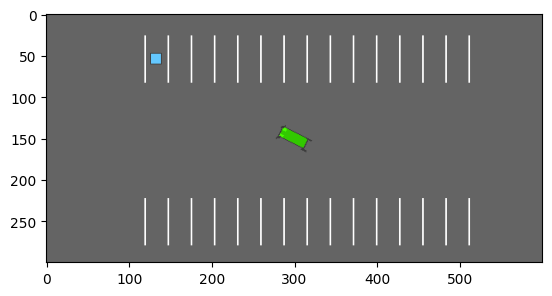

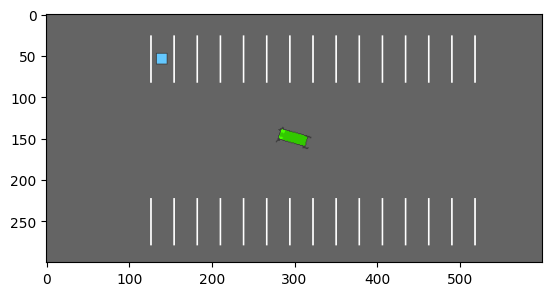

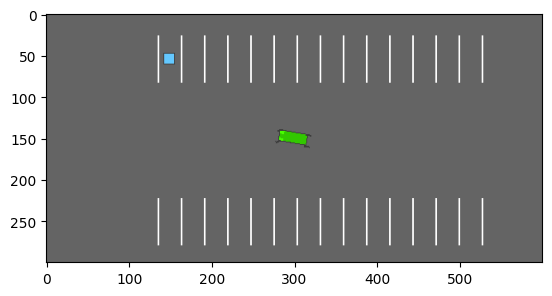

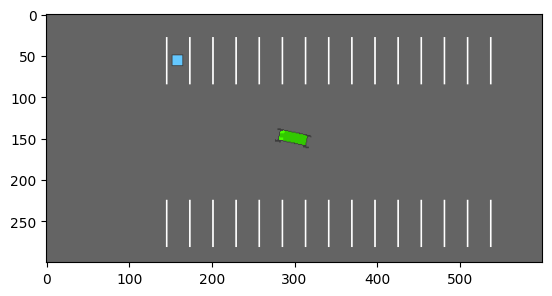

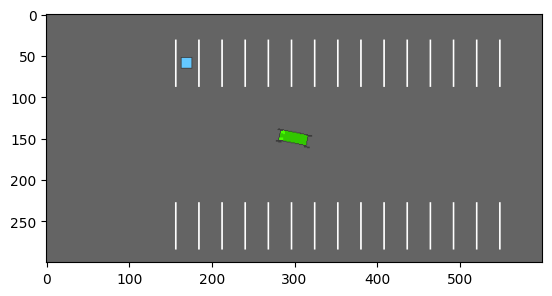

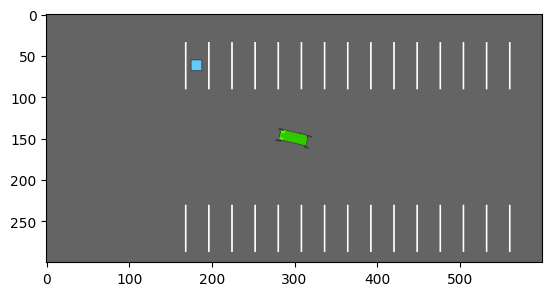

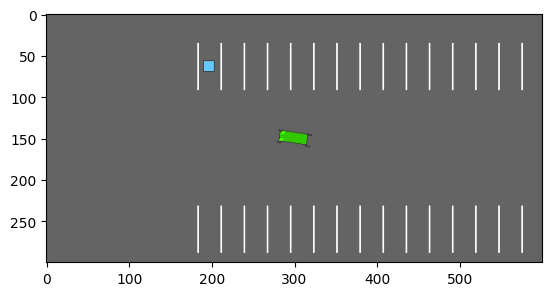

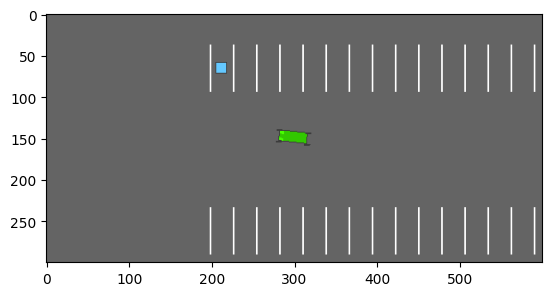

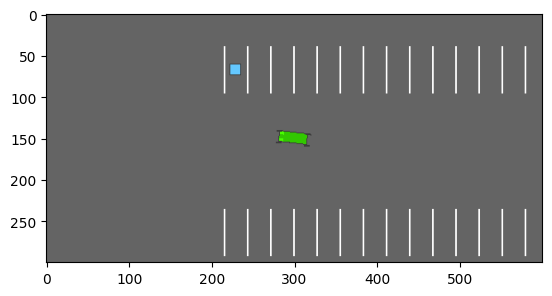

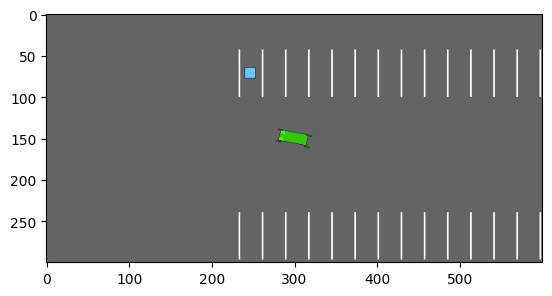

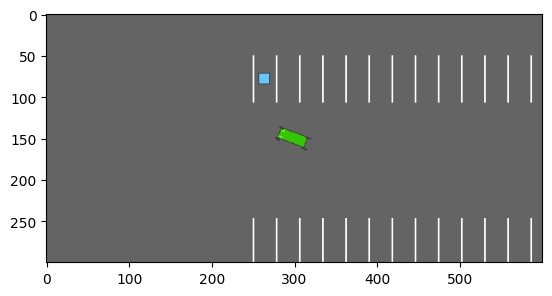

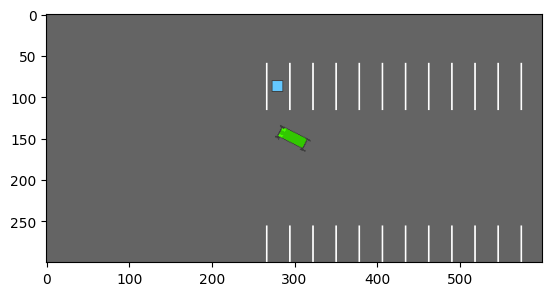

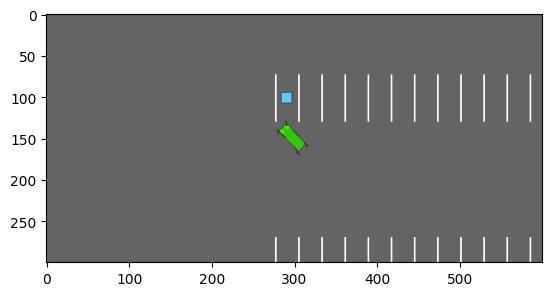

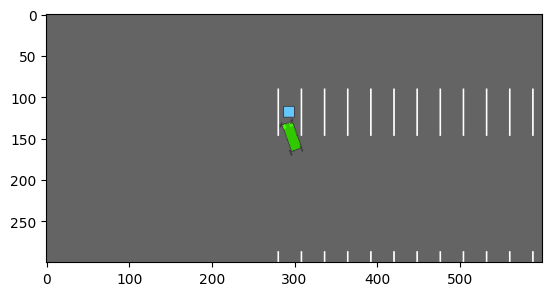

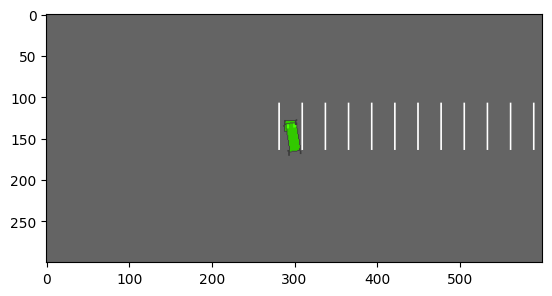

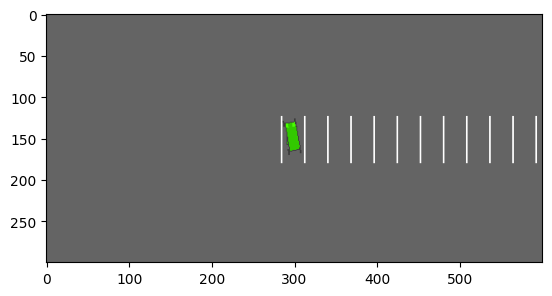

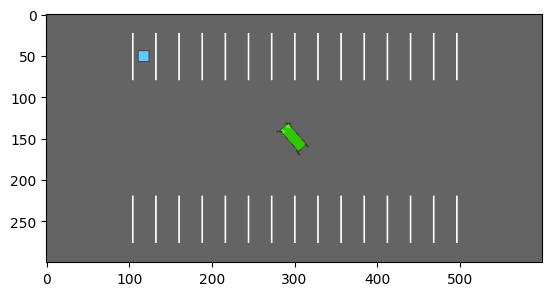

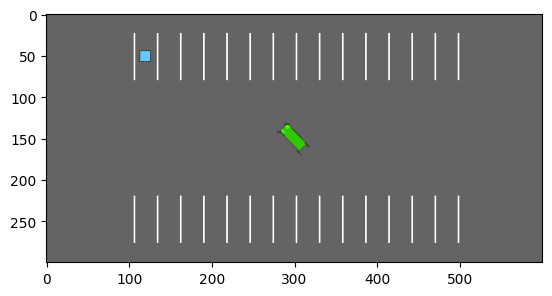

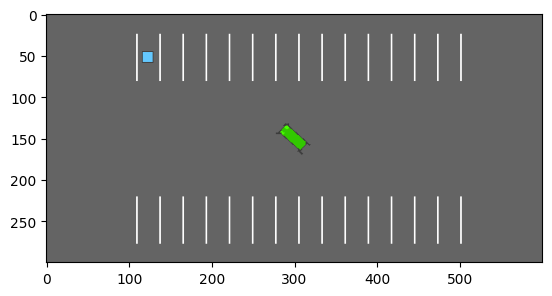

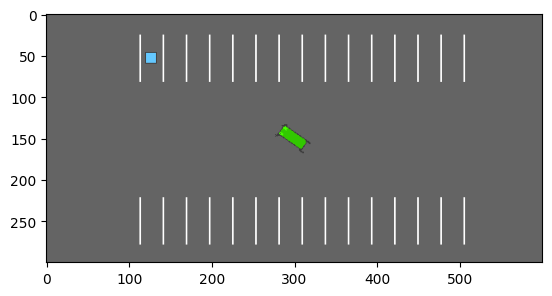

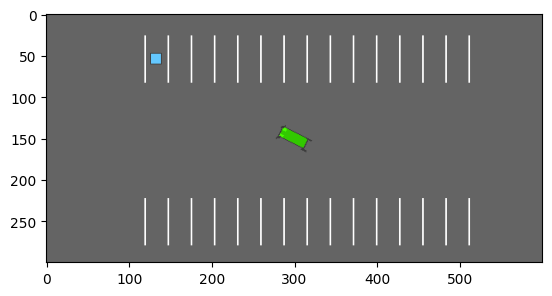

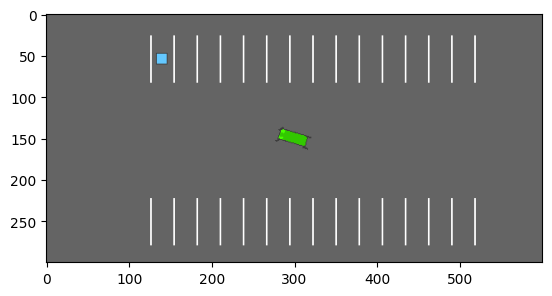

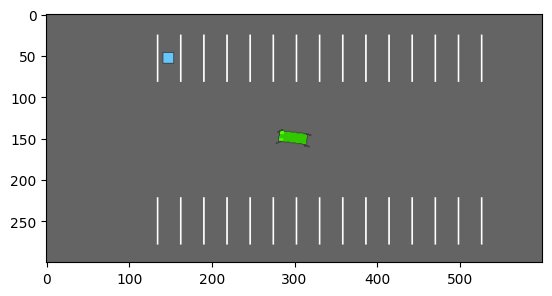

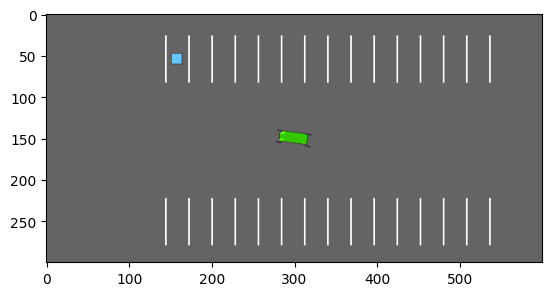

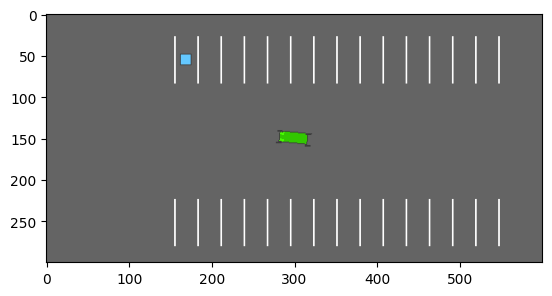

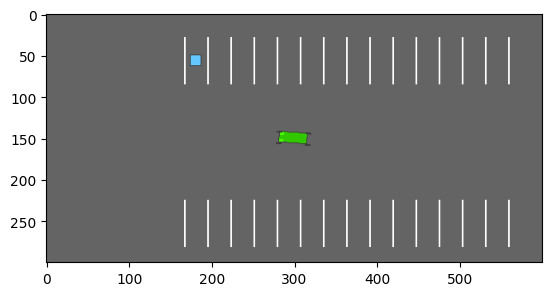

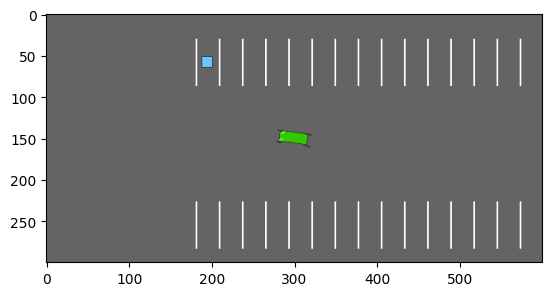

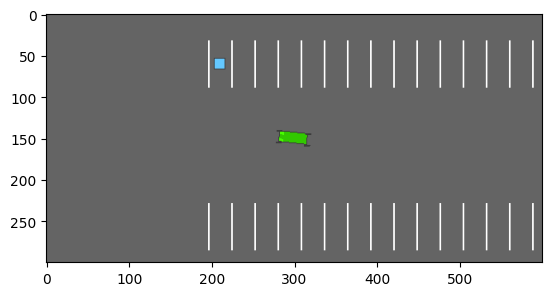

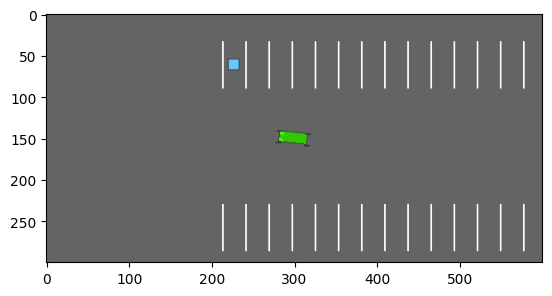

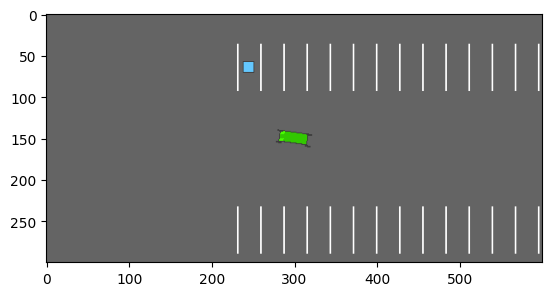

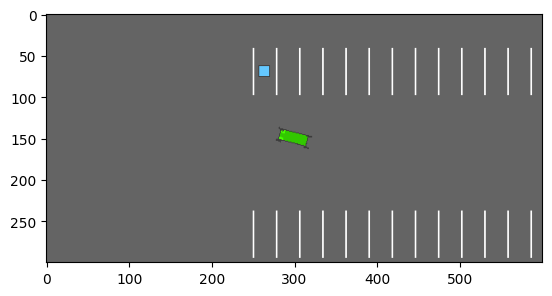

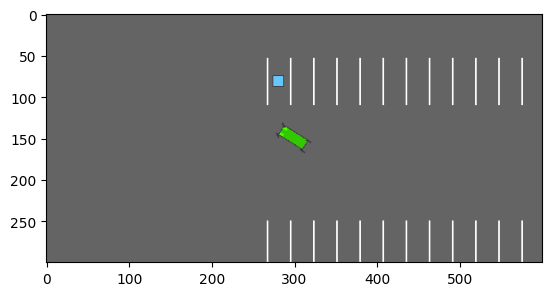

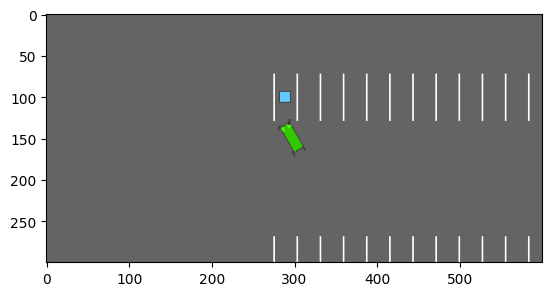

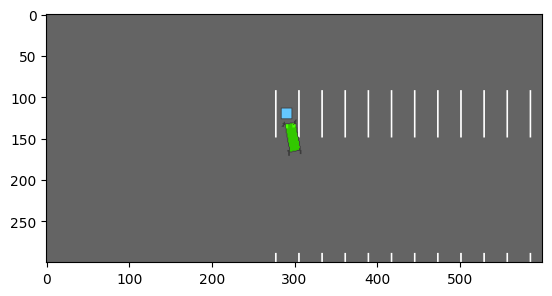

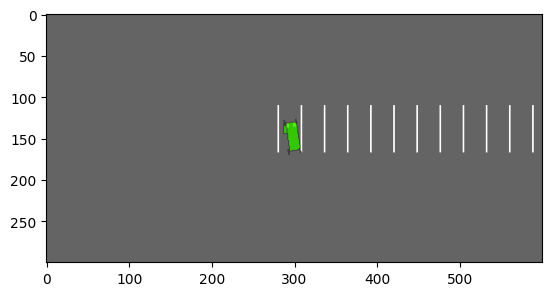

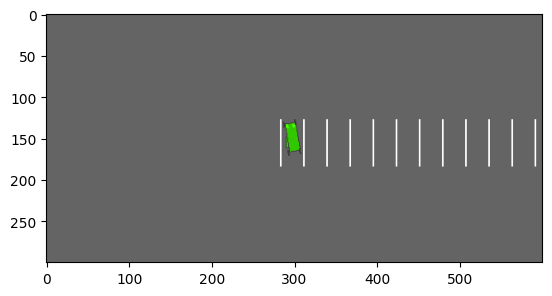

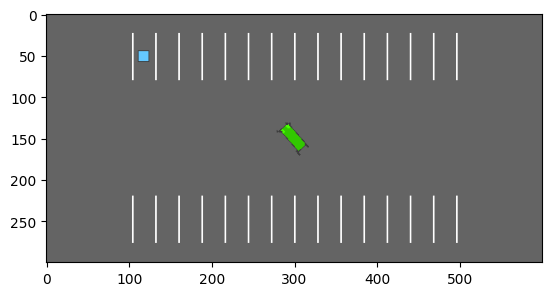

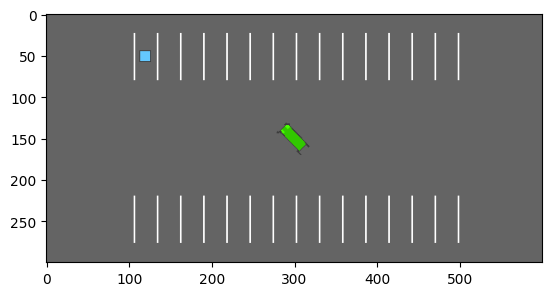

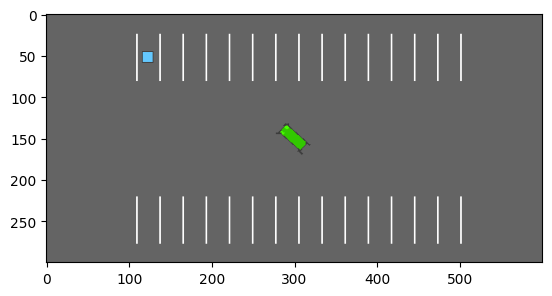

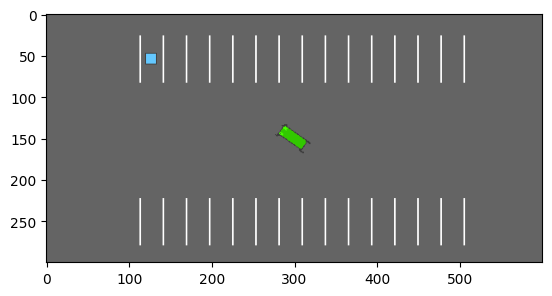

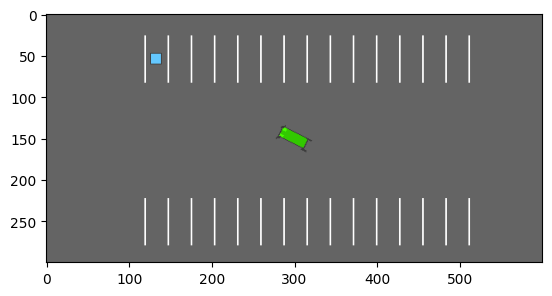

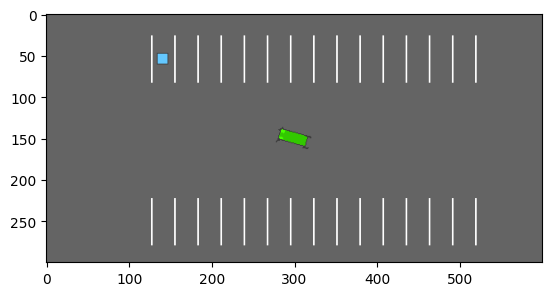

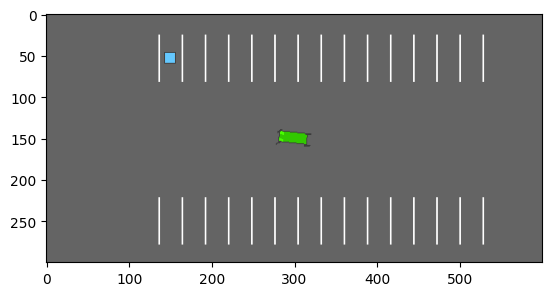

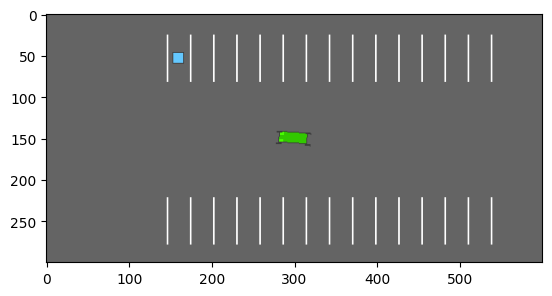

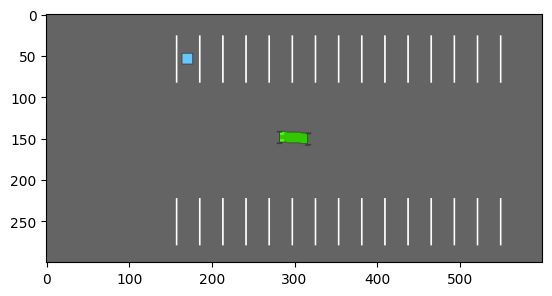

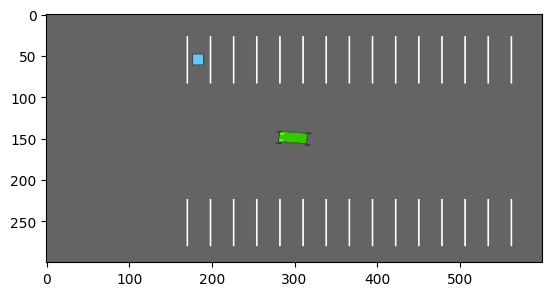

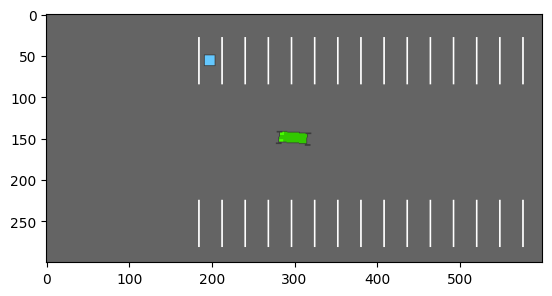

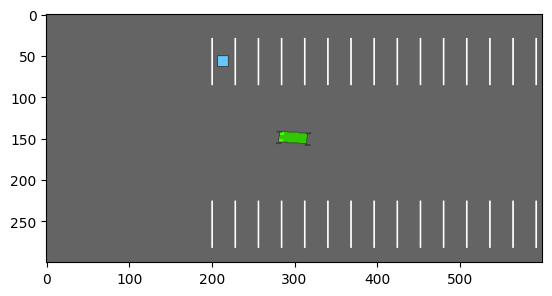

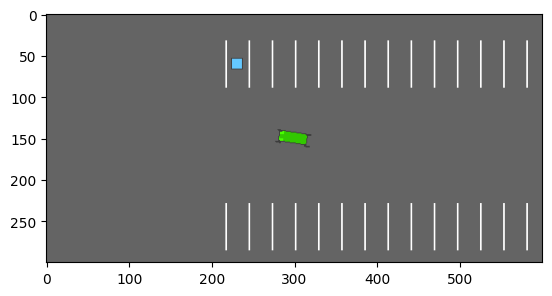

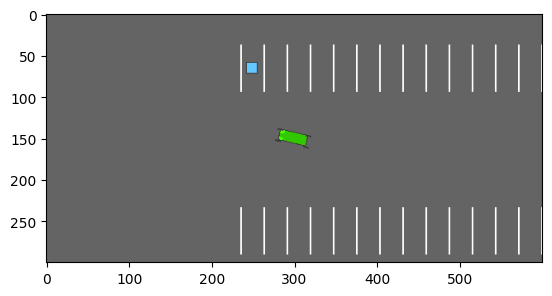

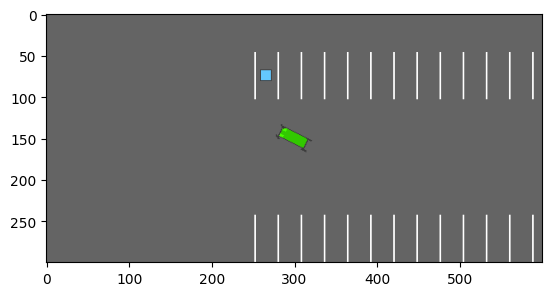

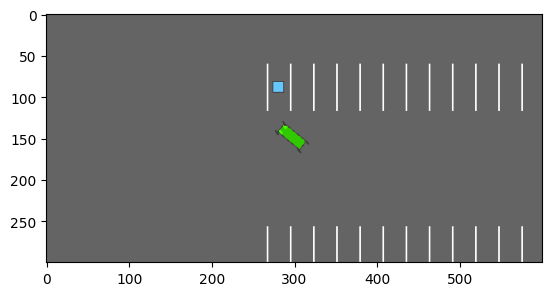

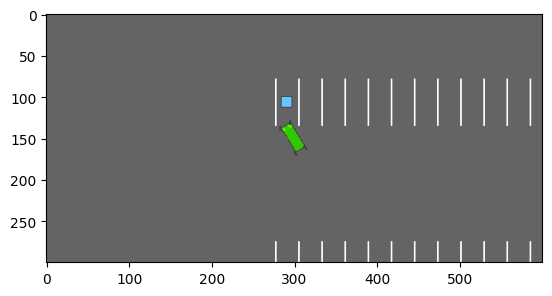

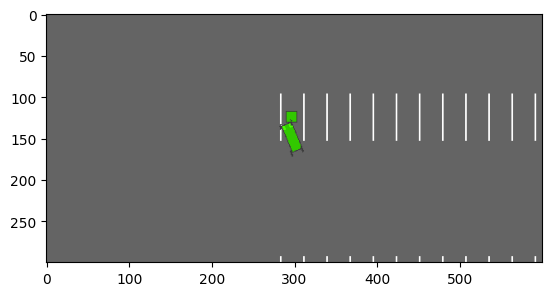

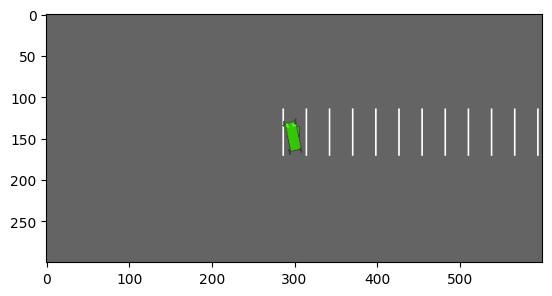

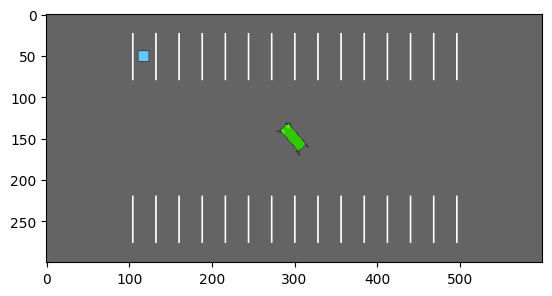

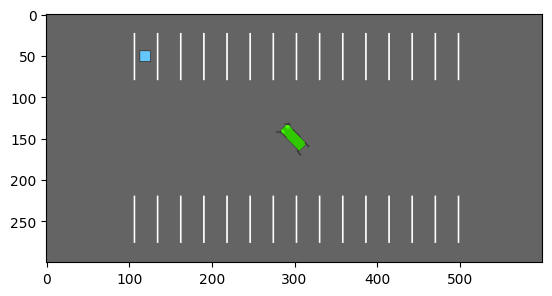

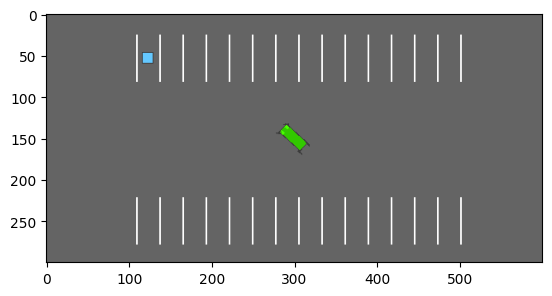

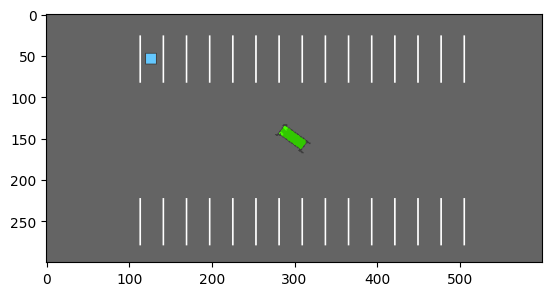

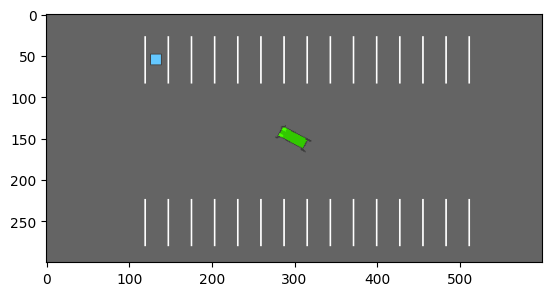

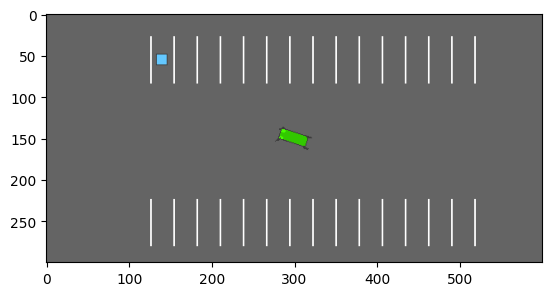

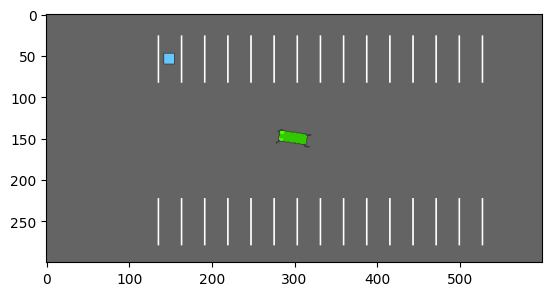

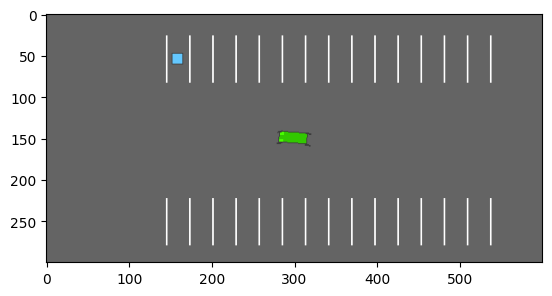

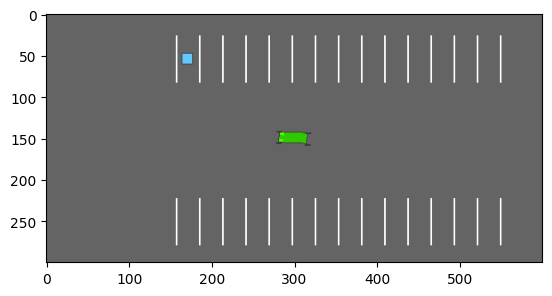

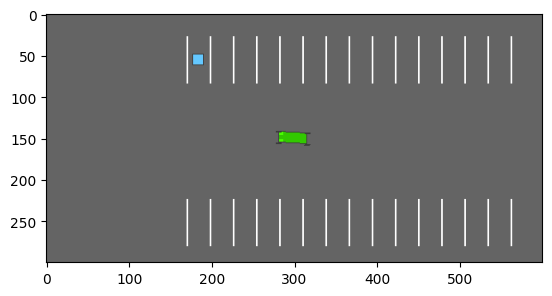

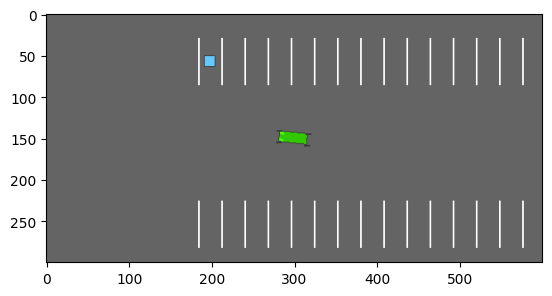

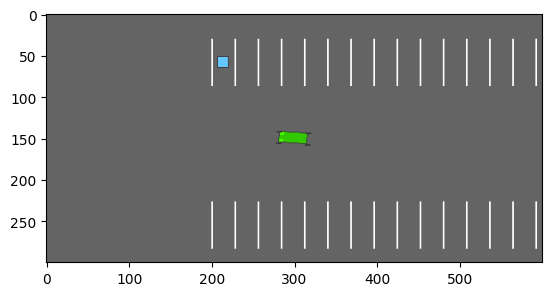

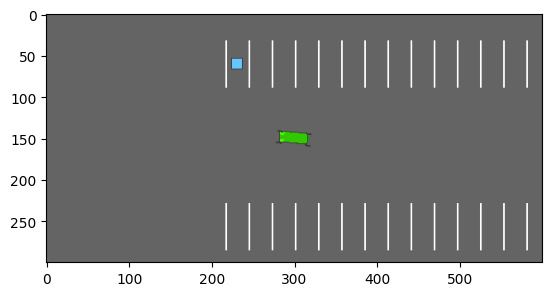

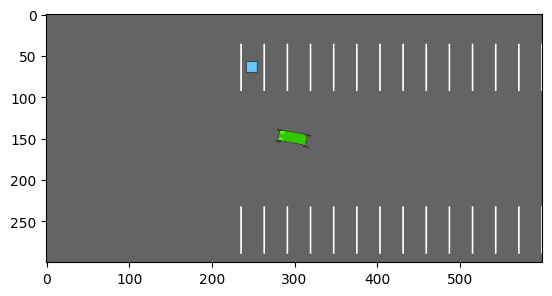

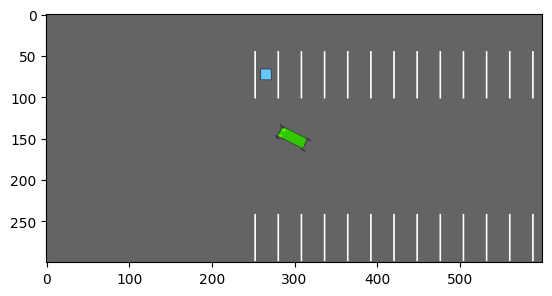

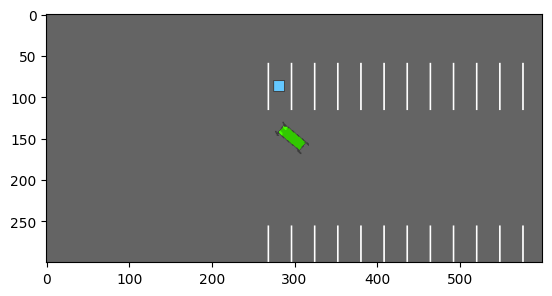

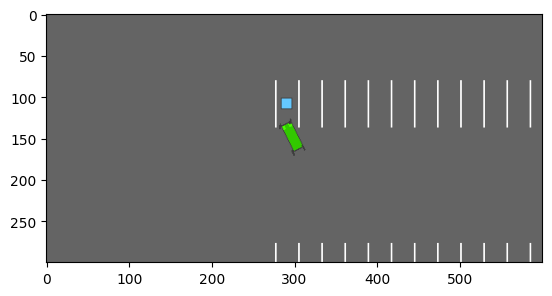

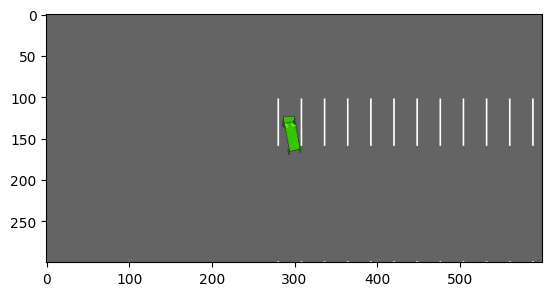

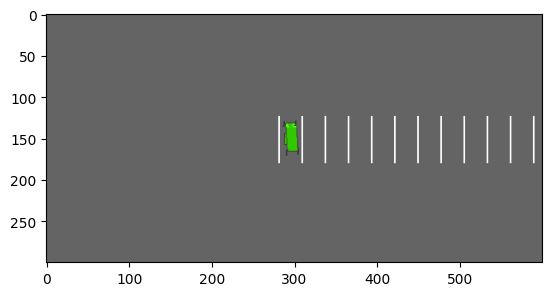

In [ ]:
for frame in DDPG_frames:
  plt.imshow(frame)
  plt.show()

In [ ]:
frames=DDPG_frames.copy()

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Choose the codec (codec may vary based on your system and installed codecs)
fps = 25  # Specify frames per second
frame_height, frame_width, _ = frames[0].shape  # Frame dimensions

out = cv2.VideoWriter('/content/drive/My Drive/Videos/DDPG_learning.mp4', fourcc, fps, (frame_width, frame_height))

# Write frames to video
for frame in frames:
    out.write(frame)

# Release the VideoWriter
out.release()

print("Video has been saved to Google Drive successfully!")

Video has been saved to Google Drive successfully!
